In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import scipy.stats as stats

import csv

#from mpltools import special ##leon

# for 3d plot
#import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits.mplot3d import Axes3D

#plt.style.use('seaborn-poster')
#plt.style.use('fivethirtyeight')
#plt.style.use('grayscale')
#plt.style.use('seaborn-colorblind')


# DEFINE DATA CLASS
class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1 (default time?)
        self.keytime=keytime # 2 +Time.deltaTime
        self.ttime=ttime # 3 Time.time
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx # 11
        self.hmd_ry=hmd_ry # 12
        self.hmd_rz=hmd_rz # 13

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime


LAT_KEY = ('-30','0','30')
LON_KEY = ('0','30','60','90','120','150','180')
LAT_KEY_F = (-30,0,30)
LON_KEY_F = (0,30,60,90,120,150,180)
    
    
class User(object):
    def __init__(self, lat, lon, user, test):
        self.lat=lat
        self.lon=lon
        self.user=user
        self.test=test
        self.speed_array = [[] for x in range(5)]
        self.time_array = [[] for x in range(5)]
        self.speed_raw = [[] for x in range(5)]
        self.time_raw = [[] for x in range(5)]
        self.speed_mean = [[] for x in range(5)]
        self.speed_std = [[] for x in range(5)]
        self.time_mean = [[] for x in range(5)]
        self.time_std = [[] for x in range(5)]
        
        self.time_median = [[] for x in range(5)]
        self.speed_median = [[] for x in range(5)]
        #print(np.array(self.speed_array).shape)
        
        self.round_array = []
        self.round_data = [[] for x in range(5)]
        
        self.time_5x3x7x4=self.time_array
        self.time_5x3x7_mean=self.time_mean
        self.time_5x3x7_median=self.time_median
        self.time_5x4=self.round_data
        
        
        


        
    ## READ DATA
    def _read_data(self, file):
        raw_data=[]
        print("Reading %s"%file)
        seperator="\t"
        with open(file,"r") as fp:
            for line in fp:
                if line.startswith("Time"):
                    continue     ## Skip the Header
                l=line[:-1]   ## Delete the Last Element then Return
                f=l.split(seperator)   ## Divide the Raw Data to Pieces
                if(int(f[3])==1):   ## 4.When Finish Targeting and Press Key
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
                else: 
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))

        return raw_data



    # Input Raw Data, Each Tester, return aim_time[[[,,,],,,,,][,,,,,][,,,,,]] 3-layer array
    # Every Target Aiming Time in aim_time[lat][lon] = [first, second, third]
    def _aim_time_filter(self, input_raw_data):
        aim_time={}
        filtered_data=[a for a in input_raw_data if a.keypress==1]

        for i in range(len(filtered_data)-1):
            if(filtered_data[i+1].targetid!=filtered_data[i].targetid):
                continue # when resuming back
            if((i <= (len(filtered_data)-3)) and
               (filtered_data[i-1].targetid==filtered_data[i+2].targetid) and
               (filtered_data[i-1].targetid==filtered_data[i].targetid) and
               (filtered_data[i-1].targetid==filtered_data[i+1].targetid)):
                continue # when two same targets appear one after one
            delta_time=filtered_data[i+1].ttime-filtered_data[i].ttime
            #print(delta_time, filtered_data[i].targetid)

            key1=str(int(filtered_data[i].target_lat))
            key2=str(int(filtered_data[i].target_lon))
            if(key1 in aim_time)==False:
                aim_time[key1]={}
            if(key2 in aim_time[key1])==False:
                aim_time[key1][key2]=[]

            aim_time[key1][key2].append(TimeData(filtered_data[i].targetid,filtered_data[i].target_lon,filtered_data[i].target_lat,delta_time))

        aim_time[str(0)][str(0)]=[]   # Special (0,0) Not Exist but for data processing, add a pseudo datum
        aim_time[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))

        return aim_time   # aim_time is 4*3*7 array{}

    LAT_KEY = ('-30','0','30')
    LON_KEY = ('0','30','60','90','120','150','180')

    def _extract_time(self, input_time):
        #lat = [a for a in input_time]
        #lon = [b for b in input_time[lat]]
        #target = [c.deltatime for c in input_time[lon] ]
        
        time_dict = {}
        time_flat = [] # not useful, not sorted
        
        
        print("!!TEST")
        print(self.test)
        
        if (self.test<3):
            lat_order = ['-30','0','30']
        else:
            lat_order = ['0']
        #lat_order = ['-30','0','30']
        lon_order = ['0','30','60','90','120','150','180']
        
        for lat in lat_order:
            time_dict[lat] ={}
            time_lon = []
            for lon in lon_order:
                time_dict[lat][lon] = [target.deltatime for target in input_time[lat][lon]]
                time_target = [target.deltatime for target in input_time[lat][lon]]
                time_lon.append(time_target)
            time_flat.append(time_lon)

        return time_dict, time_flat
    
    def _cal_round(self, input_time_dict, test):
        r=[[],[],[],[]]
        #print(input_time_dict)
        for lat in input_time_dict:
            for lon in input_time_dict[lat]:
                if ((lon=='0') and (lat=='0')):
                    continue
                for i in range(4):
                    #print("lat", lat, "lon", lon, "i", i, "value", input_time_dict[lat][lon][i])
                    if (i >= len(input_time_dict[lat][lon])):
                        print("Round "+str(i+1)+"("+lat+","+lon+" Not Enough Data")
                        #r[i].append(input_time_dict[lat][lon][-1])
                        r[i].append(np.mean(input_time_dict[lat][lon]))
                    else:
                        r[i].append(input_time_dict[lat][lon][i])
                    

                
        self.round_array = [np.sum(r[0]), np.sum(r[1]), np.sum(r[2]), np.sum(r[3])]
        
        #print(round_array)
        if (False):
            fig,ax=plt.subplots()
            width = 0.6
            plt.bar(range(4), self.round_array, width, label='Round Time', color="G")
            plt.title('Test '+ str(test))
            ax = plt.gca()
            ax.yaxis.grid(True, linestyle = "--")      
            plt.show()
        
        return self.round_array

    def _flatten_data(self, input_data):
        
        flat_data = []
        
        for lat in input_data:
            data_lon = []
            for lon in input_data[lat]:
                data_target = [target for target in input_data[lat][lon]]
                data_lon.append(data_target)
            flat_data.append(data_lon)
        
        return flat_data
    
    def _time_to_speed(self, input_time):
        
        speed={}
        
        for lat in input_time:
            speed[lat]={}
            for lon in input_time[lat]:
                speed[lat][lon]=[]
                for target in range(len(input_time[lat][lon])):
                    if (input_time[lat][lon][target]==0):
                        #r.append(0) # speed = 0
                        speed[lat][lon].append(0)
                        continue
                    
                    angle = User._angle_ac(self, int(lat), int(lon))
                    speed[lat][lon].append( angle / input_time[lat][lon][target] )

        return speed    # 3*3*7 array{}

    def _angle_ap(self, lat, lon):
        angle = math.sqrt( lat**2 + lon**2 )
        return angle

    def _angle_ac(self, lat, lon):
        angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
        return angle

    # Calculate the Mean and STD
    def _dict_stat(input_dict): # return

        key1=['-30','0','30']    # 3 lat
        if (len(input_dict) == 1):
            key1=['0']    # 1 lat
        key2=[0,30,60,90,120,150,180]
        
        #key3= [lat for lat in input_dict]
        #key4= [lon for lon in input_dict[key3[0]]]
        key3 = input_dict.keys()
        key4 = input_dict['0'].keys()
    
        if (tuple(input_dict.keys()) != User.LAT_KEY):
            print('Error may happen')
        
        target_mean={}
        target_std={}
        for lat in input_dict:
            target_mean[lat]={}
            target_std[lat]={}
            for lon in input_dict[lat]:
                if(input_dict[lat][lon]==[0]):
                #if(k2==0):
                    target_mean[lat][lon]=0
                    target_std[lat][lon]=0
                    continue
                
                target_mean[lat][lon]=np.mean(input_dict[lat][lon])
                target_std[lat][lon]=np.std(input_dict[lat][lon])

        return target_mean, target_std    # 3*7 array[]

    def _list_stat(input_data): # return
        
        #print(np.array(input_data).shape)
            
        target_mean=[]
        target_std=[]
        target_median=[]
        
        #for lon in range(len(input_data)):
        for lat in range(len(input_data)):
            mean=[]
            std=[]
            median=[]
            #for lat in range(len(input_data[lon])):
            for lon in range(7):
                #if(lon==1 and lat==0):
                #if(k2==0):
                if (input_data[lat][lon] == [0]):
                    mean.append(0)
                    std.append(0)
                    median.append(0)
                    continue
                data = [target for target in input_data[lat][lon]]
                mean.append(np.mean(data))
                std.append(np.std(data))
                median.append(np.median(data))
                        
    
            target_mean.append(mean)
            target_std.append(std)
            target_median.append(median)

        return target_mean, target_std, target_median    # 3*7 array[]


    def add_test(self, test, file):
        
        print("test", self.test)
        self.test = test
        print("test", self.test)
        
        
        raw_data = User._read_data(self, file)
        aim_time = User._aim_time_filter(self, raw_data)
        time_dict, time_flat1 = User._extract_time(self, aim_time)
        
        self.round_data[test-1] = User._cal_round(self, time_dict, test)##
        
        time_flat = User._flatten_data(self, time_dict)
        speed_dict = User._time_to_speed(self, time_dict)
        speed_flat = User._flatten_data(self, speed_dict)
        
        #print(np.array(time_flat1)==np.array(time_flat))
        
        #self.speed_array.append(np.array(speed_flat))
        self.time_array[test-1] = time_flat
        self.speed_array[test-1] = speed_flat
        #self.time_raw.append(time_dict)
        self.time_raw[test-1] = time_dict
        self.speed_raw[test-1] = speed_dict
        
        #### mean or median here
        
        self.time_mean[test-1], self.time_std[test-1], self.time_median[test-1] = User._list_stat(time_flat)
        self.speed_mean[test-1], self.speed_std[test-1], self.speed_median[test-1] = User._list_stat(speed_flat)
        
        #self.time_mean = User._dict_stat
    
    def dict_print(dict_to_print):
        for x in dict_to_print:
            print ('--', x, '--')
            for y in dict_to_print[x]:
                print (y,':', dict_to_print[x][y])
                
    #def _mean(self, array):
    
    def cal_ratio(before, after):
        
        ratio=[]
        log=[]
        
        for i in range(len(before)):
            r=[]
            l=[]
            #print(len(before[i]))
            for j in range(len(before[i])):
                if(after[i][j]==0):
                    r.append(1) #ratio
                    l.append(0) #log
                    continue
                r.append( after[i][j] / before[i][j] ) #ratio
                l.append( math.log2( after[i][j] / before[i][j] ) ) #log
                #print(i,j,mean_after[i][j],mean_before[i][j])
            ratio.append(r)
            log.append(l)
            
        #print(np.array(ratio).shape)
        #print(np.array(log).shape)
        return ratio, log
    
    def ratio_of(self, data_type, average_type, before, after):
        if (data_type == 'time'):
            if (average_type == 'mean'):
                data_before = self.time_mean[before-1]
                data_after = self.time_mean[after-1]
            if (average_type == 'median'):
                data_before = self.time_median[before-1]
                data_after = self.time_median[after-1]
                
        if (data_type == 'speed'):
            if (average_type == 'mean'):
                data_before = self.speed_mean[before-1]
                data_after = self.speed_mean[after-1]
            if (average_type == 'median'):
                data_before = self.speed_median[before-1]
                data_after = self.speed_median[after-1]
            
        
        #print(np.array(self.speed_mean).shape)
        
        #print(np.array(self.speed_mean[before-1]).shape, np.array(data_before).shape)
        ratio0, log0 = User.cal_ratio(data_before, data_after)
        return ratio0, log0
            
        
def remove_zeros(input_data):
    data_new = list(input_data)[:]
    while (0 in data_new):         
        data_new.remove(0.)
    if (data_new == []):
        data_new = [0]
    return data_new


def m_stat(m_func, mtype=None):
    cal=m_func
    #if (m_type=='mean'):
    #    cal=np.mean
    #elif (m_type=='std'):
    #    cal=np.std
    #elif (m_type=='sum'):
    #    cal=np.sum
    #elif (m_type=='median'):
    #    cal=np.median
    #else:
    #    cal=np.array
        
    def m_stat_in(input_data):
        shape=np.array(input_data).shape
        print("data to cal is "+ str(shape))
        nozerooff = False
        if (mtype=='zero'):
            nozerooff = True
            print("No Zero OFF")
        else:
            nozeroff = False
            
            
        if (nozerooff):
            if (len(shape)==3):
                result = [[cal((lon)) for lon in lat] for lat in input_data]
            elif (len(shape)==2):
                #result = list(map(lambda i: cal(i), input_data))
                result = [cal((i)) for i in input_data]
            elif (len(shape)==1):
                result = cal((input_data))
            else:
                result = 0
                print("Error???")
            return result
        
        else:
            if (len(shape)==3):
                result = [[cal(remove_zeros(lon)) for lon in lat] for lat in input_data]
            elif (len(shape)==2):
                #result = list(map(lambda i: cal(i), input_data))
                result = [cal(remove_zeros(i)) for i in input_data]
            elif (len(shape)==1):
                result = cal(remove_zeros(input_data))
            else:
                result = 0
                print("Error???")
            return result
    return m_stat_in

m_mean=m_stat(np.mean)
m_mean_0=m_stat(np.mean, 'zero')
m_std=m_stat(np.std)
m_std_0=m_stat(np.std, 'zero')
m_sum=m_stat(np.sum)
m_median=m_stat(np.median)



    


class Exp(object):
    def __init__(self, _test_order, _user_order, _lat, _lon):
        self._test_order=_test_order
        self.lat=_lat
        self.lon=_lon
        self.user_order = _user_order
        
        self.time_mean_10x3x7 = [] #10*3*7
        self.time_mean_3x7x10 = [] #3*7*10
        self.time_mean_3x7 = [] #3*7
        self.time_std_3x7 = []
        self.time_mean_lon = [] #7
        self.time_mean_lat = [] #3
        self.time_mean_overall = 0 #1
        
        self.time_median_10x3x7 = [] #10*3*7
        
        self.speed_mean_10x3x7 = [] #10*3*7
        self.speed_mean_3x7x10 = [] #3*7*10
        self.speed_mean_3x7 = [] #3*7  # M1
        self.speed_std_3x7 = []
        self.speed_mean_lon = [] #7
        self.speed_mean_lat = [] #3
        self.speed_mean_overall = 0 #1
        
        self.speed_median_10x3x7 = [] #10*3*7
        
        self.no_user=True
        
        self.round_10x4 = []  # M1
        self.condition_10 = []
        
        
        
        self.time_10x3x7x4 = []
        #self.time_4x10 = self.round_10x4 #round time, sum
        #self.time_10x3x7_mean = self.time_mean_10x3x7
        #self.time_3x7x10_mean=[] #target time
        #self.time_20x10_mean #target time
        #self.time_10x3x7_median = self.time_median_10x3x7
        #self.time_3x10 = [] #lat time, sum
        #self.time_7x10 = [] #lon time, sum
        #self.time_10 = [] #condition time, sum
        
        self.median=[]
        
        
    class Average(object):
        def __init__(self, input_time_10x3x7x4, a_type):
            self.time_10x3x7x4 = input_time_10x3x7x4
            self.time_10x3x7 =[]
            self.time_3x7x10=[]
            self.time_3x10=[]
            self.time_7x10=[]
            self.time_20x10=[]
            self.average_type=a_type
            
            if (self.average_type == 'median'):
                self._average = np.median
            elif (self.average_type == 'mean'):
                self._average = np.mean
            else:
                self._average = np.mean
        
            
        def _cal_10x3x7(self, input_data):
            user=[]
            for userx in range(len(input_data)):
                lat=[]
                for latx in range(len(input_data[0])):
                    lon=[]  
                    #for lat in range(len(input_data[lon])):
                    for lonx in range(len(input_data[0][0])):
                        if (np.array(input_data).shape == (1,3,7)):
                            lon.append(input_data[userx][latx][lonx])
                            continue
                        if (input_data[userx][latx][lonx] == [0.0]):
                            lon.append(0)
                            continue
                        data = input_data[userx][latx][lonx]
                        #print(data)
                        lon.append(self._average(data))
                    lat.append(lon)
                user.append(lat)
            
            #print('###10x3x7###')  
            self.time_10x3x7 = user
            #print(np.array(self.time_10x3x7).shape)
            #print('###7x3x10###')  
            self.time_7x3x10 = np.array(user).T

            # input 10x3x7x4
            user_lat=[] # 10x3
            for userx in range(len(input_data)): # 10x3x7
                user_lat.append([np.sum(i) for i in user[userx]])
                
            #user_lat.append([np.sum(i) for i in userx]) for userx in user
            
            #print(np.array(user[0]).shape)
            #print(np.array(user[0]).T.shape)
            user_lon=[] # 10x7
            for userx in range(len(input_data)): # 10
                user_lon.append([np.sum(i) for i in np.array(user[userx]).T])
                
            user_target=[] # 10x3
            for userx in range(len(input_data)):
                user_target.append([i for i in np.array(user[userx]).flatten() if (i!=0)])
            
            user_round=[[np.sum(user[userx])] for userx in range(len(input_data))]
            #user_condition=[[np.sum(user[userx])] for userx in range(len(input_data))]
            
            if (np.array(input_data[0][0][0]).shape != ()):
                user_round_4=[]
                for userx in input_data: #10
                    user_r=np.zeros(4)
                    for lat in userx: #3
                        for lon in lat: #7
                                target_temp=lon[:]
                                #target_temp=lon #NO! LINKED
                                if (len(target_temp) <4):
                                    for i in range(4-len(target_temp)):
                                        target_temp.append(np.mean(lon)) 

                                if (len(target_temp) >4):
                                    target_temp=target_temp[:4]

                                user_r = user_r + np.array(target_temp)

                    user_round_4.append(list(user_r))
                
                self.time_10x4=user_round_4
                #self.time_10_mean=[np.mean(i) for i in user_round_4
                # use m_mean instead .time_1x10 more accurate
                self.time_4x10=np.array(user_round_4).T
                #self.time_4_mean=[np.mean(i) for i in np.array(user_round_4).T]
            

            #return user
            #print('###3x10###')  
            self.time_3x10=np.array(user_lat).T
            self.time_3_mean=[np.mean(i) for i in np.array(user_lat).T]
            #print(self.time_3x10.shape)
            #print('###7x10###')  
            self.time_7x10=np.array(user_lon).T
            self.time_7_mean = [np.mean(i) for i in np.array(user_lon).T]
            #print(self.time_7x10.shape)
            #print('###20x10###')  
            self.time_20x10=np.array(user_target).T # target 10x20
            self.time_20_mean = [np.mean(i) for i in np.array(user_target).T] # M2
            self.time_20x1=m_mean(self.time_20x10)
            #print(self.time_20x10.shape)
            
            
            self.time_7x3_mean = [[np.mean(j) for j in i] for i in np.array(user).T]
            self.time_7x3_std = [[np.std(j) for j in i] for i in np.array(user).T]
            self.time_3x7_mean = np.array(self.time_7x3_mean).T
            self.time_3x7_std = np.array(self.time_7x3_std).T
            self.time_1x10 = np.array(user_round).T  # M2
            self.time_1_mean = np.mean(np.array(user_round).T)
        
        
        def _cal_3x7x10(self, input_data):
            lat=[]    
            for latx in range(len(input_data[0])):
                lon=[]
                #for lat in range(len(input_data[lon])):
                for lonx in range(len(input_data[0][0])):
                    target=[]
                    for userx in range(len(input_data)):
                        if (np.array(input_data).shape == (1,3,7)):
                            target.append(input_data[userx][latx][lonx])
                            continue
                        if (input_data[userx][latx][lonx] == [0]):
                            target.append(0)
                            continue
                        data = input_data[userx][latx][lonx]
                        target.append(self._average(data))
                    lon.append(target)
                lat.append(lon)
            #print(lat)
            
            user=lat[:] # 3x7x10
            if (True):
                userT= list(np.array(lat[:]).T)
                #print(np.array(user).shape)
                #print(np.array(userT).shape)
                
                # 3x10
                lat_3=np.array([np.zeros(len(user[0][0])) for i in range(len(user))])
                for lonx in range(len(user[0])):
                    temp=[ user[latx][lonx] for latx in range(len(user)) ]
                    lat_3 = lat_3 + np.array(temp)

                # 7x10
                lon_7=np.array([np.zeros(len(user[0][0])) for i in range(len(user[0]))])
                for latx in range(len(user)):
                    temp=[ user[latx][lonx] for lonx in range(len(user[0])) ]
                    lon_7 = lon_7 + np.array(temp) #10x3

                #tar_21=np.zeros(21)
                tar_21=[]
                lonx=0
                latx=0
                for tarx in range(len(user)*len(user[0])):
                    #tar_21 = tar_21 + np.array(np.array(user).flatten()[tarx])
                    tar_21.append([])
                    tar_21[tarx] = user[latx][lonx]
                    #print("latx,lonx", latx, lonx)
                    latx = latx if (lonx<6) else latx+1
                    lonx = lonx + 1 if (lonx <6) else 0
                # tar_20 = np.delete(np.array(tar_21),7)
                tar_20 = [ tar_21[targetx] for targetx in range(len(tar_21)) if (tar_21[targetx][0] != 0)]
                #tar_20 = np.array(tar_21).shape

                #return lat, lat_3, lon_7, tar_20
                
                self.time_3xx10=lat_3
                self.time_7xx10=lon_7
                self.time_20xx10=tar_20
                
            self.time_3x7x10=user
            
        

    def add_user(self, temp_user):
        #print('temp_user.time_array',temp_user.time_array[self._test_order-1])
        #print('self.data_group',np.array(self.data_group))
        self.time_mean_10x3x7.append(temp_user.time_mean[self._test_order-1])
        self.time_median_10x3x7.append(temp_user.time_median[self._test_order-1])
        
        self.speed_mean_10x3x7.append(temp_user.speed_mean[self._test_order-1]) #not accurate
        self.speed_median_10x3x7.append(temp_user.speed_median[self._test_order-1]) #not accurate
        
        self.round_10x4.append(temp_user.round_data[self._test_order-1])
        self.condition_10.append(np.sum(temp_user.round_data[self._test_order-1]))
        
        self.time_10x3x7x4.append(temp_user.time_5x3x7x4[self._test_order-1])
        
        #self.median = Median(temp_user.time_5x3x7x4[self._test_order-1])
    

    
    
    def _cal_mean_3x7(input_data):
        mean=[]
        std=[]
        #print(np.array(input_data))
        for lat in range(len(input_data[0])):
            m=[]
            s=[]
            for lon in range(len(input_data[0][0])):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                m.append(np.mean(all_user)) # *7
                s.append(np.std(all_user))
            mean.append(m)
            std.append(s)# *3
            
        return mean, std
    
    
    def _cal_mean_1(input_data):
        #print(np.array(input_data))
        
        data = [i for i in np.array(input_data).flatten() if (i!=0)]
        #print(np.array(input_data).flatten())
        #mean = np.mean(np.delete(np.array(input_data), 7))
        #std = np.std(np.delete(np.array(input_data), 7))
        mean = np.mean(data)
        std = np.std(data)
            
        return mean
    
    

    
    def cal_mean(self):
        self.time_mean_3x7, self.time_std_3x7 = Exp._cal_mean_3x7(self.time_median_10x3x7)  #####median/mean
        self.time_mean_overall = Exp._cal_mean_1(self.time_median_10x3x7)                  #####median/mean
        
        self.speed_mean_3x7, self.speed_std_3x7 = Exp._cal_mean_3x7(self.speed_median_10x3x7) #####median/mean # M1
        self.speed_mean_overall = Exp._cal_mean_1(self.speed_median_10x3x7)
        
       
        self.median=Exp.Average(self.time_10x3x7x4, 'median')
        self.median._cal_10x3x7(self.time_10x3x7x4)
        self.median._cal_3x7x10(self.time_10x3x7x4)
        
        self.mean=Exp.Average(self.time_10x3x7x4, 'mean')
        self.mean._cal_10x3x7(self.time_10x3x7x4)
        self.mean._cal_3x7x10(self.time_10x3x7x4)

        #self.time_mean_overall = np.mean(np.delete(np.array(self.time_mean_3x7), 7))
        #std
        #self.speed_mean_overall = np.mean(np.delete(np.array(self.speed_mean_3x7), 7))
        
        # not suitable for 345
        #self.time_mean_lat = [np.mean(self.time_mean_3x7[i]) for i in range(len(self.time_mean_3x7))]
        #self.time_mean_lat[1] = np.mean(self.time_mean_3x7[1][1:]) # lat=0
        #temp = np.transpose(self.time_mean_3x7)
        #self.time_mean_lon = [np.mean(temp[i]) for i in range(len(temp))]
        #self.time_mean_lon[0] = np.mean([temp[0][0],temp[0][2]]) # lon=0
        

def angle_ac(lat, lon):
    angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
    return angle

def displace():
    distance=[]
    for lat in [-30, 0, 30]:
        dis=[]
        for lon in [0, 30, 60, 90, 120, 150, 180]:
            angle = angle_ac(lat, lon)
            dis.append(angle)
        distance.append(dis)
    return distance   # 3*7 array{}

class Speed(object):
    def __init__(self, input_time, ttype=None):
        self.angle_3x7=displace()
        
        #print(np.array([self.angle_3x7]).shape)
        if (ttype is None):
            angle_data= [displace()]
        elif (ttype == '345'):
            angle_data= [[LON_KEY_F[:]] * 3]
        elif (ttype == '030'):
            angle_data= [[LON_KEY_F[:]]]
        else:
            print('Unknown Shape')
        angle = Exp.Average(angle_data, 'mean')
        angle._cal_10x3x7(angle_data)
        angle._cal_3x7x10(angle_data)
        
    
        self.angle=angle
        shape = np.array(input_time).shape
        u12 = 14
        u345 = 6
        #print(list(input_time[0]))
        print(shape)
        print(len(shape))
        #(input_time)
        if (len(shape)==3): 
            nozeros=[[[i if i!=0 else 1 for i in list(lon)] 
                  for lon in list(lat)] for lat in list(input_time)]
            
            if (shape[0]==3 and shape[1]==7): #3x7x10
                self.value = np.array(angle.time_3x7x10) / nozeros
            elif (shape[1]==7 and shape[2]==3): #10x7x3
                self.value = np.array(angle.time_3x7x10).T / nozeros
            elif (shape[1]==3 and shape[2]==7): #10x3x7
                self.value = np.array(angle.time_10x3x7) / nozeros
            else:
                print('Unknow Shape 3')
            
           
        elif (len(shape)==2): 
            nozeros=[[i if i!=0 else 1 for i in list(lon)] 
                  for lon in list(input_time)]

            if (shape==(3,7)): #3x7
                self.value = np.array(angle.time_3x7_mean) / nozeros
            elif (shape==(7,3)): #7x3
                self.value = np.array(angle.time_7x3_mean) / nozeros
            elif (shape[0]==3): #3x10
                self.value = np.array(angle.time_3x10) / input_time
            elif (shape[0]==7): #7x10
                self.value = np.array(angle.time_7x10) / input_time
            elif (shape[0]==20): #20x10
                self.value = np.array(angle.time_20x10) / input_time
            elif (shape[0]==6): #6x10
                self.value = np.array(angle.time_3x7x10[0][1:]) / input_time
            elif (shape[0]==1): #1x10 mean round time * user
                self.value = np.array(angle.time_1x10) / input_time
            elif (shape[0]==4): #4x10 4 round time * user
                print("HIT "*10)
                print(angle.time_1x10)
                self.value = 4* np.array(angle.time_1x10) / input_time
                print("get "*10)
            else:
                 print('Unknown Shape 2')
                
                
            
        elif (len(shape)==1): #7
            nozeros=[i if i!=0 else 1 for i in list(input_time)]
            
            if (shape==(20,)):
                self.value = np.array(angle.time_20_mean) / input_time
            elif (shape==(7,)):
                self.value = np.array(angle.time_7_mean) / input_time
            elif (shape==(3,)):
                self.value = np.array(angle.time_3_mean) / input_time
            elif (shape==(u12,) or shape==(u345,)):
                self.value = np.array(angle.time_1x10).T / input_time
            else:
                print('Unknow Shape 1')
                
        elif (len(shape)==0): #1
            self.value = np.array(angle.time_1_mean) / input_time
        #print(nozeros)
        else:
            print('ERROR')

        
        
    def __str__(self):
        return str(np.array(self.value))
        
    def __repr__(self):
        return str(self.value)


#demo = Speed(test1.median.time_20_mean)
#print(np.array(test1.median.time_3x7_mean).shape)
#print(np.array(demo.value))
#print(demo)

#print(np.array(test1.mean.time_1x10))        
#print(np.array(test1.mean.time_10x4))
#print(np.array(test1.round_10x4))

#print(np.array(test3.median.time_3x10).shape)
#print(np.array(test3.median.time_7x10).shape)
#print(np.array([displace()][0][0][0]).shape)
#print(np.array(test1.time_10x3x7x4).shape)
#print(np.array(test1.time_10x3x7x4[0][0][0]).shape)

#print(np.array(test1.median.time_7x10).shape)
#print(np.array(Speed(test1.median.time_3x7_mean).angle.time_3x7_mean))
#print(np.array(test1.median.time_3x7_mean))
#print(np.array(test3.median.time_3x7_mean).shape)

#print(np.array(test3.speed_mean_3x7))

#print(np.array(test1.median.time_10x3x7[0]))
#print(np.array(test1.time_median_10x3x7[0]))



In [2]:
def plot_single_user(which_type, input_data):
    
    data = input_data
    lon_key = [a for a in User.LON_KEY]
    lon_key.pop(0)
    
    if (len(input_data)>2):
        data_short = [a for a in data[1]]
        data_short.pop(0)
        plt.plot()

        plt.plot(User.LON_KEY, data[0], '-v', label="-30")
        plt.plot(lon_key, data_short, '-o', label="0")
        plt.plot(User.LON_KEY, data[2], '-^', label="30")
        
    else:
        data_short = [a for a in data[0]]
        data_short.pop(0)
        plt.plot()
        
        plt.plot(lon_key, data_short, '-o', label="0")
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_axisbelow(True)
    
    if (which_type=='ratio'):
        ax.set_ylim(0,2)
        ax.set_title('Ratio')
        plt.ylabel('Ratio Value')
    if (which_type=='log'):
        ax.set_ylim(-1,1)
        ax.set_title('Log')
        plt.ylabel('Log Value')
    
    plt.legend(title="Latitude", loc=2)
    #plt.ylabel(kind2 + kind1)
    plt.xlabel('Target Longitude')
    plt.show()
    
    



In [106]:
###################### choose user
#users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]#after 13
#users=[1,2,3,4,5,9,10,14,6,11] # remove 7,8,9 with only two round 8,13 with exception 12
#users=[1,2,3,4,5,9,10,14,6,12]
#users=[1,2,3,4,5,6,8,9,10,12] #roshan
#users=[14,16,17,18,19,15]
#users=[1,2]
######################



test1 = Exp(1,1,1,1)
test2 = Exp(2,1,1,1)
test3 = Exp(3,1,1,1)
test4 = Exp(4,1,1,1)
test5 = Exp(5,1,1,1)

users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]
#users=[1,2,3,4,5,9,10,14,6,8,12,11,7] # user8, user 13 seems to be outlier

for uid in range(len(users)):
    baseFolder=str(users[uid])
    test_id=[1,2]
    user_temp = User(1,1,uid,1)

    for idx in range(len(test_id)):
        user_temp.add_test(test_id[idx],"../Users/"+baseFolder+"/"+str(test_id[idx])+".txt")
    
    test1.add_user(user_temp)
    test2.add_user(user_temp)
        
users_3=[14,16,17,18,19,15]

for uid in range(len(users_3)):
    baseFolder=str(users_3[uid])
    #idx=[3,4,5]
    #test_id=[1,2]
    test_id=[3,4,5]

    #baseFolder = "1"
    #raw_data = read_data("../Users/"+baseFolder+"/"+str(idx[0])+".txt")

    user_temp = User(1,1,uid,1)
    #print(user_temp.time_raw[0])
    #print('!')
    for idx in range(len(test_id)):
        user_temp.add_test(test_id[idx],"../Users/"+baseFolder+"/"+str(test_id[idx])+".txt")
    
    #test1.add_user(user_temp)
    #test2.add_user(user_temp)
    
    test3.add_user(user_temp)
    test4.add_user(user_temp)
    test5.add_user(user_temp)
    
    #user_all.append(user_temp)
    #print(np.array(Test1.data_group).shape)
    #print('!')

    
    #User.dict_print(user_all[0].time_raw[0])
    #User.dict_print(user_all[1].time_raw[1])

    #print(np.array(user_all[1].time_mean[0]).shape)
    ratio, log = user_temp.ratio_of('time', 'mean',1,2)
    ratio_med, log_med = user_temp.ratio_of('time', 'median',1,2)
    #print(np.array(ratio).shape)
    
    #####plot_single_user('ratio', ratio)
    #plot_single_user('ratio', ratio)
    #plot_single_user('log', log_med)
    print(np.array(ratio).shape)
    #plot_single_user(log)
    
    
    


array1 = np.array([[1,2],[1,2,3]])
print(array1)




test 1
test 1
Reading ../Users/1/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/1/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/2/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/2/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/3/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/3/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/4/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/4/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/5/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/5/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/9/1.txt
!!TEST
1
Round 3(-30,0 Not Enough Data
Round 4(-30,0 Not Enough Data
Round 4(-30,30 Not Enough Data
Round 4(-30,60 Not Enough Data
Round 3(-30,90 Not Enough Data
Round 4(-30,90 Not Enough Data
Round 3(-30,120 Not Enough Data
Round 4(-30,120 Not Enough Data
Round 3(-30,150 Not Enough Data
Round 4(-30,150 Not Enough Data
Round 3(-30,180 Not Enough Data
Round 4(-30,180 Not Enough Data
Round 3(0,30 Not Enough Data
Round 4(0,30 Not Enough Data
Round 3(0,60 Not Enough Data
Round 4(0

!!TEST
4
test 4
test 5
Reading ../Users/16/5.txt
!!TEST
5
(0,)
test 1
test 3
Reading ../Users/17/3.txt
!!TEST
3
test 3
test 4
Reading ../Users/17/4.txt
!!TEST
4
test 4
test 5
Reading ../Users/17/5.txt
!!TEST
5
(0,)
test 1
test 3
Reading ../Users/18/3.txt
!!TEST
3
test 3
test 4
Reading ../Users/18/4.txt
!!TEST
4
test 4
test 5
Reading ../Users/18/5.txt
!!TEST
5
(0,)
test 1
test 3
Reading ../Users/19/3.txt
!!TEST
3
test 3
test 4
Reading ../Users/19/4.txt
!!TEST
4
test 4
test 5
Reading ../Users/19/5.txt
!!TEST
5
(0,)
test 1
test 3
Reading ../Users/15/3.txt
!!TEST
3
test 3
test 4
Reading ../Users/15/4.txt
!!TEST
4
test 4
test 5
Reading ../Users/15/5.txt
!!TEST
5
(0,)
[list([1, 2]) list([1, 2, 3])]


In [107]:
Exp.cal_mean(test1)
Exp.cal_mean(test2)
Exp.cal_mean(test3)
Exp.cal_mean(test4)
Exp.cal_mean(test5)

#print(m_mean(test3.mean.time_3x7x10))
#print(np.array(test1.mean.time_7xx10).shape)
#print(test1.mean.time_20xx10 == test1.mean.time_20x10)
#print(test1.mean.time_7xx10 == test1.mean.time_7x10)
#print(test1.mean.time_3xx10 == test1.mean.time_3x10)

# test1.mean.time_3x7_std == m_std(test1.mean.time_3x7x10

# print(np.array(m_mean(test1.mean.time_3x10)) / 6) #3
# ==
# print(np.array(m_mean(m_mean(test1.mean.time_3x7x10)))) #3

# print(m_mean(test1.mean.time_3x10)) #3x7sum
# ==
# print(m_sum(m_mean(test1.mean.time_3x7x10))) #3x7sum

# print(test1.mean.time_3x10) 3x10x7sum
# ==
# print(np.array(m_sum(test1.mean.time_10x3x7)).T) 

# print(m_mean(Speed(test1.mean.time_3x10).value)) #3
# ==
# print(m_mean(Speed(np.array(m_sum(test1.mean.time_10x3x7)).T).value)) #3x7

print(test1.mean.time_1x10.T)
print(m_mean(test1.mean.time_10x4))
#print(Speed(test1.mean.time_4x10).value.T)
#print(np.array(test1.mean.time_10x4).shape)

data to cal is (20, 14)
data to cal is (20, 14)
data to cal is (20, 14)
data to cal is (20, 14)
data to cal is (6, 6)
data to cal is (6, 6)
data to cal is (6, 6)
data to cal is (6, 6)
data to cal is (6, 6)
data to cal is (6, 6)
[[43.488635  ]
 [49.527665  ]
 [62.33467   ]
 [47.38917   ]
 [54.563945  ]
 [49.02161   ]
 [40.31672   ]
 [47.10075   ]
 [61.774177  ]
 [30.33005333]
 [87.27665   ]
 [74.50511667]
 [59.42665   ]
 [61.97409167]]
data to cal is (14, 4)
[43.49649999999994, 49.49860000000001, 63.27244999999985, 47.22167500000009, 53.799925000000016, 49.02160999999999, 41.340624999999946, 47.100750000000026, 61.97024, 30.683125000000032, 88.38530000000011, 74.50511666666668, 59.426649999999995, 61.974091666666745]


In [108]:
def remove_zero(input_data):
        data_new = list(input_data)[:]
        if (0 in input_data):         
            data_new.remove(0.)
        return data_new
    
def remove_one(input_data):
        data_new = list(input_data)[:]
        if (1. in input_data):         
            data_new.remove(1.)
        return data_new
    
def which_axis(input_data):

    if (np.array(input_data).shape == (3,7)):
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
    
    elif (np.array(input_data).shape == (7,3)):
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[-30, 0, 30]
        
    elif (np.array(input_data).shape == (3,)):
        key1=[-30, 0, 30]
        key2=[]
        
    elif (np.array(input_data).shape == (7,)):      
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[]
    
    elif (np.array(input_data).shape == ()):
        key1=[]
        key2=[]
    
    else:
        print("Error???")
        key1=[]
        key2=[]
         
    return key1, key2    



In [109]:
ALPHA=0.05

export_order=1

def export_img(y_title):
    global export_order
    plt.savefig('output/' + str(export_order) + '_' + y_title + '.pdf', dpi=300)
    export_order += 1


#print(test3.median.time_7x10)
#print(test3.median.time_7)

print(np.array(test1.round_10x4)==np.array(test1.median.time_10x4))
#print(np.array(test3.condition_10))

print(np.array(test1.time_mean_3x7)==np.array(test1.median.time_3x7_mean))
print(np.array(test1.time_std_3x7)==np.array(test1.median.time_3x7_std))


time_mean_334=[test3.mean.time_3x7_mean[0], test3.mean.time_3x7_mean[0], 
               test4.mean.time_3x7_mean[0]]
time_mean_455=[test4.mean.time_3x7_mean[0], test5.mean.time_3x7_mean[0], 
               test5.mean.time_3x7_mean[0]]
time_std_334=[test3.mean.time_3x7_std[0], test3.mean.time_3x7_std[0], 
              test4.mean.time_3x7_std[0]]
time_std_455=[test4.mean.time_3x7_std[0], test5.mean.time_3x7_std[0], 
              test5.mean.time_3x7_std[0]]
time_10x334=np.array([test3.mean.time_3x7x10[0], test3.mean.time_3x7x10[0],
             test4.mean.time_3x7x10[0]]).T
time_10x455=np.array([test4.mean.time_3x7x10[0], test5.mean.time_3x7x10[0],
             test5.mean.time_3x7x10[0]]).T
time_10x345=np.array([test3.mean.time_3x7x10[0], test4.mean.time_3x7x10[0],
             test5.mean.time_3x7x10[0]]).T
#print(np.array(time_10x334))

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]
[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]


In [110]:
### Sphericity Test ###
### Normality Test ###


def simple_sig_print(s,p):
    sig ='* reject H0' if (p<ALPHA) else ' not reject H0'
    print("stat = {:10.5g}, p = {:10.5g} {}".format(s,p,sig))

def sphericity_test_2(input_data):
    print("=== Sphericity Test x2 ===")
    print("--- Bartlett Test ---")
    s,p = stats.bartlett(input_data[0], input_data[1])
    simple_sig_print(s,p)
    print("--- Levene Test ---")
    s,p = stats.levene(input_data[0], input_data[1])
    simple_sig_print(s,p)
    print("--- Fligner Test ---")
    s,p = stats.fligner(input_data[0], input_data[1])
    simple_sig_print(s,p)
    
def sphericity_test_3(input_data):
    print("=== Sphericity Test x3 ===")
    print("--- Bartlett Test ---")
    s,p = stats.bartlett(input_data[0], input_data[1], input_data[2])
    simple_sig_print(s,p)
    print("--- Levene Test ---")
    s,p = stats.levene(input_data[0], input_data[1], input_data[2])
    simple_sig_print(s,p)
    print("--- Fligner Test ---")
    s,p = stats.fligner(input_data[0], input_data[1], input_data[2])
    simple_sig_print(s,p)
    
def sphericity_test_4(input_data):
    print("=== Sphericity Test x4 ===")
    print("--- Bartlett Test ---")
    s,p = stats.bartlett(input_data[0], input_data[1], input_data[2], input_data[3])
    simple_sig_print(s,p)
    print("--- Levene Test ---")
    s,p = stats.levene(input_data[0], input_data[1], input_data[2], input_data[3])
    simple_sig_print(s,p)
    print("--- Fligner Test ---")
    s,p = stats.fligner(input_data[0], input_data[1], input_data[2], input_data[3])
    simple_sig_print(s,p)

def normal_test(input_data, m_type=None):
    print("-"*30)
    print("=== Normality Test ===")
    print("Sample Population: {}".format(len(input_data)))
    
    if m_type is None:
        print("--- Shapiro-Wilk Test ---")
        stat, p = stats.shapiro(input_data)
        simple_sig_print(stat,p)
        
        
        print("--- D’Agostino’s K^2 Test ---")
        #if (len(input_data)>=20):
        if (len(input_data)>=8):
            stat, p = stats.normaltest(input_data)
            simple_sig_print(stat,p)
            #stat, p = stats.skewtest(input_data)
            #stat, p = stats.kurtosistest(input_data)
        elif (len(input_data)<20):
            print("Too small.")
        else:
            print("No result.")
        
        print("--- Kolmogorov-Smirnov --")
        mean=np.mean(input_data)
        std=np.std(input_data)
        stat, p = stats.kstest(input_data, 'norm', args=(mean, std))
        simple_sig_print(stat, p)
        
        
        print("--- Anderson-Darling Test ---")
        result = stats.anderson(input_data, 'norm')
        print('Statistic: %.3f' % result.statistic)
        
        for i in range(len(result.critical_values)):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
            else:
                print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
    
    print("-"*30)



In [153]:
### Normality PLOT ###

## Data Discription ##
## T-Test / One-Way ANOVA ##
## QQ Plot ##
## BOX PLOT ##
## Violin Plot ##
## Scatter Plot ##
## Histogram Plot ##

# from pylab import *
plt.style.use('default')


def plot_normal_test(input_1, input_2, y_title, input_3=None):
    
    print('<<<<<')
    print('First Sample')
    print(stats.describe(input_1),
          '\n Mean: ', np.mean(input_1),
          '\n Median: ', np.median(input_1),
          '\n STD: ', np.std(input_1, ddof=1), 
          '\n VAR: ', np.var(input_1, ddof=1))
    print('\n')
    print('Second Sample')
    print(stats.describe(input_2),
          '\n Mean: ', np.mean(input_2),
          '\n Median: ', np.median(input_2),
          '\n STD: ', np.std(input_2, ddof=1), 
          '\n VAR: ', np.var(input_2, ddof=1))
    print('\n')
    print('First Sample')
    #print(input_1)
    normal_test(input_1)
    print('Second Sample')
    if input_2 is not None:
        #print(input_1)
        normal_test(input_2)
        sphericity_test_2([input_1, input_2])
    
    print('\n')
    print('-'*30)
    
    if (input_3 is None):
        print("T-Test of Two Samples")
        print(ttest_rel(input_1, input_2))
        
    else:
        print('Third Sample Mean: ', m_mean(input_3))
        print(stats.describe(input_3),
              '\n Mean: ', np.mean(input_3),
              '\n Median: ', np.median(input_3),
              '\n STD: ', np.std(input_3, ddof=1), 
              '\n VAR: ', np.var(input_3, ddof=1))
        print('Third Sample')
        normal_test(input_3)
        sphericity_test_2([input_1, input_2, input_3])
        
        print("One-Way ANOVA of Three Samples")
        print(stats.f_oneway(input_1, input_2, input_3))
        print("T-Test of 1-2")
        print(ttest_rel(input_1, input_2))
        print("T-Test of 2-3")
        print(ttest_rel(input_2, input_3))
        print("T-Test of 1-3")
        print(ttest_rel(input_1, input_3))
        
    

    fig01, ax01 = plt.subplots()
    res = stats.probplot(input_1, dist='norm', plot=ax01)
    export_img("qqplot1")
    fig02, ax02 = plt.subplots()
    res = stats.probplot(input_2, dist='norm', plot=ax02)
    export_img("qqplot2")
    plt.show()
    

    
    if (input_3 is None):
        plot_data=[input_1, input_2]
        scatter_data =  [[1. for i in input_1], [2. for i in input_2]]
        scatter_data_bias =  [[1.2 for i in input_1], [2.2 for i in input_2]]
        xdata=[1,2]
        toxdata=[1,2]
    else:
        plot_data=[input_1, input_2, input_3]
        scatter_data =  [[1. for i in input_1], [2. for i in input_2], [3. for i in input_3]]
        scatter_data_bias =  [[1.2 for i in input_1], [2.2 for i in input_2], [3.2 for i in input_3]]
        xdata=[1,2,3]
        toxdata=[3,4,5]
    
    fig, ax = plt.subplots()
    print("box plot data shape: ", np.array(plot_data).shape)
    r = ax.boxplot(plot_data,  0, 'rD', 0, showmeans=True, meanline=True)
    out = r["fliers"][0].get_data()[1]
    print("out", out)
    
    ax.set_xlabel(y_title)
    ax.set_ylabel('Condition')
    ax.scatter(plot_data, scatter_data_bias,
                marker = "x", alpha=1)
    
    plt.grid(linestyle="--", axis='x', alpha=0.8)
    
    export_img('boxplot')
    plt.show()
    
    
    ## violin
    fig1, ax1 = plt.subplots()
    ax1.violinplot(plot_data, vert=False,
               showmeans=True, showmedians=True, showextrema=True)

    ax1.set_xlabel(y_title)
    ax1.set_ylabel('Condition')
    ax1.scatter(plot_data, scatter_data,
                marker = "x", alpha=1)
    plt.yticks(xdata, toxdata)
    
    export_img('violinplot')
    plt.show()
    
    ## scatter
    fig2, ax2 = plt.subplots()
    ax2.set_xlabel(y_title)
    ax2.set_ylabel('Condition')
    #ax2.scatter(plot_data, scatter_data,
    #            marker = "o", alpha=1)
    #for i in np.array(plot_data).T:
    #    ax2.plot(np.array(plot_data), xdata,
    
    for i in np.array(plot_data).T:
        ax2.plot(i, xdata,
    #ax2.plot(np.array(plot_data), xdata,
                 "-o", markerfacecolor='white', markeredgewidth =1, linewidth=0.5,
                 color= 'C0' if(i[0]>i[-1]) else 'C3',
                 alpha=1)
    
    plt.yticks(xdata, toxdata)
    
    export_img('scatterplot')
    plt.show()
    
    fig3, ax3 = plt.subplots()
    ax3.hist(input_1, density=True, facecolor='C0', alpha=0.5)
    ax3.hist(input_2, density=True, facecolor='C3', alpha=0.5)
    export_img('hitogram')
    
    plt.show()
 

In [154]:
### Scatter Plot ###

def angle_ac(lat, lon):
    angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
    return angle

def distance_g(input_type=None):    
    distance=[]

    for lat in ['-30', '0', '30']:
        dis=[]
        for lon in ['0', '30', '60', '90', '120', '150', '180']:
            angle = angle_ac(int(lat), int(lon))
            dis.append(angle)
        distance.append(dis)
    
    if input_type == "345" :
        return np.delete(np.copy(np.array(distance)[1]),0)
    else:
        return np.delete(np.copy(np.array(distance)).flatten(), 7)
    
    #return distance   # 3*3*7 array{}

def plot_scatter(input_1, input_2):

    distance = distance_g()
    fig, ax = plt.subplots()
    #print(np.array(distance))
    #print(np.array(input_1))
    ax.scatter(np.array(input_1).flatten(), np.array(distance).flatten(), marker = "+")
    ax.scatter(np.array(input_2).flatten(), np.array(distance).flatten(), marker = "o")
    

In [155]:
print(4 * test1.mean.time_1x10)
print(m_sum(test1.mean.time_10x4))

print(distance_g("12"))

[[173.95454    198.11066    249.33868    189.55668    218.25578
  196.08644    161.26688    188.403      247.096708   121.32021333
  349.1066     298.02046667 237.7066     247.89636667]]
data to cal is (14, 4)
[173.98599999999976, 197.99440000000004, 253.0897999999994, 188.88670000000036, 215.19970000000006, 196.08643999999995, 165.36249999999978, 188.4030000000001, 247.88096, 122.73250000000013, 353.54120000000046, 298.0204666666667, 237.70659999999998, 247.89636666666698]
[ 30.          41.40962211  64.34109373  90.         115.65890627
 138.59037789 150.          30.          60.          90.
 120.         150.         180.          30.          41.40962211
  64.34109373  90.         115.65890627 138.59037789 150.        ]


In [159]:
### Abosolute Time ###



#print([np.sum(i) for i in test1.round_10x4])
print('#####')
print(m_sum(test3.round_10x4))
print([np.sum(i) for i in test3.round_10x4])
print([np.sum(i) for i in test3.mean.time_10x4])
print(m_sum(test3.median.time_10x4))
print('#####')

test1_condition_time = [np.sum(i) for i in test1.round_10x4]
test2_condition_time = [np.sum(i) for i in test2.round_10x4]
test3_condition_time = [np.sum(i) for i in test3.round_10x4]
test4_condition_time = [np.sum(i) for i in test4.round_10x4]
test5_condition_time = [np.sum(i) for i in test5.round_10x4]



total = np.sum(distance_g()) * 4
test1_condition_speed = total / test1_condition_time
test2_condition_speed = total / test2_condition_time

print(test1_condition_time)
print(m_sum(test1.mean.time_10x4))
print(total / m_sum(test1.mean.time_10x4))
#print(Speed(m_sum(test1.mean.time_10x4)))

print(np.sum(LON_KEY_F))




#####
data to cal is (6, 4)
[44.535, 59.72890000000004, 44.43470000000005, 47.22129999999993, 52.72499999999968, 48.95399999999995]
[44.535, 59.72890000000004, 44.43470000000005, 47.22129999999993, 52.72499999999968, 48.95399999999995]
[44.535, 59.72890000000004, 44.43470000000005, 47.22129999999993, 52.72499999999968, 48.95399999999995]
data to cal is (6, 4)
[44.535, 59.72890000000004, 44.43470000000005, 47.22129999999993, 52.72499999999968, 48.95399999999995]
#####
[173.98599999999976, 197.99440000000004, 253.0897999999994, 188.88670000000036, 215.19970000000006, 196.08643999999995, 165.36249999999978, 188.4030000000001, 247.88096, 122.73250000000013, 353.54120000000046, 298.0204666666667, 237.70659999999998, 247.89636666666698]
data to cal is (14, 4)
[173.98599999999976, 197.99440000000004, 253.0897999999994, 188.88670000000036, 215.19970000000006, 196.08643999999995, 165.36249999999978, 188.4030000000001, 247.88096, 122.73250000000013, 353.54120000000046, 298.0204666666667, 237.706

In [168]:
print("###")
print(m_mean(4 * test1.mean.time_1x10))
print(4 * m_sum(m_mean(test1.mean.time_20x10)))
# ==
print(m_mean(m_sum(test1.mean.time_10x4)))
print(m_sum(m_mean(test1.mean.time_4x10)))
print("###")
print(4*(test1.mean.time_1x10) == m_sum(test1.mean.time_10x4))
print(4*(test1.mean.time_1x10) == m_sum(test1.mean.time_4x10.T))
print("###")
print(total / (4*test1.mean.time_1x10)  == Speed((test1.mean.time_1x10)).value)

###
data to cal is (1, 14)
[219.72282961904762]
data to cal is (20, 14)
data to cal is (20,)
219.72282961904764
data to cal is (14, 4)
data to cal is (14,)
220.48475952380954
data to cal is (4, 14)
data to cal is (4,)
220.48475952380952
###
data to cal is (14, 4)
[[False False False False False  True False  True False False False  True
   True  True]]
data to cal is (14, 4)
[[False False False False False  True False  True False False False  True
   True  True]]
###
data to cal is (20, 1)
(1, 14)
2
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]


In [116]:
print('##### condition 1')
print('time(average time): ',m_mean(m_sum(test1.mean.time_10x4)))
print('speed(total/average time): ',total / m_mean(m_sum(test1.mean.time_10x4))) 
print('speed(averge(total/time)): ',m_mean(total / m_sum(test1.mean.time_10x4))) 
print('##### condition 2 condition time')
print(np.mean(test2_condition_time))
print(total / np.mean(test2_condition_time))
print(m_mean(total / m_sum(test2.mean.time_10x4)))
print('##### condition 3 condition time')
print(np.mean(test3_condition_time))
print(np.sum(LON_KEY_F)*4 / np.mean(test3_condition_time))
print('##### condition 4 condition time')
print(np.mean(test4_condition_time))
print(np.sum(LON_KEY_F)*4 / np.mean(test4_condition_time))
print('##### condition 5 condition time')
print(np.mean(test5_condition_time))
print(np.sum(LON_KEY_F)*4 / np.mean(test5_condition_time))

print("##### total/average time ##### averge(total/time)")
print(total / m_mean(m_sum(test1.mean.time_10x4)))
print(m_mean(total / m_sum(test1.mean.time_10x4)))
print(total / m_mean(m_sum(test1.mean.time_10x4)), m_mean(m_sum(test1.mean.time_10x4)))
print(total / m_mean(m_sum(test2.mean.time_10x4)), m_mean(m_sum(test2.mean.time_10x4)))





##### condition 1
data to cal is (14, 4)
data to cal is (14,)
time(average time):  220.48475952380954
data to cal is (14, 4)
data to cal is (14,)
speed(total/average time):  34.28808420286127
data to cal is (14, 4)
data to cal is (14,)
speed(averge(total/time)):  36.586143323528574
##### condition 2 condition time
171.65664357142853
44.04140639540227
data to cal is (14, 4)
data to cal is (14,)
46.43317428454988
##### condition 3 condition time
49.599816666666605
50.80663940626131
##### condition 4 condition time
51.754309999999954
48.691596893089724
##### condition 5 condition time
39.88543333333337
63.18096080189671
##### total/average time ##### averge(total/time)
data to cal is (14, 4)
data to cal is (14,)
34.28808420286127
data to cal is (14, 4)
data to cal is (14,)
36.586143323528574
data to cal is (14, 4)
data to cal is (14,)
data to cal is (14, 4)
data to cal is (14,)
34.28808420286127 220.48475952380954
data to cal is (14, 4)
data to cal is (14,)
data to cal is (14, 4)
data to 

data to cal is (14, 4)
data to cal is (14, 4)
data to cal is (14, 4)
data to cal is (14, 4)
data to cal is (14, 4)
data to cal is (14, 4)
[173.98599999999976, 197.99440000000004, 253.0897999999994, 188.88670000000036, 215.19970000000006, 196.08643999999995, 165.36249999999978, 188.4030000000001, 247.88096, 122.73250000000013, 353.54120000000046, 298.0204666666667, 237.70659999999998, 247.89636666666698] [166.33899999999994, 142.70009999999982, 189.61329999999964, 160.09660000000008, 173.32889999999992, 128.29133333333345, 178.32221999999996, 152.42250000000033, 207.65779999999975, 100.68782999999988, 143.6019, 263.2418000000001, 220.57276000000005, 176.3169666666667]
------------------------------
=== Normality Test ===
Sample Population: 13
--- Shapiro-Wilk Test ---
stat =    0.96933, p =    0.88617  not reject H0
--- D’Agostino’s K^2 Test ---
stat =     0.3727, p =    0.82998  not reject H0
--- Kolmogorov-Smirnov --
stat =    0.10453, p =    0.99588  not reject H0
--- Anderson-Darlin

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


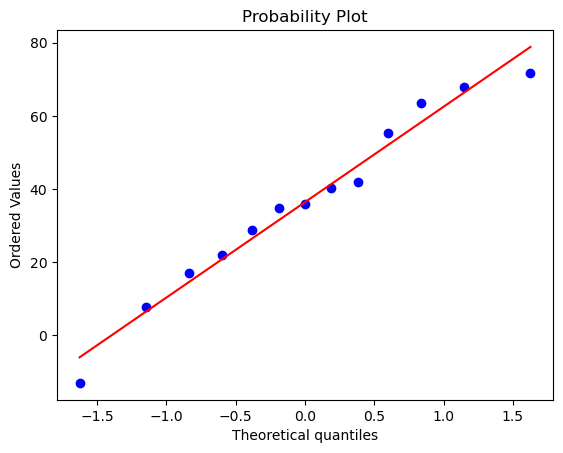

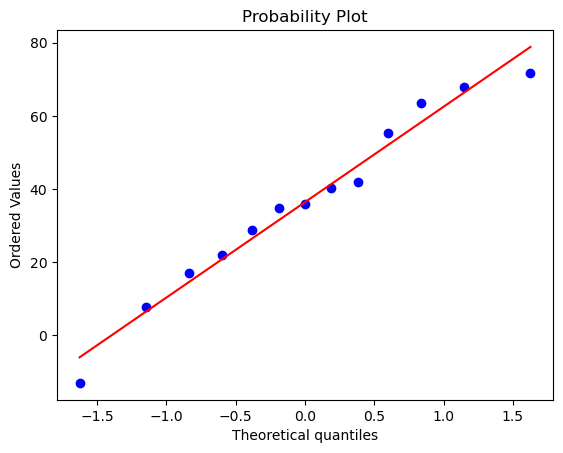

box plot data shape:  (2, 13)
out []


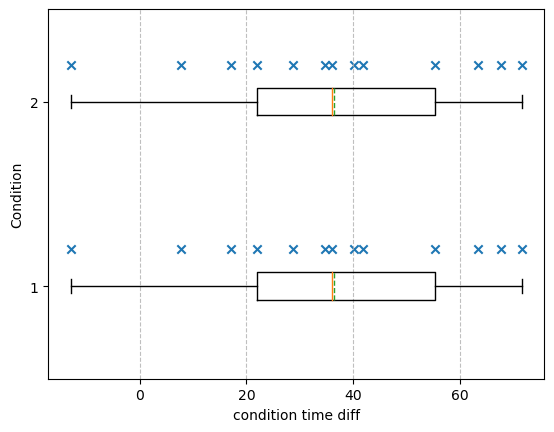

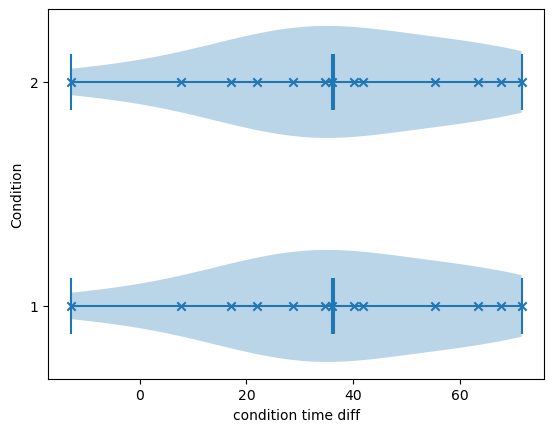

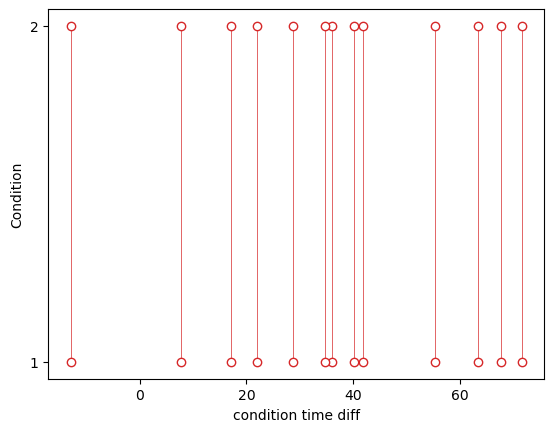

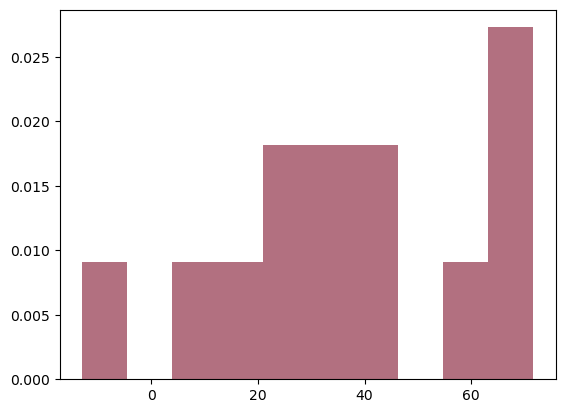

In [117]:
thesum = np.array(m_sum(test1.mean.time_10x4))+np.array(m_sum(test2.mean.time_10x4))
diff = np.array(m_sum(test1.mean.time_10x4))-np.array(m_sum(test2.mean.time_10x4))
diff = np.delete(diff,10)
#print('diff is %G' %(diff))
print(m_sum(test1.mean.time_10x4), m_sum(test2.mean.time_10x4))
print(normal_test(diff))
print(normal_test(thesum))
print(stats.ttest_rel(np.delete(m_sum(test1.mean.time_10x4),10),
                      np.delete(np.array(m_sum(test2.mean.time_10x4)), 10)))
print(stats.wilcoxon(m_sum(test1.mean.time_10x4),np.array(m_sum(test2.mean.time_10x4))))

plot_normal_test(diff, diff, 'condition time diff')

In [118]:
### Abosoulte Value ###
# test

print('condition time, old method: ',
      np.mean(test1_condition_time))
print('condition time, sum of round: ',
      np.mean(m_sum(test1.mean.time_10x4)))
print('condition time, sum of 20 target: ',
      4 * m_mean(m_sum(test1.mean.time_20x10.T)))
print('condition time, sum of 3x7 target: ',
      4 * np.mean(m_sum(m_sum(test1.mean.time_10x3x7))))



print('lat time', m_mean(test1.mean.time_3x10))
print('lat time of 1st target', m_sum(m_mean(test1.mean.time_3x7x10)))
      
print('1', m_mean(Speed(test2.mean.time_20x10).value.T))
print('2', Speed(m_mean(test2.mean.time_20x10)).value.T)
# print(m_mean(Speed(test2.mean.time_20x10.T).value)) # wrong

condition time, old method:  220.48475952380954
data to cal is (14, 4)
condition time, sum of round:  220.48475952380954
data to cal is (14, 20)
data to cal is (14,)
condition time, sum of 20 target:  219.72282961904764
data to cal is (14, 3, 7)
data to cal is (14, 3)
condition time, sum of 3x7 target:  219.72282961904762
data to cal is (3, 14)
lat time [19.878110321428572, 15.071429285714279, 19.98116779761906]
data to cal is (3, 7, 14)
data to cal is (3, 7)
lat time of 1st target [19.87811032142857, 15.07142928571428, 19.981167797619054]
data to cal is (20, 1)
(20, 14)
2
data to cal is (14, 20)
1 [43.75287291646348, 50.60814800078577, 38.66387358728035, 47.888597926957104, 42.03067800952038, 64.31684621246067, 40.16839794981839, 47.8111731563412, 36.02768615408825, 72.67295651552574, 52.39843567712605, 27.360368133283185, 36.316135366781836, 46.19774319390429]
data to cal is (20, 14)
data to cal is (20, 1)
(20,)
1
2 [23.65626767 25.52416547 28.26296042 43.61383926 45.97738177 51.2916


##### 1-2 #####

##### Condition Time (from round) #####
data to cal is (14, 4)
data to cal is (14, 4)
<<<<<
First Sample
DescribeResult(nobs=14, minmax=(122.73250000000013, 353.54120000000046), mean=220.48475952380954, variance=3422.3258346321472, skewness=0.6419292732104136, kurtosis=0.2521401027946255) 
 Mean:  220.48475952380954 
 Median:  206.59705000000005 
 STD:  58.500648155658475 
 VAR:  3422.3258346321472


Second Sample
DescribeResult(nobs=14, minmax=(100.68782999999988, 263.2418000000001), mean=171.65664357142853, variance=1657.1256895788622, skewness=0.5253376463778795, kurtosis=0.265539004644896) 
 Mean:  171.65664357142853 
 Median:  169.83394999999993 
 STD:  40.70780870519638 
 VAR:  1657.1256895788622


First Sample
------------------------------
=== Normality Test ===
Sample Population: 14
--- Shapiro-Wilk Test ---
stat =     0.9552, p =    0.64396  not reject H0
--- D’Agostino’s K^2 Test ---
stat =     2.4997, p =    0.28654  not reject H0
--- Kolmogorov-Smirnov --

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


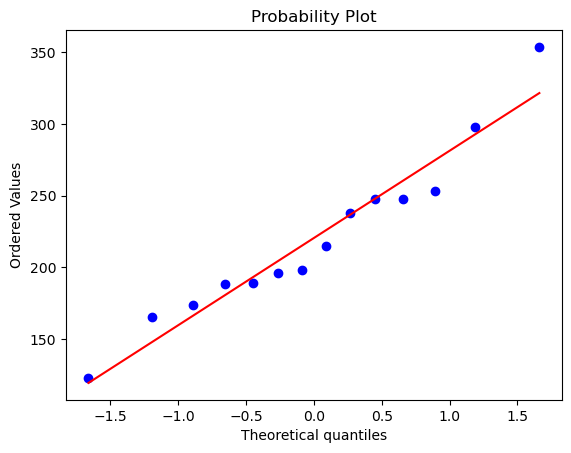

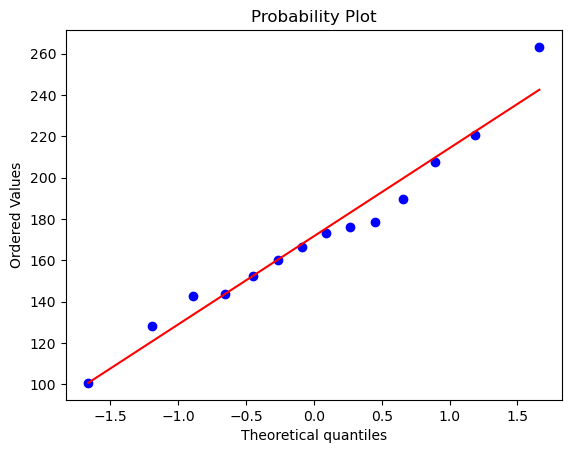

box plot data shape:  (2, 14)
out [1.]


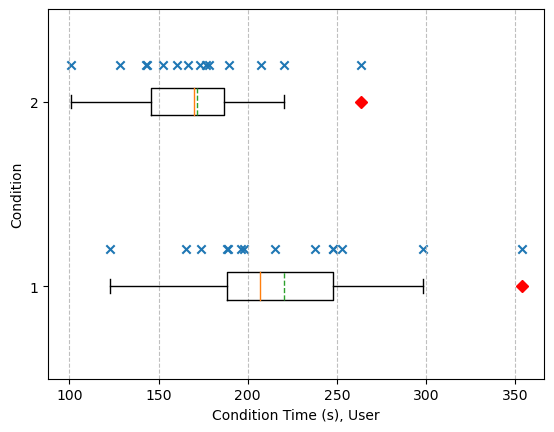

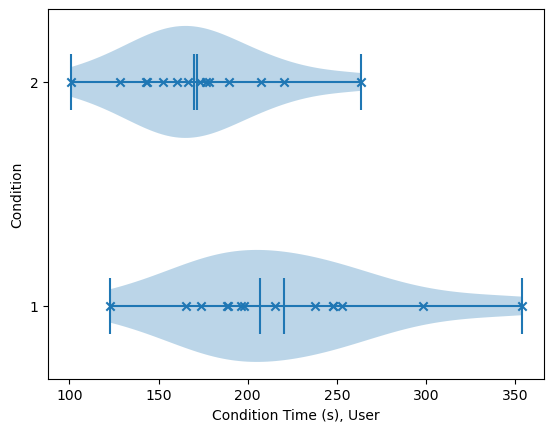

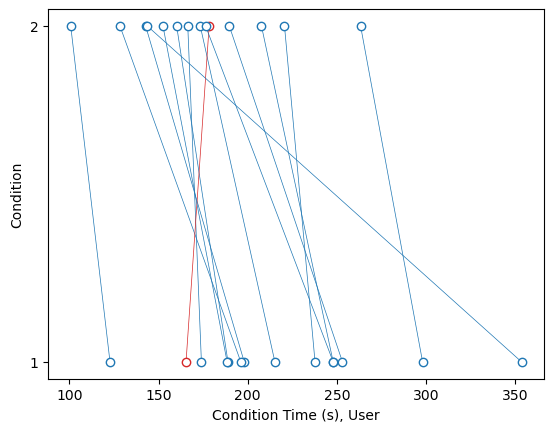

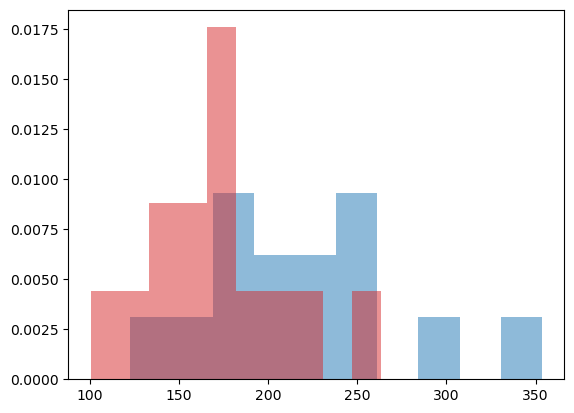


##### Condition Time (from target) #####
data to cal is (14, 20)
data to cal is (14, 20)
<<<<<
First Sample
DescribeResult(nobs=14, minmax=(121.32021333333334, 349.1066000000005), mean=219.72282961904764, variance=3363.694354659164, skewness=0.5690342551796452, kurtosis=0.1631579286824154) 
 Mean:  219.72282961904764 
 Median:  208.18322000000006 
 STD:  57.99736506651974 
 VAR:  3363.694354659164


Second Sample
DescribeResult(nobs=14, minmax=(100.94612399999987, 263.2418000000001), mean=171.99440314285712, variance=1661.5377097792107, skewness=0.5095638290547592, kurtosis=0.22357112345935626) 
 Mean:  171.99440314285712 
 Median:  169.7641599999999 
 STD:  40.76196400787394 
 VAR:  1661.5377097792107


First Sample
------------------------------
=== Normality Test ===
Sample Population: 14
--- Shapiro-Wilk Test ---
stat =     0.9601, p =    0.72479  not reject H0
--- D’Agostino’s K^2 Test ---
stat =     2.0171, p =    0.36475  not reject H0
--- Kolmogorov-Smirnov --
stat =    0.1552

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


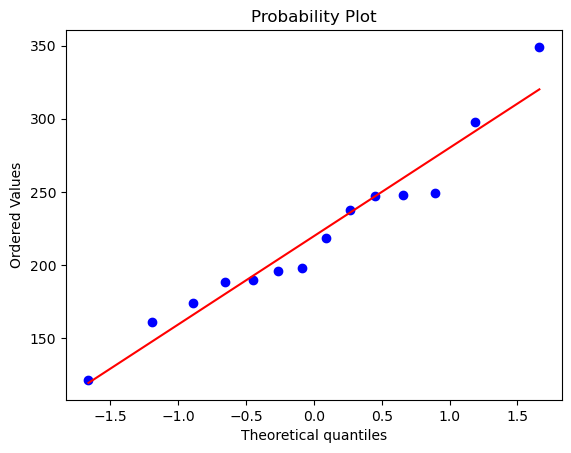

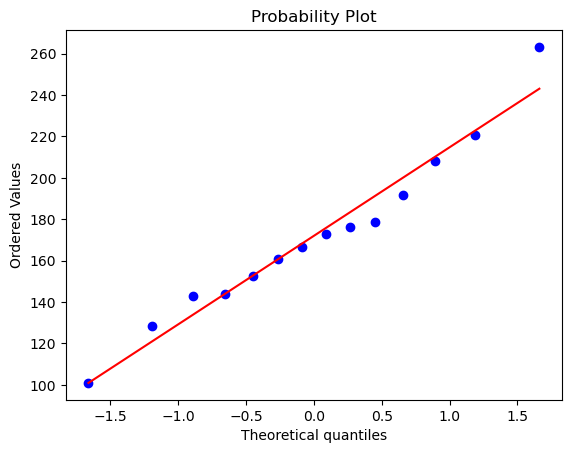

box plot data shape:  (2, 14)
out [1.]


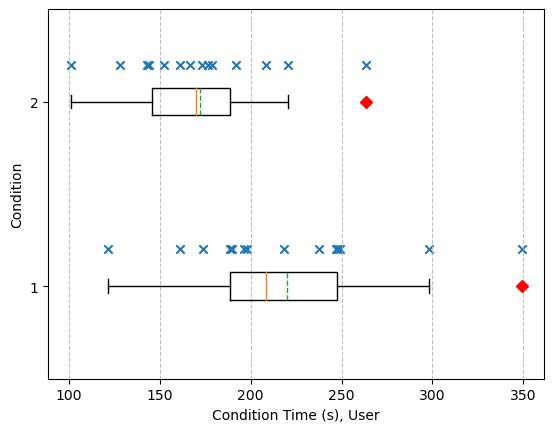

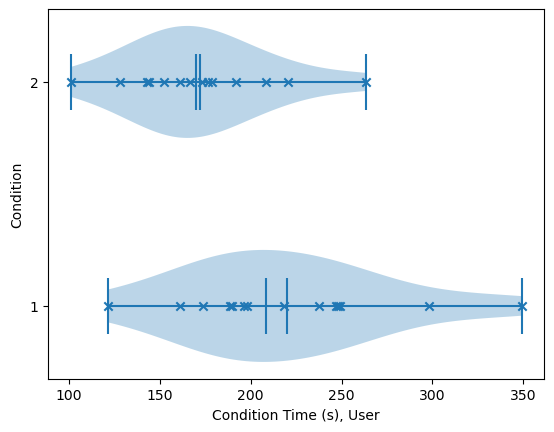

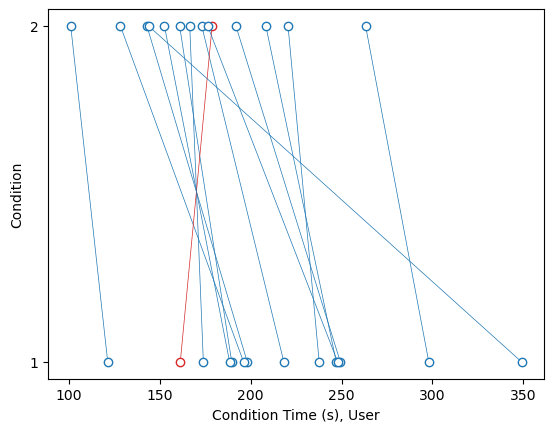

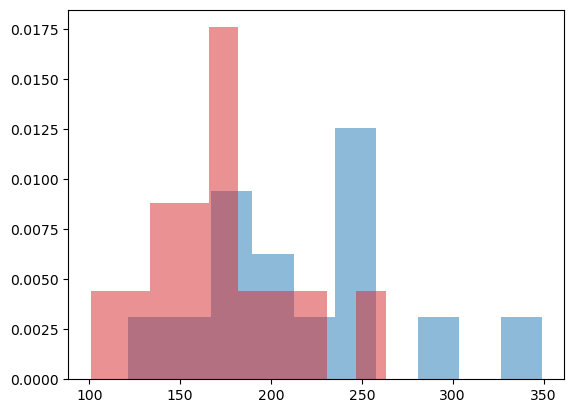


##### Condition Speed averge(total/time) (from round) #####
data to cal is (14, 4)
data to cal is (14, 4)
<<<<<
First Sample
DescribeResult(nobs=14, minmax=(21.38364637558505, 61.59737640804182), mean=36.586143323528574, variance=99.08203362094478, skewness=0.89320915391515, kurtosis=1.0114183183048873) 
 Mean:  36.586143323528574 
 Median:  36.65652929980208 
 STD:  9.953995862011636 
 VAR:  99.08203362094478


Second Sample
DescribeResult(nobs=14, minmax=(28.718843284007313, 75.08355279878421), mean=46.43317428454988, variance=131.70339239795956, skewness=0.9105027975568954, kurtosis=0.9847710142237509) 
 Mean:  46.43317428454988 
 Median:  44.53292681004801 
 STD:  11.476209844628999 
 VAR:  131.70339239795956


First Sample
------------------------------
=== Normality Test ===
Sample Population: 14
--- Shapiro-Wilk Test ---
stat =    0.93422, p =    0.34928  not reject H0
--- D’Agostino’s K^2 Test ---
stat =     5.4492, p =   0.065571  not reject H0
--- Kolmogorov-Smirnov --
stat 

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


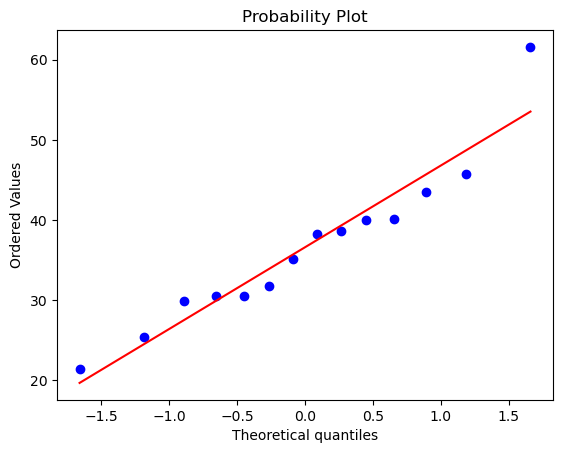

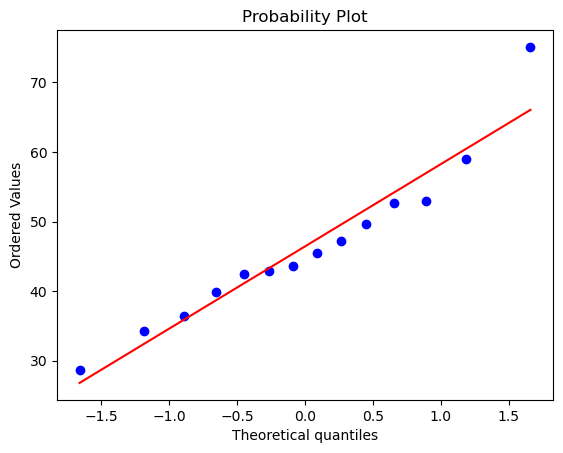

box plot data shape:  (2, 14)
out [1.]


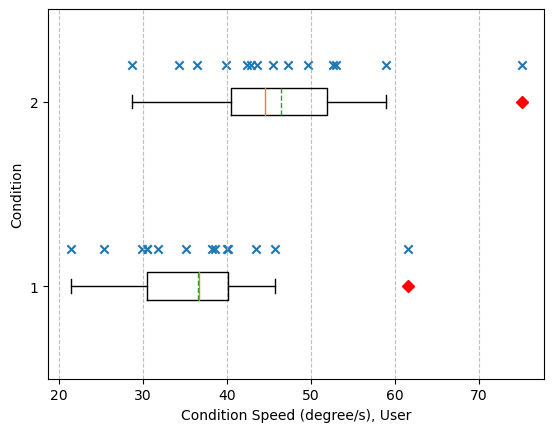

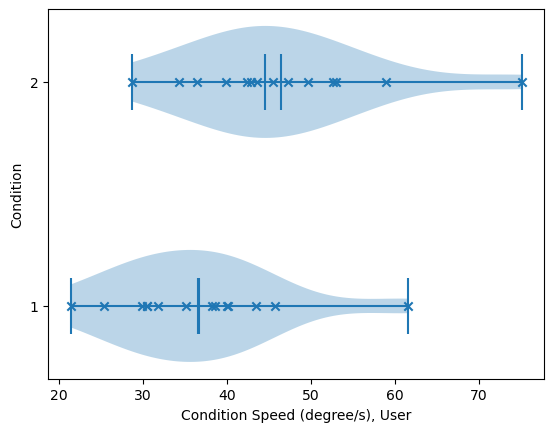

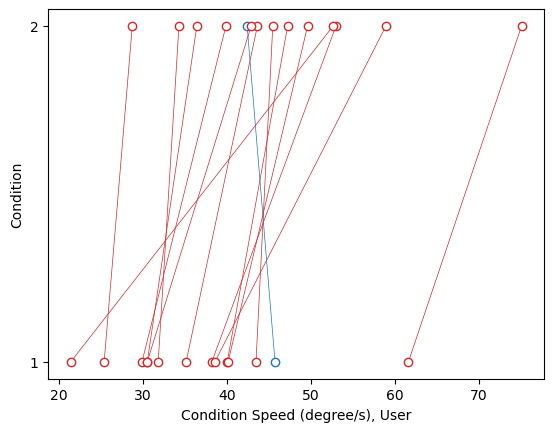

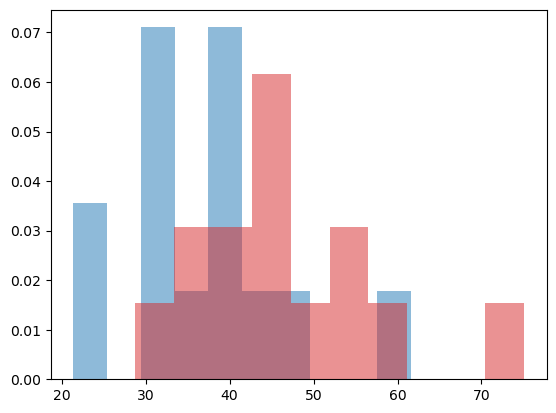


##### Condition Speed averge(total/time) (from target) #####
data to cal is (14, 20)
data to cal is (14, 20)
<<<<<
First Sample
DescribeResult(nobs=14, minmax=(21.655276640430138, 62.31443048347205), mean=36.73243081746956, variance=102.48258007814282, skewness=0.9547726419971444, kurtosis=1.060277661996773) 
 Mean:  36.73243081746956 
 Median:  36.39937431339234 
 STD:  10.123368020483243 
 VAR:  102.48258007814282


Second Sample
DescribeResult(nobs=14, minmax=(28.718843284007313, 74.89143416739815), mean=46.344123839725185, variance=131.39173861089648, skewness=0.9065895570513454, kurtosis=0.9511832276589613) 
 Mean:  46.344123839725185 
 Median:  44.54922823448574 
 STD:  11.462623548337286 
 VAR:  131.39173861089648


First Sample
------------------------------
=== Normality Test ===
Sample Population: 14
--- Shapiro-Wilk Test ---
stat =    0.92906, p =    0.29599  not reject H0
--- D’Agostino’s K^2 Test ---
stat =     5.9272, p =   0.051633  not reject H0
--- Kolmogorov-Smirnov 

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


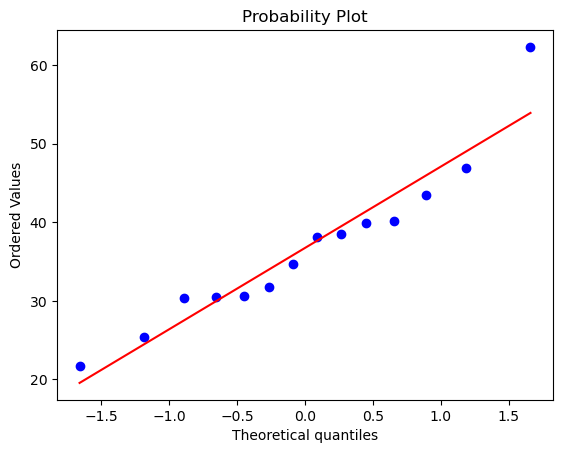

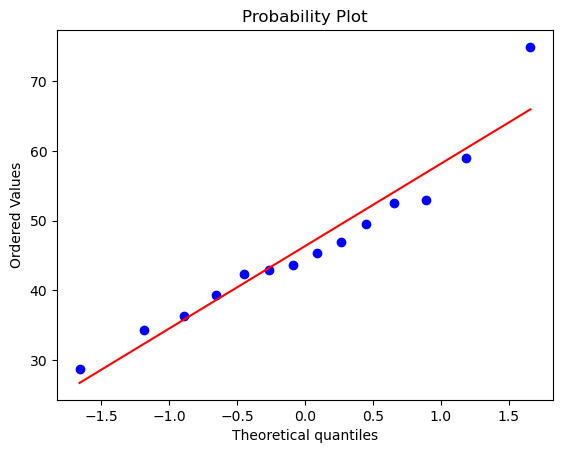

box plot data shape:  (2, 14)
out [1.]


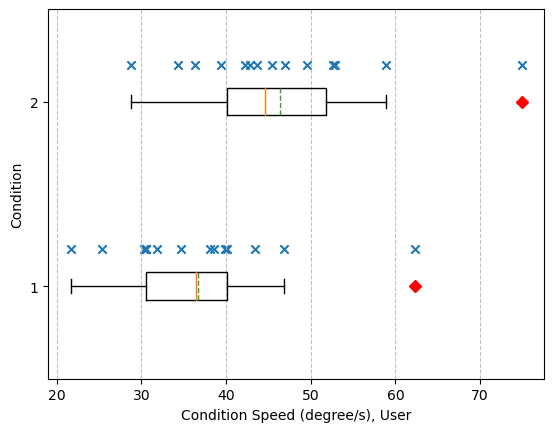

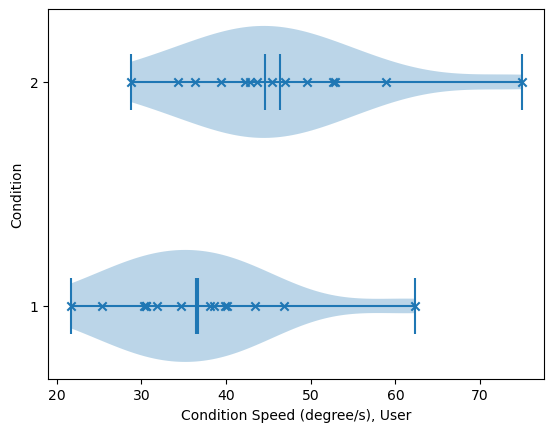

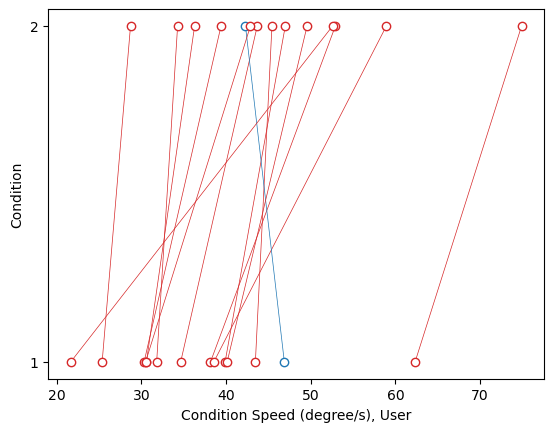

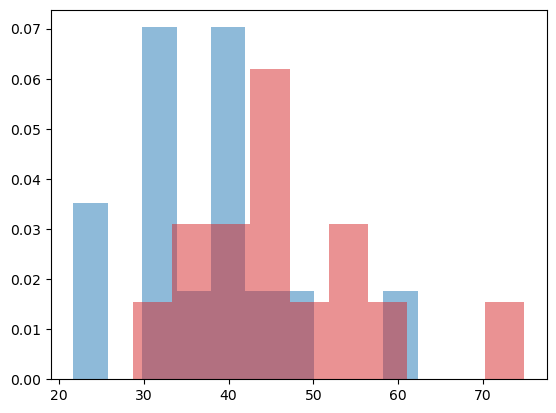


##### Round Time Mean #####
data to cal is (14, 20)
data to cal is (14, 20)
<<<<<
First Sample
DescribeResult(nobs=14, minmax=(30.330053333333336, 87.27665000000013), mean=54.93070740476191, variance=210.23089716619776, skewness=0.5690342551796452, kurtosis=0.1631579286824154) 
 Mean:  54.93070740476191 
 Median:  52.045805000000016 
 STD:  14.499341266629935 
 VAR:  210.23089716619776


Second Sample
DescribeResult(nobs=14, minmax=(25.236530999999967, 65.81045000000003), mean=42.99860078571428, variance=103.84610686120067, skewness=0.5095638290547592, kurtosis=0.22357112345935626) 
 Mean:  42.99860078571428 
 Median:  42.44103999999997 
 STD:  10.190491001968486 
 VAR:  103.84610686120067


First Sample
------------------------------
=== Normality Test ===
Sample Population: 14
--- Shapiro-Wilk Test ---
stat =     0.9601, p =    0.72479  not reject H0
--- D’Agostino’s K^2 Test ---
stat =     2.0171, p =    0.36475  not reject H0
--- Kolmogorov-Smirnov --
stat =    0.15523, p =    0.8

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


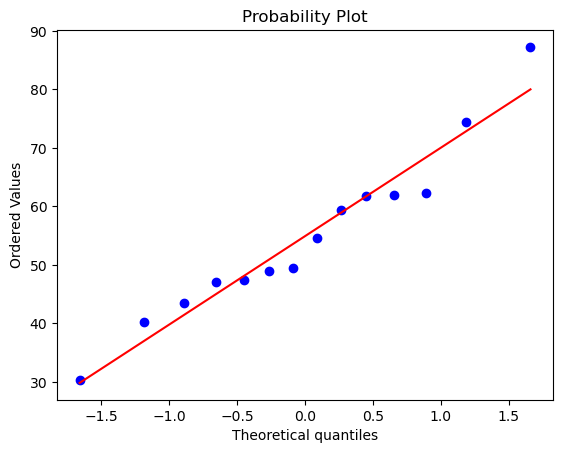

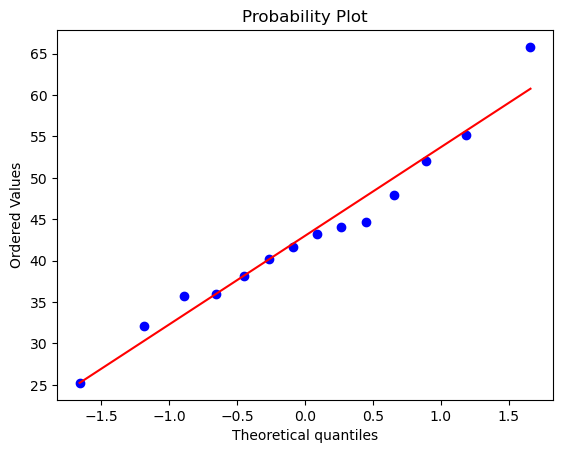

box plot data shape:  (2, 14)
out [1.]


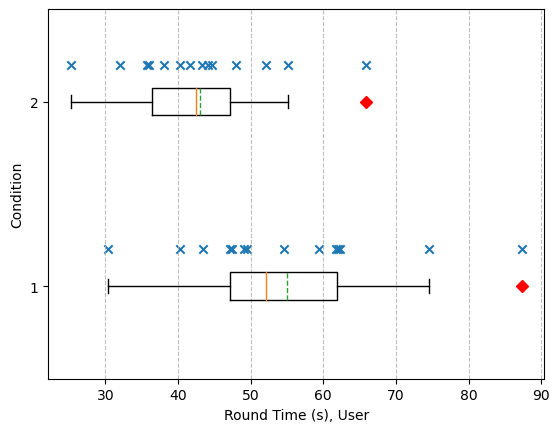

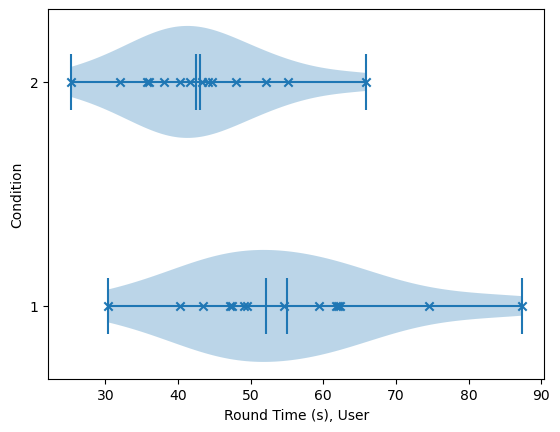

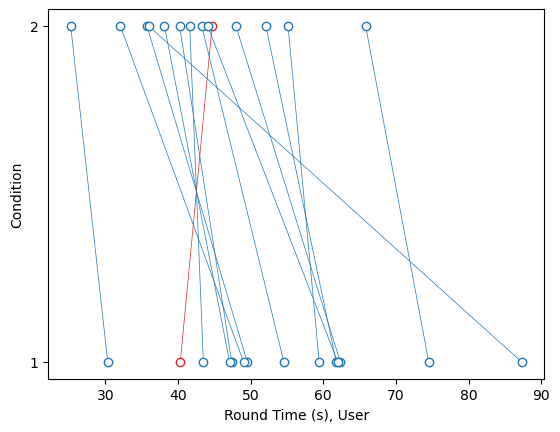

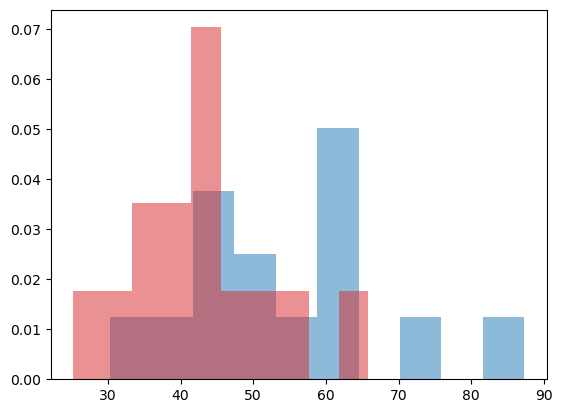


##### Target Time #####
data to cal is (20, 14)
data to cal is (20, 14)
<<<<<
First Sample
DescribeResult(nobs=20, minmax=(1.0421649999999973, 5.715124642857147), mean=2.7465353702380955, variance=1.8591343047610385, skewness=1.016494008503583, kurtosis=-0.10219642222848613) 
 Mean:  2.7465353702380955 
 Median:  2.3212803869047596 
 STD:  1.3635007534875214 
 VAR:  1.8591343047610385


Second Sample
DescribeResult(nobs=20, minmax=(0.994244285714287, 3.786331964285717), mean=2.1499300392857137, variance=0.5610888719359729, skewness=0.5331061193891378, kurtosis=-0.3181277521873329) 
 Mean:  2.1499300392857137 
 Median:  2.083196553571428 
 STD:  0.7490586572064787 
 VAR:  0.5610888719359729


First Sample
------------------------------
=== Normality Test ===
Sample Population: 20
--- Shapiro-Wilk Test ---
stat =    0.86945, p =   0.011492 * reject H0
--- D’Agostino’s K^2 Test ---
stat =     4.6255, p =    0.09899  not reject H0
--- Kolmogorov-Smirnov --
stat =    0.20979, p =    0.2986

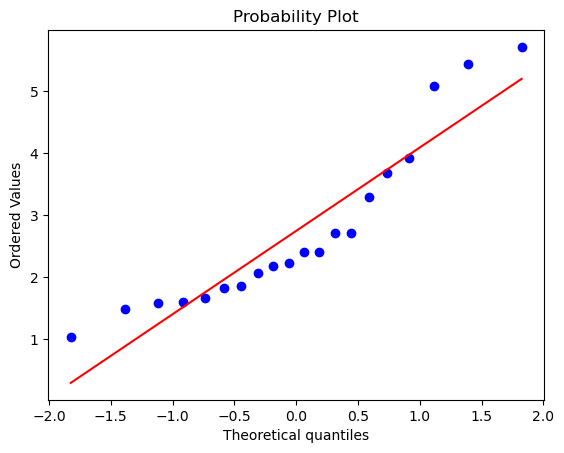

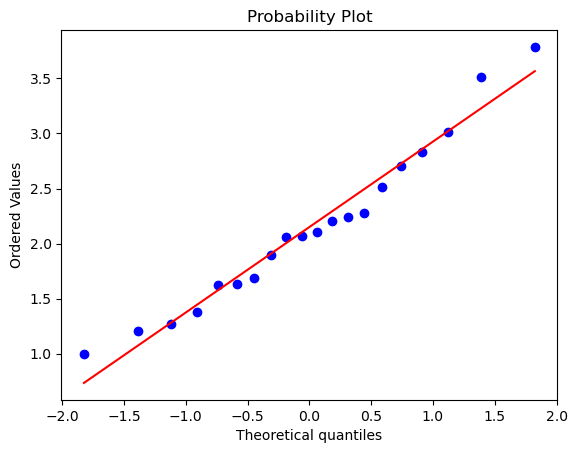

box plot data shape:  (2, 20)
out []


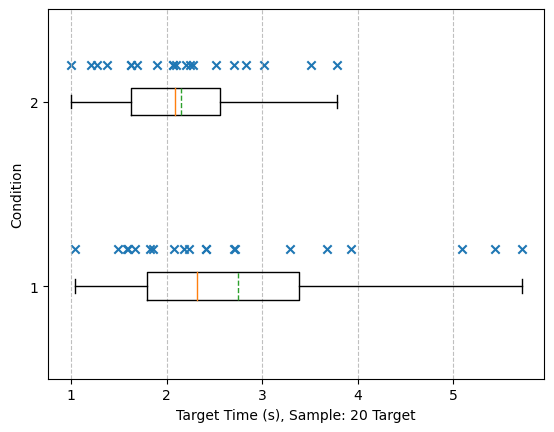

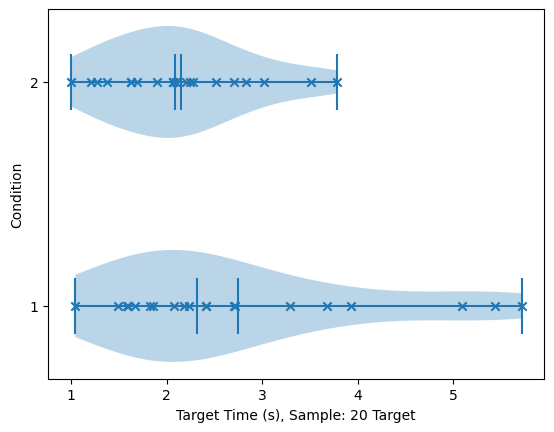

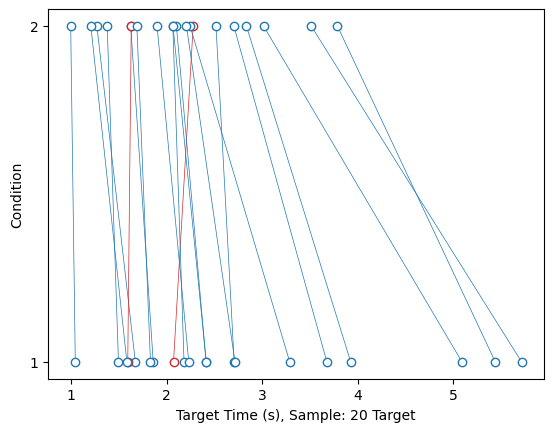

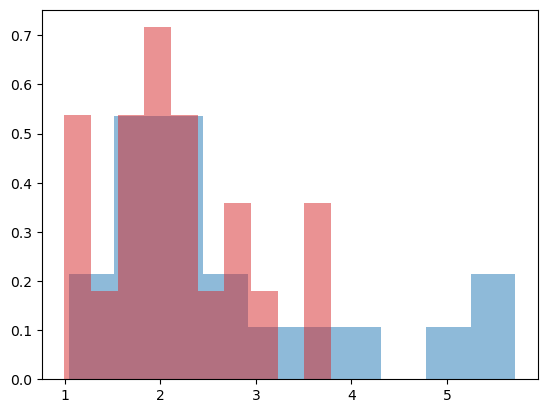

data to cal is (14, 20)
data to cal is (14, 20)
<<<<<
First Sample
DescribeResult(nobs=14, minmax=(1.5165026666666668, 4.363832500000006), mean=2.746535370238096, variance=0.5255772429154943, skewness=0.5690342551796435, kurtosis=0.1631579286824132) 
 Mean:  2.746535370238096 
 Median:  2.6022902500000007 
 STD:  0.7249670633314967 
 VAR:  0.5255772429154943


Second Sample
DescribeResult(nobs=14, minmax=(1.2618265499999983, 3.2905225000000016), mean=2.149930039285714, variance=0.25961526715300165, skewness=0.5095638290547586, kurtosis=0.22357112345935803) 
 Mean:  2.149930039285714 
 Median:  2.122051999999999 
 STD:  0.5095245500984242 
 VAR:  0.25961526715300165


First Sample
------------------------------
=== Normality Test ===
Sample Population: 14
--- Shapiro-Wilk Test ---
stat =     0.9601, p =    0.72479  not reject H0
--- D’Agostino’s K^2 Test ---
stat =     2.0171, p =    0.36475  not reject H0
--- Kolmogorov-Smirnov --
stat =    0.15523, p =    0.83914  not reject H0
--- An

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


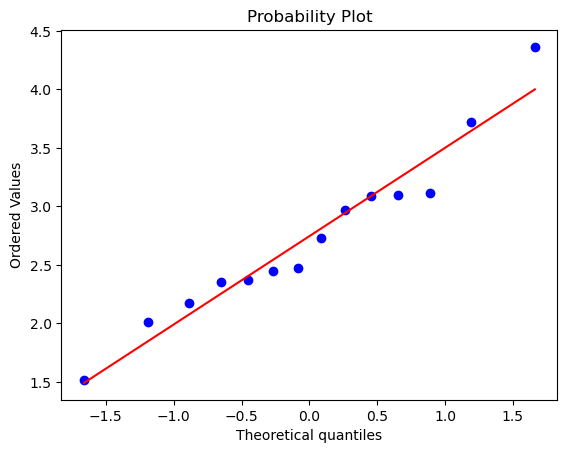

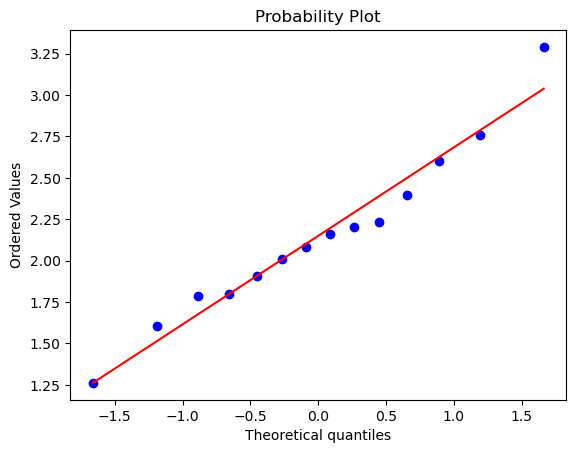

box plot data shape:  (2, 14)
out [1.]


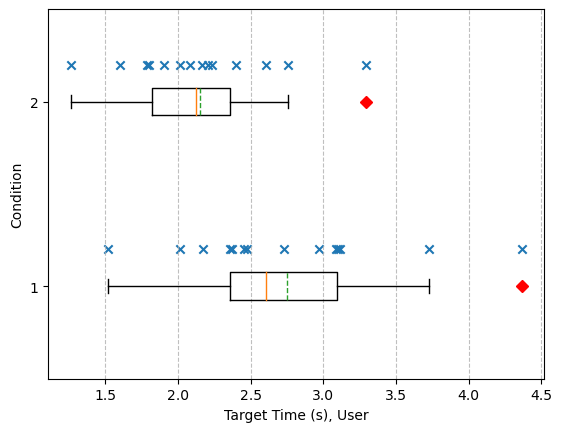

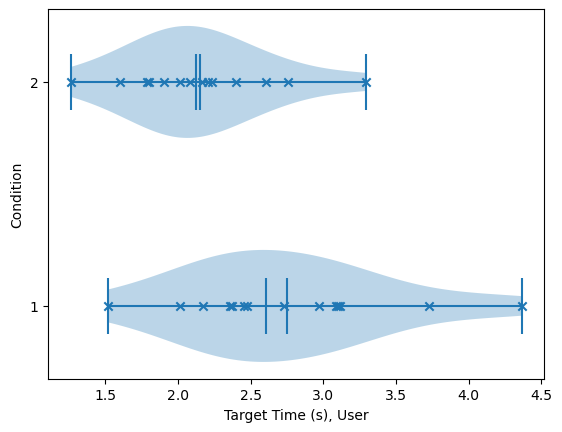

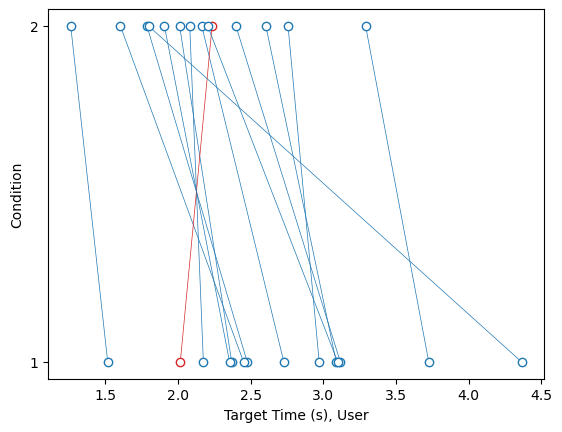

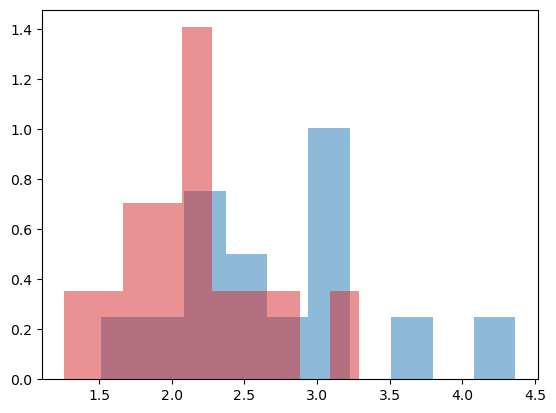


##### Target Speed #####
data to cal is (20, 1)
(20, 14)
2
data to cal is (20, 14)
data to cal is (20, 1)
(20, 14)
2
data to cal is (20, 14)
<<<<<
First Sample
DescribeResult(nobs=20, minmax=(20.018175893783983, 58.280952596241825), mean=37.9855541452215, variance=110.89562508578672, skewness=0.1767513699896406, kurtosis=-0.7205561143520076) 
 Mean:  37.9855541452215 
 Median:  38.632366167166055 
 STD:  10.530699173644013 
 VAR:  110.89562508578672


Second Sample
DescribeResult(nobs=20, minmax=(26.068787777054602, 71.19127003552838), mean=46.158136628595486, variance=200.20014589340568, skewness=0.26081888106661655, kurtosis=-1.0976823027209095) 
 Mean:  46.158136628595486 
 Median:  46.36808820152649 
 STD:  14.149210080191956 
 VAR:  200.20014589340568


First Sample
------------------------------
=== Normality Test ===
Sample Population: 20
--- Shapiro-Wilk Test ---
stat =    0.97528, p =    0.85994  not reject H0
--- D’Agostino’s K^2 Test ---
stat =    0.40206, p =    0.81789  n

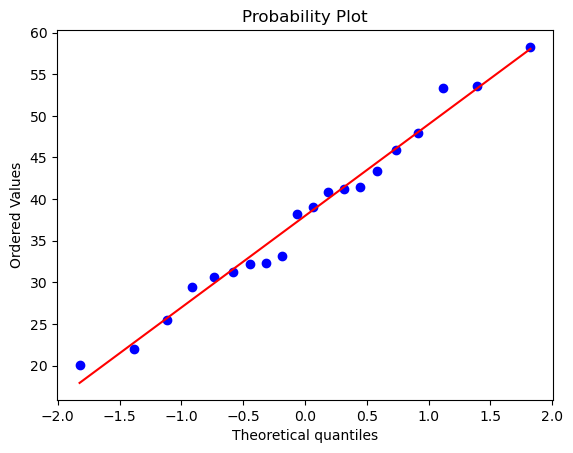

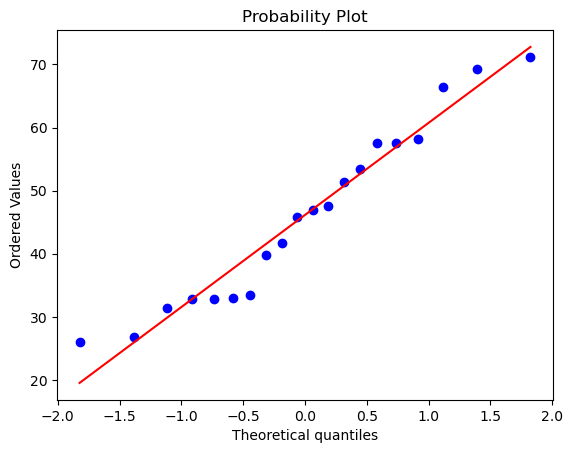

box plot data shape:  (2, 20)
out []


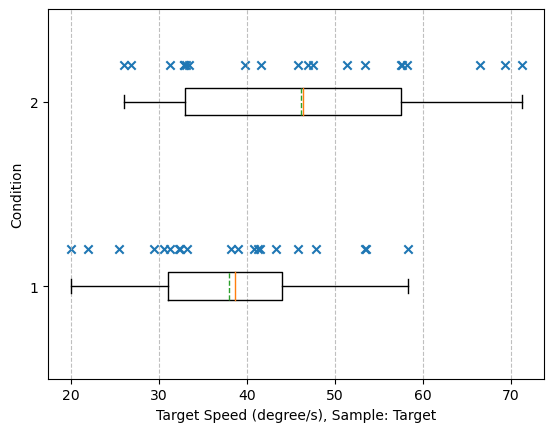

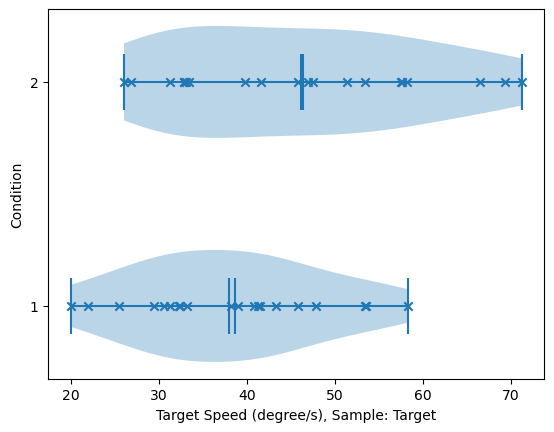

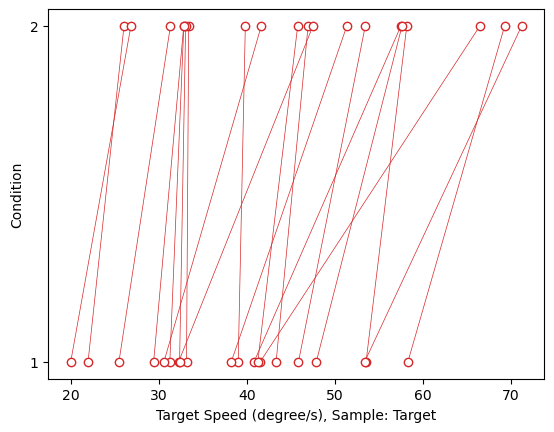

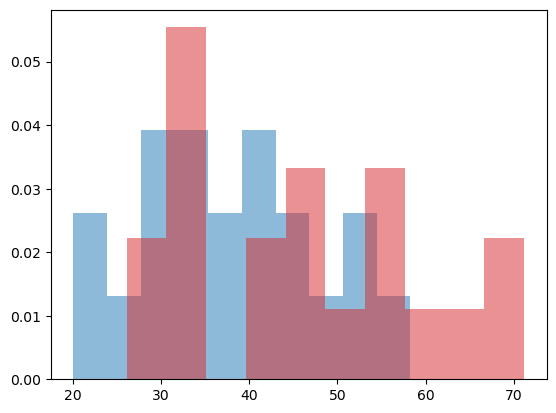

data to cal is (20, 1)
(20, 14)
2
data to cal is (14, 20)
data to cal is (20, 1)
(20, 14)
2
data to cal is (14, 20)
<<<<<
First Sample
DescribeResult(nobs=14, minmax=(22.568876814964405, 61.63393247367212), mean=37.9855541452215, variance=92.11470158095588, skewness=0.7604648971278584, kurtosis=0.8910302717555658) 
 Mean:  37.9855541452215 
 Median:  38.02513979118031 
 STD:  9.597640417360711 
 VAR:  92.11470158095588


Second Sample
DescribeResult(nobs=14, minmax=(27.360368133283185, 72.67295651552574), mean=46.15813662859548, variance=135.76586213610045, skewness=0.7879107040181168, kurtosis=0.39072109395810806) 
 Mean:  46.15813662859548 
 Median:  44.97530805518389 
 STD:  11.651860887261762 
 VAR:  135.76586213610045


First Sample
------------------------------
=== Normality Test ===
Sample Population: 14
--- Shapiro-Wilk Test ---
stat =    0.94869, p =    0.54049  not reject H0
--- D’Agostino’s K^2 Test ---
stat =     4.4429, p =    0.10845  not reject H0
--- Kolmogorov-Smirnov

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


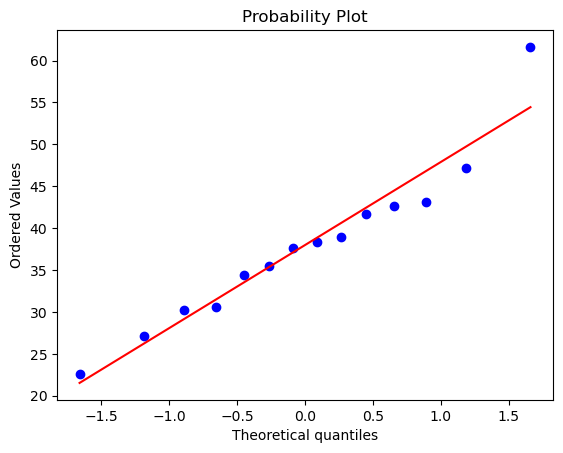

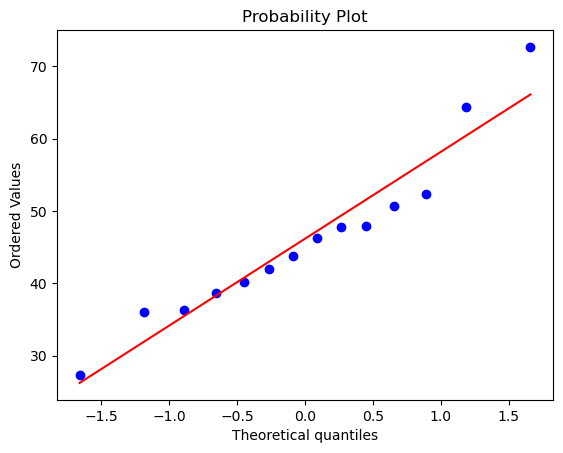

box plot data shape:  (2, 14)
out [1.]


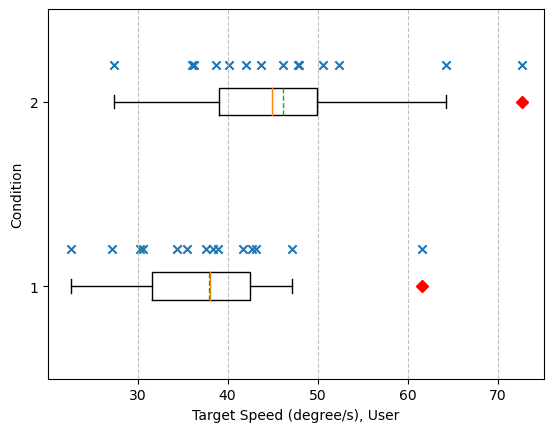

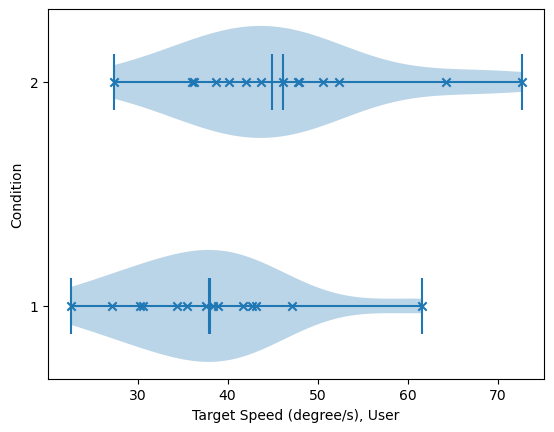

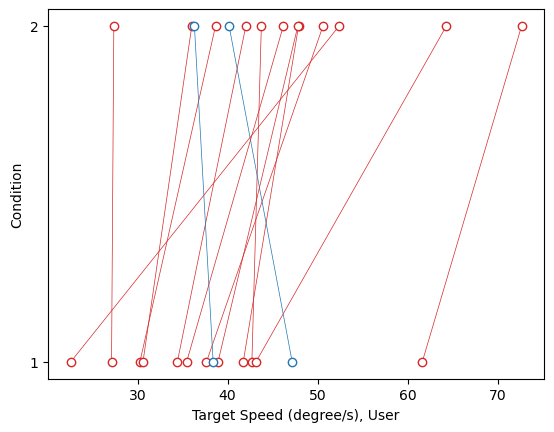

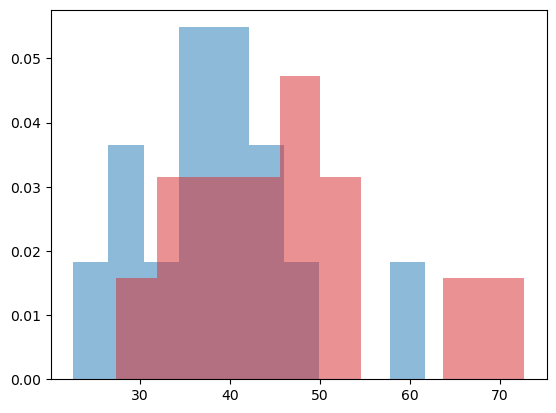

In [141]:
### Normal Test ###
## Data Distribution ##
## Box Plot ##

print("\n##### 1-2 #####")


print("\n##### Condition Time (from round) #####")
plot_normal_test(m_sum(test1.mean.time_10x4), 
                 m_sum(test2.mean.time_10x4), 
                 'Condition Time (s), User')

print("\n##### Condition Time (from target) #####")
plot_normal_test(4*np.array(m_sum(test1.mean.time_20x10.T)), 
                 4*np.array(m_sum(test2.mean.time_20x10.T)), 
                 'Condition Time (s), User')

print("\n##### Condition Speed averge(total/time) (from round) #####")
plot_normal_test(total / m_sum(test1.mean.time_10x4),
                 total / m_sum(test2.mean.time_10x4),
                 'Condition Speed (degree/s), User')

print("\n##### Condition Speed averge(total/time) (from target) #####")
plot_normal_test(total / (4*np.array(m_sum(test1.mean.time_20x10.T))),
                 total / (4*np.array(m_sum(test2.mean.time_20x10.T))),
                 'Condition Speed (degree/s), User')

print("\n##### Round Time Mean #####")
plot_normal_test(m_sum(test1.mean.time_20x10.T), 
                 m_sum(test2.mean.time_20x10.T), 
                 'Round Time (s), User')

#cal_mean_of_ratio(test1_condition, test2_condition)  

#cal_ttest_20x10(test1.mean.time_1x10, test2.mean.time_1x10)

#print("\n##### Lon Time #####")
#plot_normal_test(m_mean(test1.mean.time_7x10), 
#                 m_mean(test2.mean.time_7x10), 
#                 'Lon Time (s), Lon')

#print("\n##### Lat Time #####")
#plot_normal_test(m_mean(test1.mean.time_3x10), 
#                 m_mean(test2.mean.time_3x10), 
#                 'Lat Time (s), Lat')


print("\n##### Target Time #####")
plot_normal_test(m_mean(test1.mean.time_20x10),
                 m_mean(test2.mean.time_20x10), 
                 'Target Time (s), Sample: 20 Target')

plot_normal_test(m_mean(test1.mean.time_20x10.T),
                 m_mean(test2.mean.time_20x10.T), 
                 'Target Time (s), User')


print("\n##### Target Speed #####")
plot_normal_test(m_mean(Speed(test1.mean.time_20x10).value),
                 m_mean(Speed(test2.mean.time_20x10).value), 
                 'Target Speed (degree/s), Sample: Target')

plot_normal_test(m_mean(Speed(test1.mean.time_20x10).value.T),
                 m_mean(Speed(test2.mean.time_20x10).value.T), 
                 'Target Speed (degree/s), User')




In [130]:
print(m_sum(test3.mean.time_10x4))
print(4*np.array(m_sum(test3.mean.time_20x10.T)))

data to cal is (6, 4)
[44.535, 59.72890000000004, 44.43470000000005, 47.22129999999993, 52.72499999999968, 48.95399999999995]
data to cal is (6, 6)
[45.01670667 59.2264     44.15806667 43.9046     49.86006667 49.56926   ]



##### 3-4-5 #####

##### Condition Time (from round) #####
data to cal is (6, 4)
data to cal is (6, 4)
data to cal is (6, 4)
<<<<<
First Sample
DescribeResult(nobs=6, minmax=(44.43470000000005, 59.72890000000004), mean=49.599816666666605, variance=34.15406375766641, skewness=0.8652669325460748, kurtosis=-0.526185688224007) 
 Mean:  49.599816666666605 
 Median:  48.08764999999994 
 STD:  5.84414782133943 
 VAR:  34.15406375766641


Second Sample
DescribeResult(nobs=6, minmax=(43.80539999999979, 60.14630000000017), mean=51.754309999999954, variance=36.933018395000644, skewness=0.03771370409512655, kurtosis=-1.2797530531267267) 
 Mean:  51.754309999999954 
 Median:  52.24589999999989 
 STD:  6.077254182194508 
 VAR:  36.933018395000644


First Sample
------------------------------
=== Normality Test ===
Sample Population: 6
--- Shapiro-Wilk Test ---
stat =    0.88387, p =    0.28728  not reject H0
--- D’Agostino’s K^2 Test ---
Too small.
--- Kolmogorov-Smirnov --
stat =    0.21484, p =  

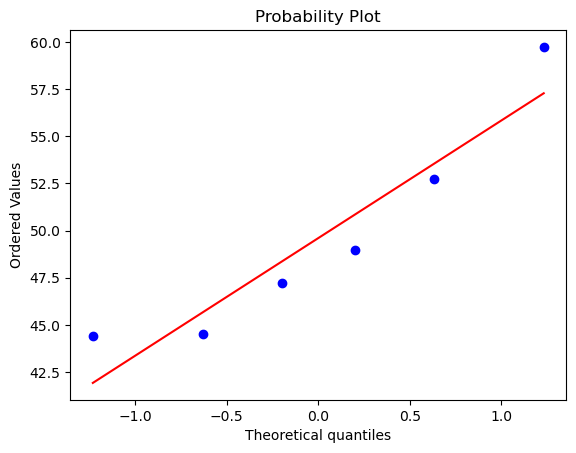

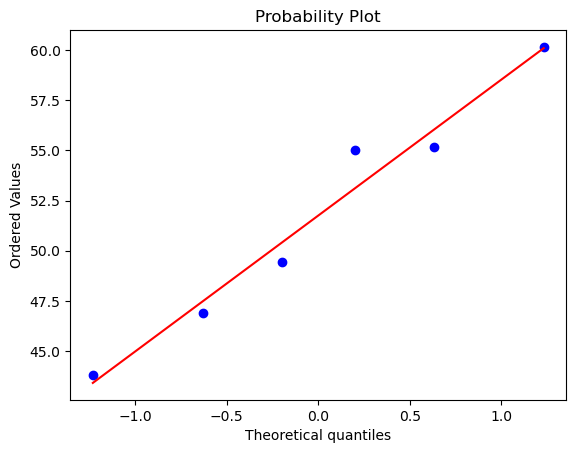

box plot data shape:  (3, 6)
out []


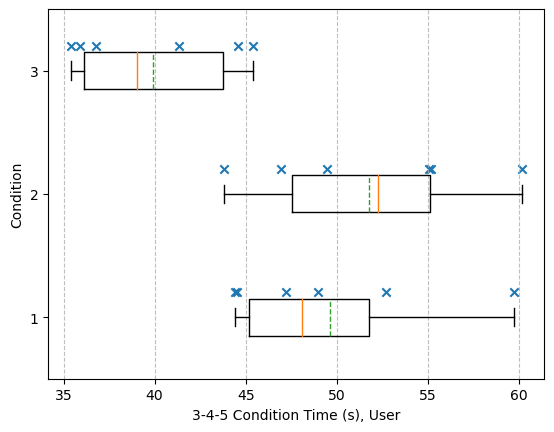

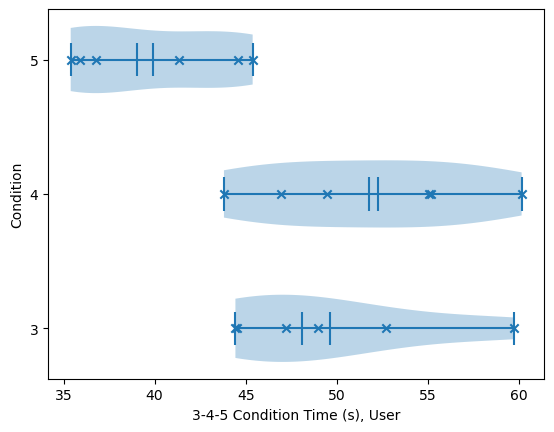

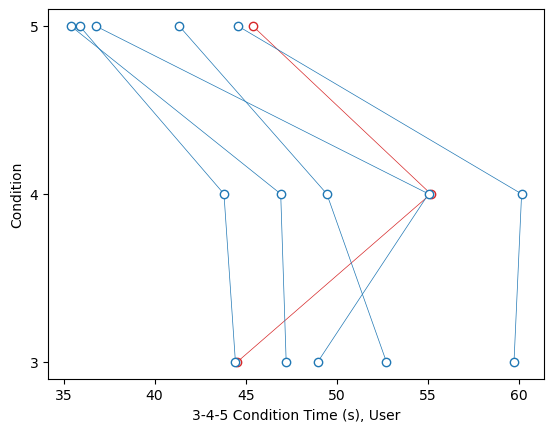

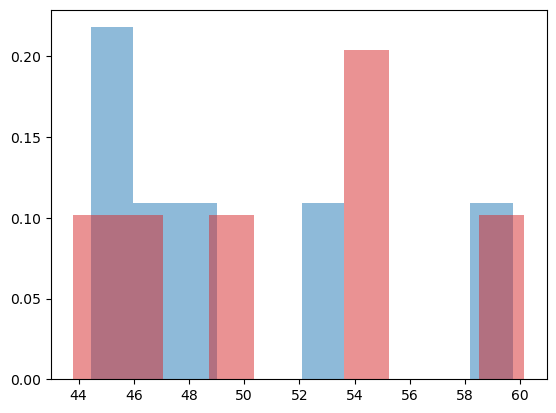


##### Condition Time (from target) #####
data to cal is (6, 6)
data to cal is (6, 6)
data to cal is (6, 6)
<<<<<
First Sample
DescribeResult(nobs=6, minmax=(10.97614999999997, 14.80660000000002), mean=12.155629166666655, variance=2.12577639901085, skewness=1.0538992608935536, kurtosis=-0.15608825455432074) 
 Mean:  12.155629166666655 
 Median:  11.823245833333322 
 STD:  1.4580042520551337 
 VAR:  2.12577639901085


Second Sample
DescribeResult(nobs=6, minmax=(10.702359999999931, 14.307320000000027), mean=12.614719658730145, variance=2.0104880497289095, skewness=-0.1581186027225192, kurtosis=-1.4636090164864006) 
 Mean:  12.614719658730145 
 Median:  12.74592607142855 
 STD:  1.4179167992970918 
 VAR:  2.0104880497289095


First Sample
------------------------------
=== Normality Test ===
Sample Population: 6
--- Shapiro-Wilk Test ---
stat =    0.82625, p =   0.099883  not reject H0
--- D’Agostino’s K^2 Test ---
Too small.
--- Kolmogorov-Smirnov --
stat =    0.25089, p =    0.76587  n

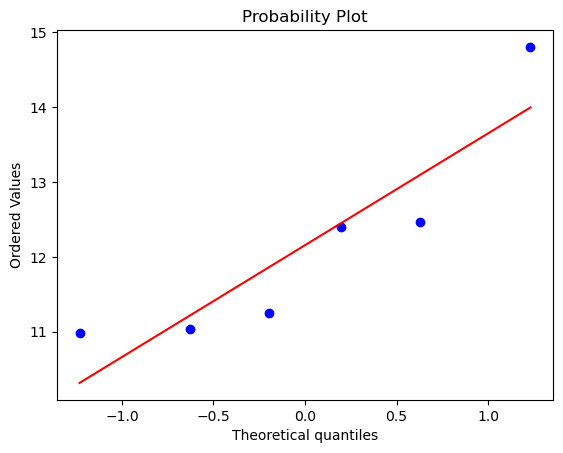

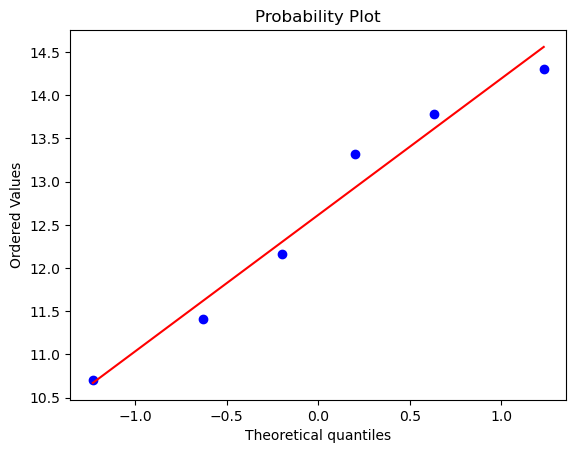

box plot data shape:  (3, 6)
out [1.]


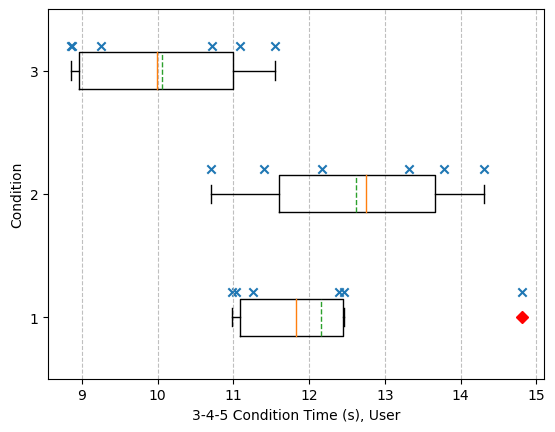

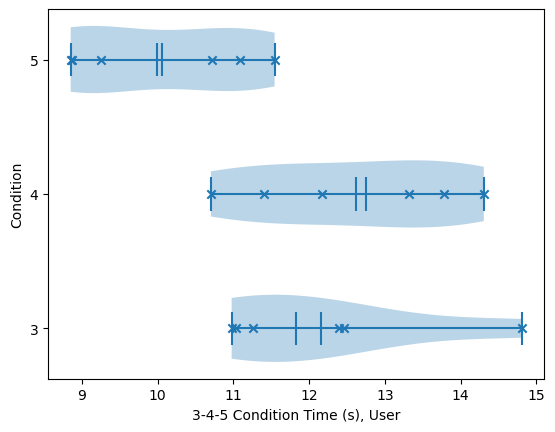

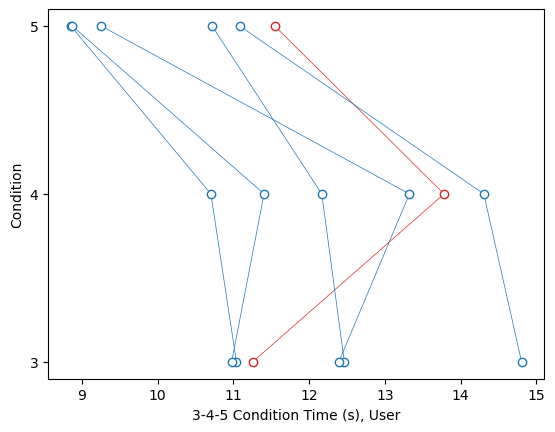

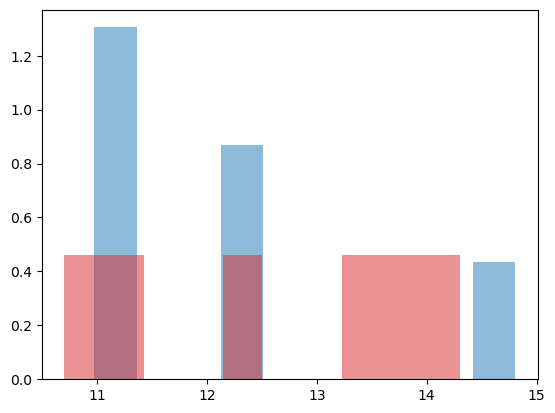


##### Condition Speed #####
data to cal is (6, 4)
data to cal is (6, 4)
data to cal is (6, 4)
<<<<<
First Sample
DescribeResult(nobs=6, minmax=(42.190631335919434, 56.71243420119855), mean=51.35426375673412, variance=31.353601113724675, skewness=-0.6358294238631459, kurtosis=-0.8513727553766479) 
 Mean:  51.35426375673412 
 Median:  52.42132238126803 
 STD:  5.599428641720928 
 VAR:  31.353601113724675


Second Sample
DescribeResult(nobs=6, minmax=(41.89783910232205, 57.52715418647043), mean=49.259971621320254, variance=34.012979324907356, skewness=0.18908706142080423, kurtosis=-1.2744631351634206) 
 Mean:  49.259971621320254 
 Median:  48.37167836683189 
 STD:  5.832064756576984 
 VAR:  34.012979324907356


First Sample
------------------------------
=== Normality Test ===
Sample Population: 6
--- Shapiro-Wilk Test ---
stat =    0.91414, p =    0.46419  not reject H0
--- D’Agostino’s K^2 Test ---
Too small.
--- Kolmogorov-Smirnov --
stat =    0.18024, p =    0.96864  not reject H0
--

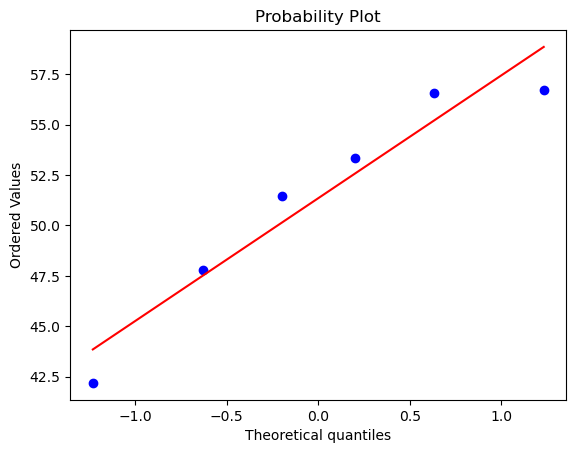

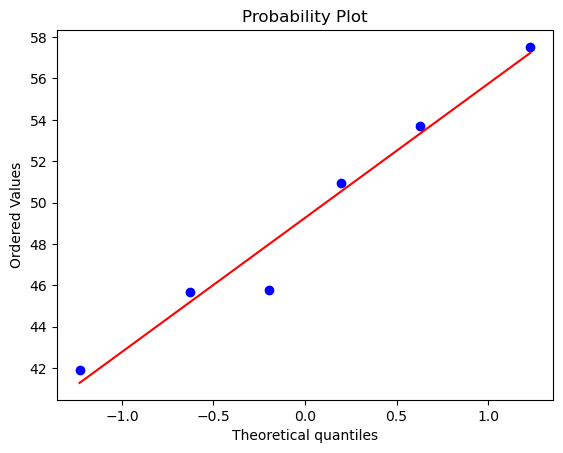

box plot data shape:  (3, 6)
out []


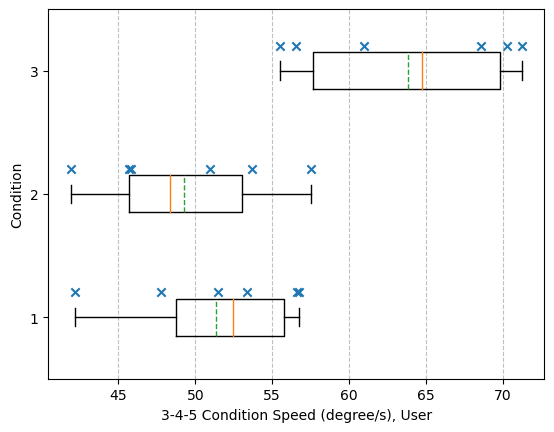

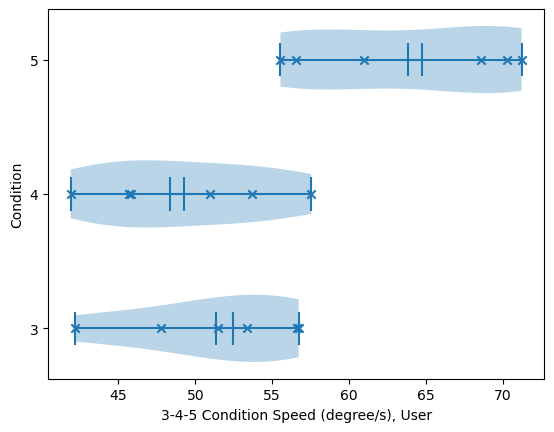

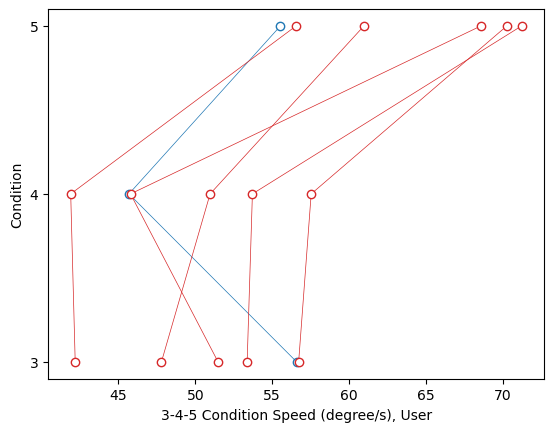

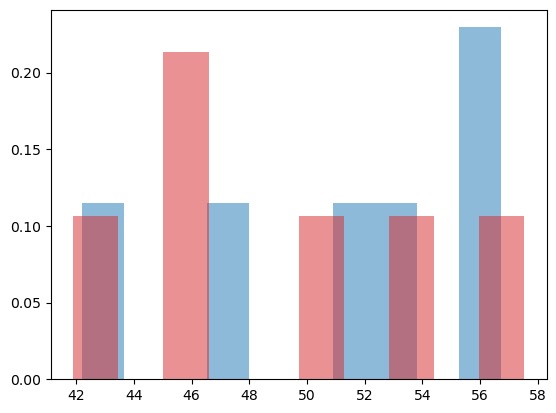


##### Target Time #####
data to cal is (6, 6)
data to cal is (6, 6)
data to cal is (6, 6)
<<<<<
First Sample
DescribeResult(nobs=6, minmax=(1.8293583333333283, 2.46776666666667), mean=2.0259381944444423, variance=0.05904934441696803, skewness=1.0538992608935547, kurtosis=-0.1560882545543194) 
 Mean:  2.0259381944444423 
 Median:  1.9705409722222205 
 STD:  0.24300070867585558 
 VAR:  0.05904934441696803


Second Sample
DescribeResult(nobs=6, minmax=(1.7837266666666551, 2.3845533333333377), mean=2.1024532764550243, variance=0.05584689027024746, skewness=-0.15811860272252254, kurtosis=-1.4636090164863997) 
 Mean:  2.1024532764550243 
 Median:  2.124321011904758 
 STD:  0.23631946654951524 
 VAR:  0.05584689027024746


First Sample
------------------------------
=== Normality Test ===
Sample Population: 6
--- Shapiro-Wilk Test ---
stat =    0.82625, p =   0.099883  not reject H0
--- D’Agostino’s K^2 Test ---
Too small.
--- Kolmogorov-Smirnov --
stat =    0.25089, p =    0.76587  not reje

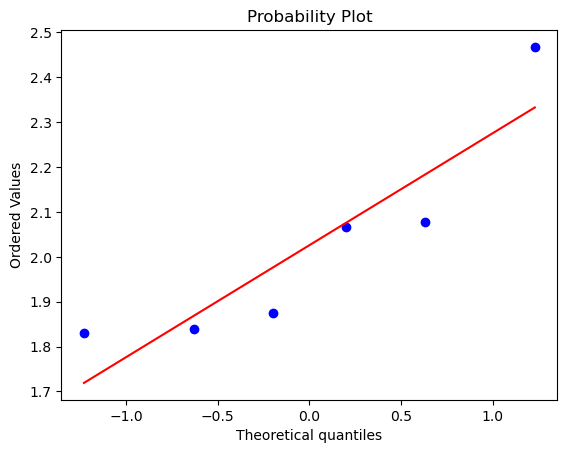

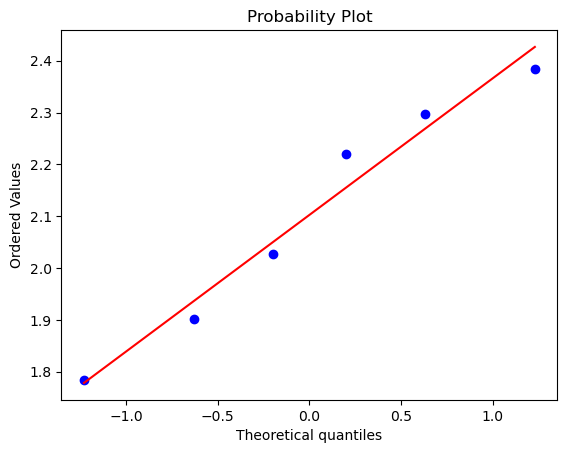

box plot data shape:  (3, 6)
out [1.]


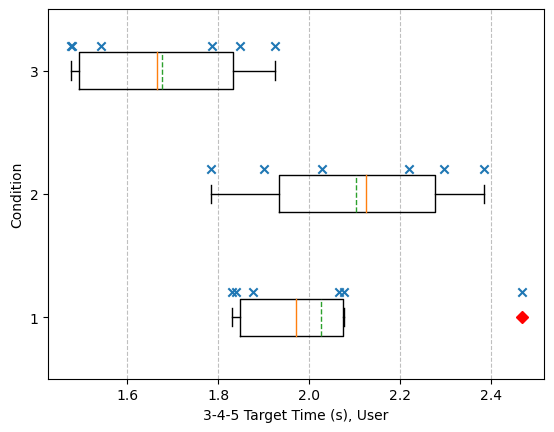

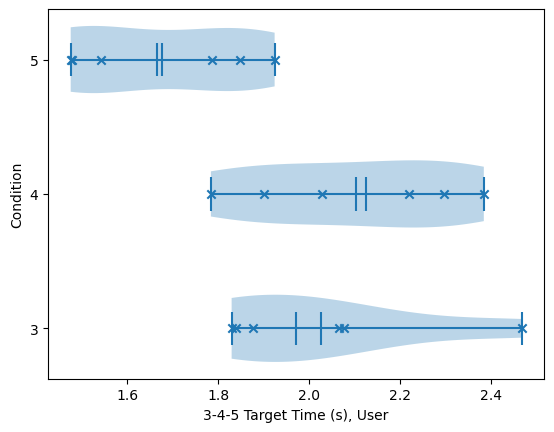

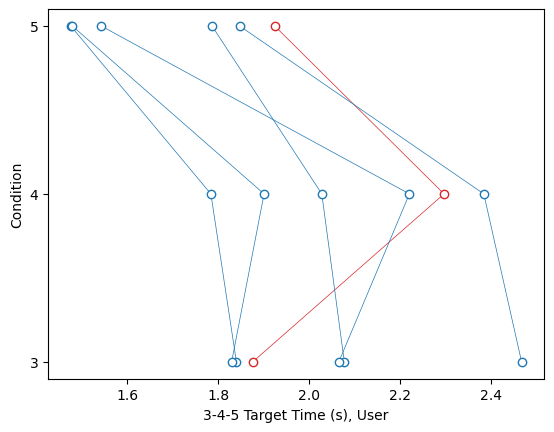

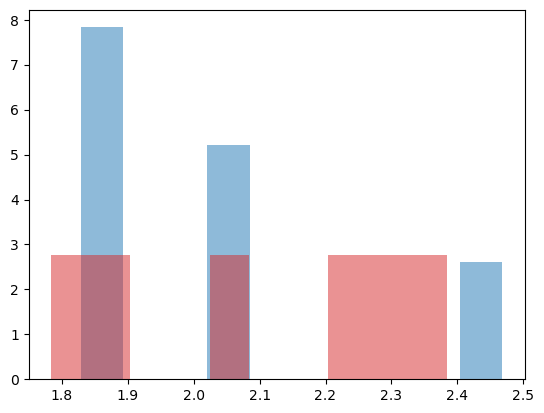

data to cal is (6, 6)
data to cal is (6, 6)
data to cal is (6, 6)
<<<<<
First Sample
DescribeResult(nobs=6, minmax=(1.2239861111111052, 3.2028255555555636), mean=2.025938194444442, variance=0.500067874768827, skewness=0.6597084402150691, kurtosis=-0.6874935058020912) 
 Mean:  2.025938194444442 
 Median:  1.8497220833333299 
 STD:  0.7071547742671522 
 VAR:  0.500067874768827


Second Sample
DescribeResult(nobs=6, minmax=(1.2923425396825368, 3.3796970317460295), mean=2.1024532764550243, variance=0.5372651386108181, skewness=0.802864682682821, kurtosis=-0.3789038438668224) 
 Mean:  2.1024532764550243 
 Median:  1.9539022380952327 
 STD:  0.7329837232918738 
 VAR:  0.5372651386108181


First Sample
------------------------------
=== Normality Test ===
Sample Population: 6
--- Shapiro-Wilk Test ---
stat =    0.94651, p =    0.71193  not reject H0
--- D’Agostino’s K^2 Test ---
Too small.
--- Kolmogorov-Smirnov --
stat =    0.19768, p =    0.93736  not reject H0
--- Anderson-Darling Test ---

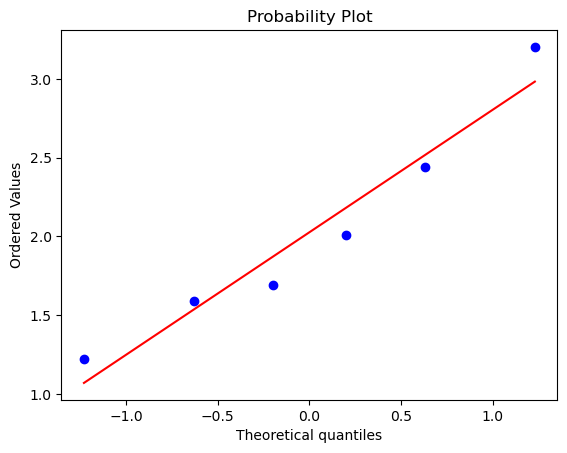

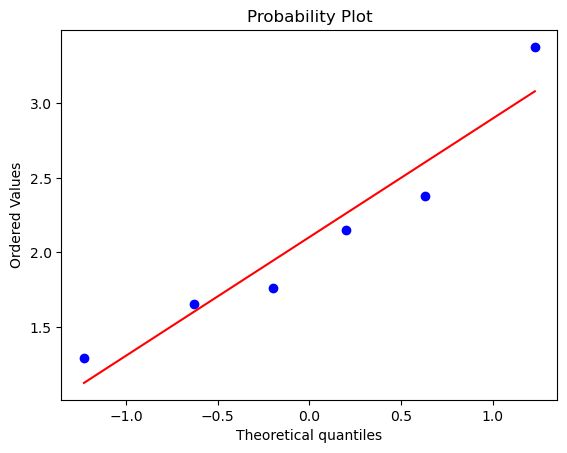

box plot data shape:  (3, 6)
out []


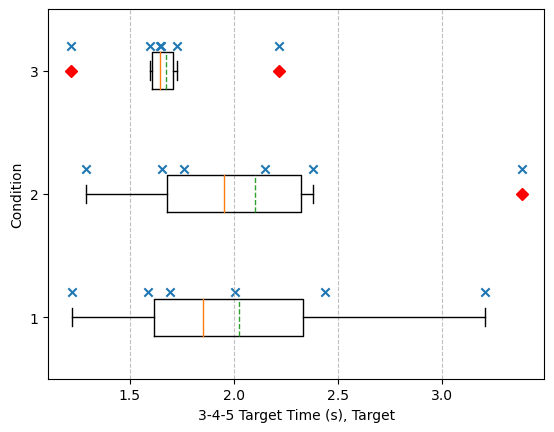

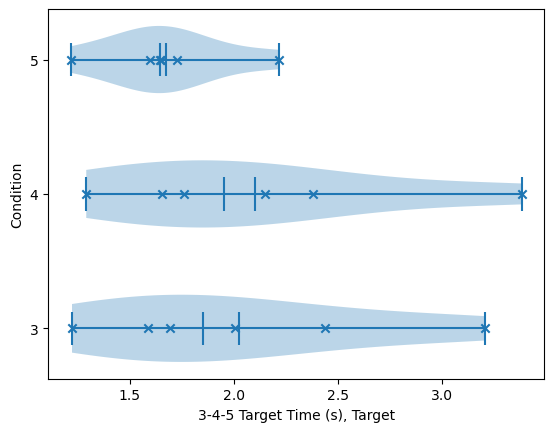

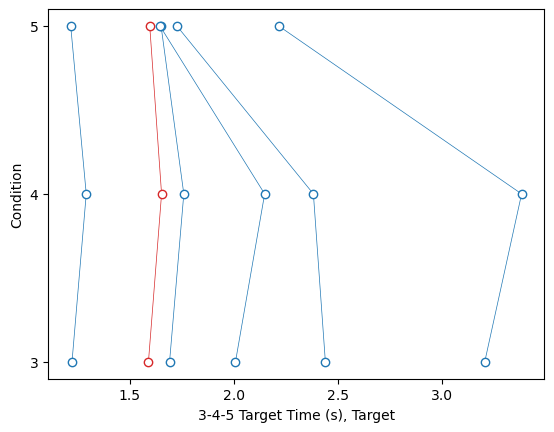

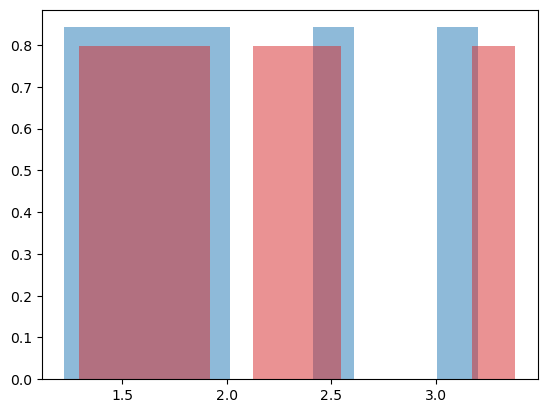


##### Target Speed #####
data to cal is (20, 1)
(6, 6)
2
data to cal is (6, 6)
data to cal is (20, 1)
(6, 6)
2
data to cal is (6, 6)
data to cal is (20, 1)
(6, 6)
2
data to cal is (6, 6)
<<<<<
First Sample
DescribeResult(nobs=6, minmax=(23.762732995585655, 87.86126551714032), mean=55.82268776308896, variance=661.2917629595861, skewness=-0.1477634875774943, kurtosis=-1.455520452741998) 
 Mean:  55.82268776308896 
 Median:  59.709938289728996 
 STD:  25.715593770309603 
 VAR:  661.2917629595861


Second Sample
DescribeResult(nobs=6, minmax=(19.162103833449354, 80.1174909317521), mean=54.24513621641864, variance=609.6308603702826, skewness=-0.41732366566028545, kurtosis=-1.3903085928115861) 
 Mean:  54.24513621641864 
 Median:  60.4125092147955 
 STD:  24.690703926180042 
 VAR:  609.6308603702826


First Sample
------------------------------
=== Normality Test ===
Sample Population: 6
--- Shapiro-Wilk Test ---
stat =    0.93428, p =    0.61354  not reject H0
--- D’Agostino’s K^2 Test ---

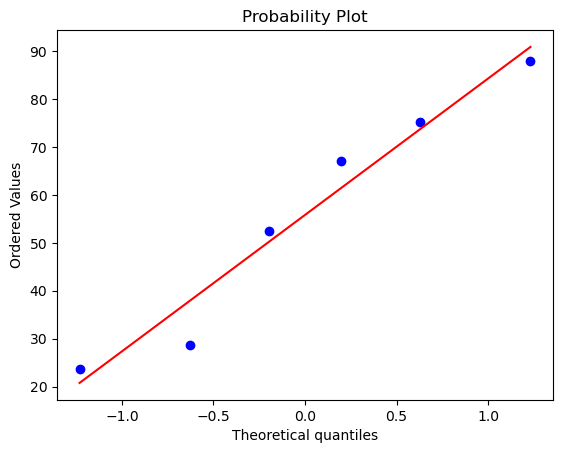

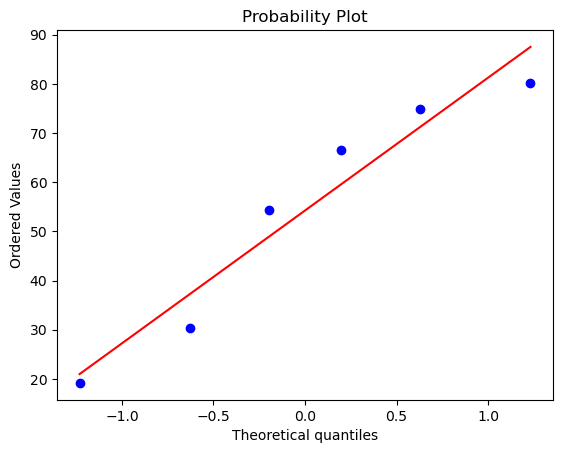

box plot data shape:  (3, 6)
out []


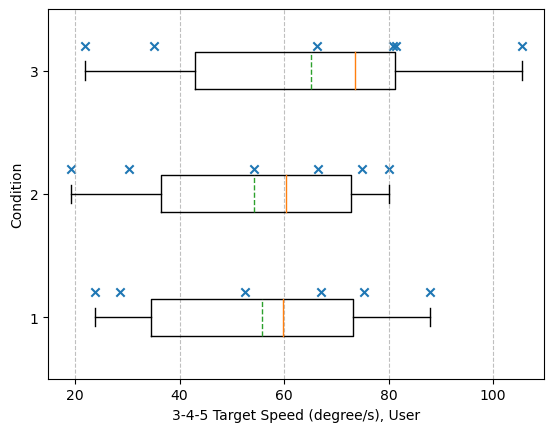

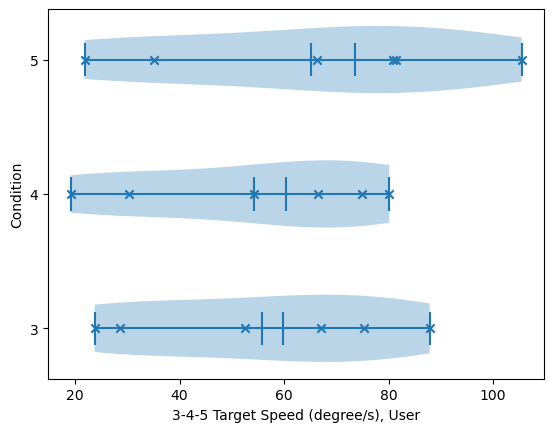

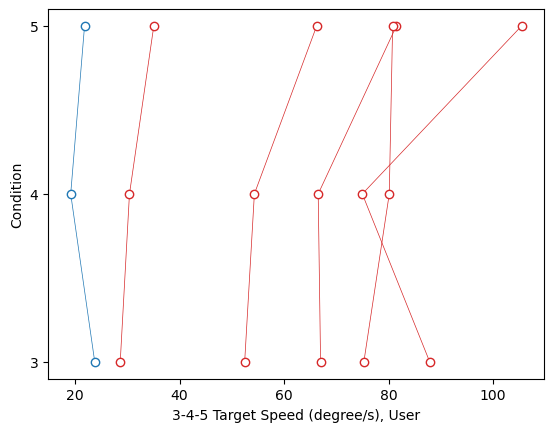

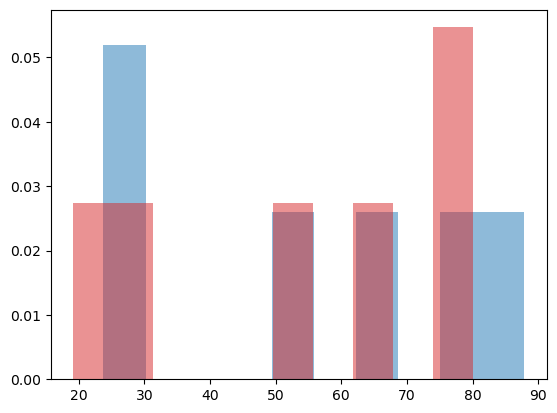

data to cal is (20, 1)
(6, 6)
2
data to cal is (6, 6)
data to cal is (20, 1)
(6, 6)
2
data to cal is (6, 6)
data to cal is (20, 1)
(6, 6)
2
data to cal is (6, 6)
<<<<<
First Sample
DescribeResult(nobs=6, minmax=(34.41982030206497, 57.88071100524481), mean=48.96524437779209, variance=89.93280463688014, skewness=-0.5604891260321883, kurtosis=-1.2001043191737877) 
 Mean:  48.96524437779209 
 Median:  51.62007173349252 
 STD:  9.48329081262829 
 VAR:  89.93280463688014


Second Sample
DescribeResult(nobs=6, minmax=(32.350778142146076, 59.00969331293357), mean=47.50108894920212, variance=106.11723260054964, skewness=-0.35398489891433865, kurtosis=-1.282522019192864) 
 Mean:  47.50108894920212 
 Median:  49.18976576031166 
 STD:  10.30132188607606 
 VAR:  106.11723260054964


First Sample
------------------------------
=== Normality Test ===
Sample Population: 6
--- Shapiro-Wilk Test ---
stat =    0.89707, p =    0.35688  not reject H0
--- D’Agostino’s K^2 Test ---
Too small.
--- Kolmogorov-

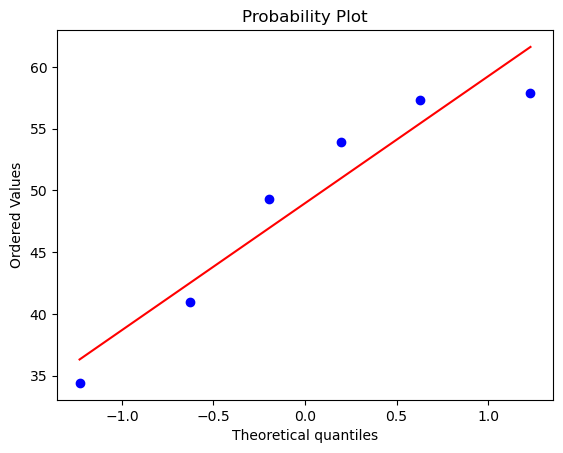

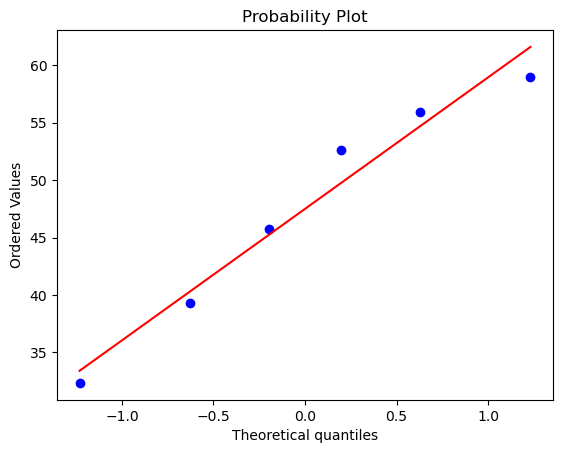

box plot data shape:  (3, 6)
out []


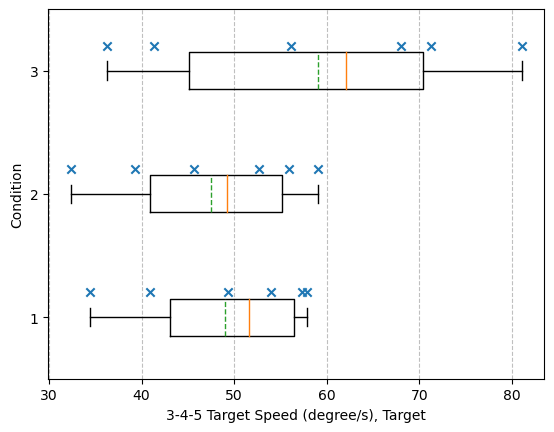

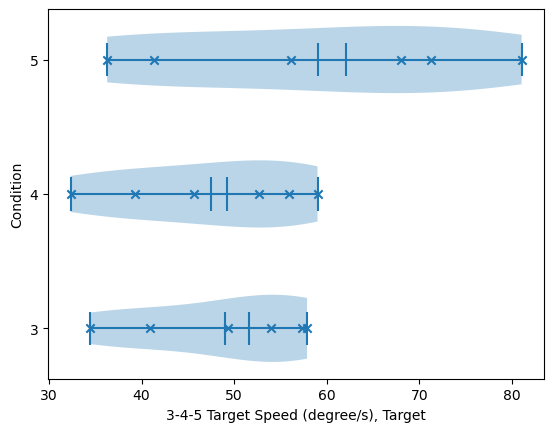

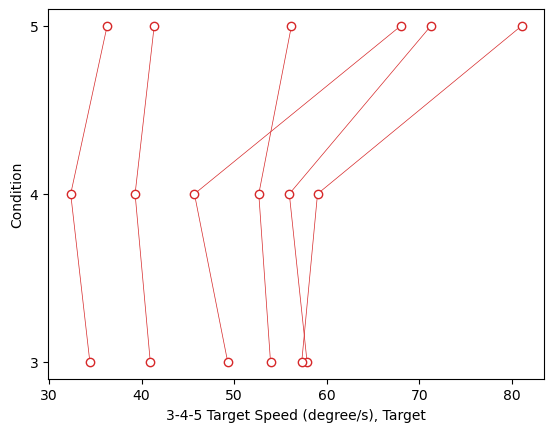

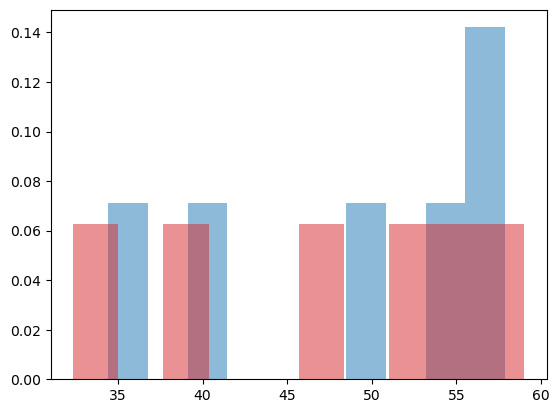

In [135]:
print("\n##### 3-4-5 #####")

print("\n##### Condition Time (from round) #####")
plot_normal_test(m_sum(test3.mean.time_10x4), 
                 m_sum(test4.mean.time_10x4),
                 '3-4-5 Condition Time (s), User', 
                 m_sum(test5.mean.time_10x4))

print("\n##### Condition Time (from target) #####")
plot_normal_test(m_sum(test3.mean.time_20x10.T), 
                 m_sum(test4.mean.time_20x10.T),
                 '3-4-5 Condition Time (s), User', 
                 m_sum(test5.mean.time_20x10.T))

print("\n##### Condition Speed #####")
plot_normal_test(np.sum(LON_KEY_F)*4 / m_sum(test3.mean.time_10x4), 
                 np.sum(LON_KEY_F)*4 / m_sum(test4.mean.time_10x4),
                 '3-4-5 Condition Speed (degree/s), User', 
                 np.sum(LON_KEY_F)*4 / m_sum(test5.mean.time_10x4))


print("\n##### Target Time #####")
plot_normal_test(m_mean(test3.mean.time_20x10.T),
                 m_mean(test4.mean.time_20x10.T), 
                 '3-4-5 Target Time (s), User',
                 m_mean(test5.mean.time_20x10.T))

plot_normal_test(m_mean(test3.mean.time_20x10),
                 m_mean(test4.mean.time_20x10), 
                 '3-4-5 Target Time (s), Target',
                 m_mean(test5.mean.time_20x10))


print("\n##### Target Speed #####")
plot_normal_test(m_mean(Speed(test3.mean.time_20x10.T).value),
                 m_mean(Speed(test4.mean.time_20x10.T).value), 
                 '3-4-5 Target Speed (degree/s), User',
                 m_mean(Speed(test5.mean.time_20x10.T).value))

plot_normal_test(m_mean(Speed(test3.mean.time_20x10).value),
                 m_mean(Speed(test4.mean.time_20x10).value), 
                 '3-4-5 Target Speed (degree/s), Target',
                 m_mean(Speed(test5.mean.time_20x10).value))



In [136]:
### Bar Plot ###


from matplotlib.ticker import NullFormatter

def plot_bar_single(input_mean, ymin=None, ymax=None, x_title=None, y_title=None, z_title=None):
    
    print(np.array(input_mean).shape)
    
    if (np.array(input_mean).shape == (3,7)):
        mean=input_mean
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
        str1='('
        str2=','
        str3=')'
       
    elif (np.array(input_mean).shape == (7,3)):
        mean=np.array(input_mean).T
        key1=['C3-C4', 'C3-C5', 'C4-C5']
        key2=[0, 30, 60, 90, 120, 150, 180]
        str1=''
        str2=' (0,'
        str3=')'
        
    elif (len(input_mean[0])>7):
        mean=input_mean
        key1=['User']
        key2=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]
        str1=''
        str2='-'
        str3=''

    fig, ax = plt.subplots()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    #if (len(key1) ==3 or len(key1) ==7):
    #    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    #else:
    #    width = 5
    wwidth = 10
    width = 10 / (len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = (wwidth)*k1 + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x, mean[k1][k2], 2*width, #label=str(key2[k2]
                    color= str(0.7-0.05*k2) )
                    #alpha=1-opacity*k2)
            
            x_axis.append(x)
            x_label.append(str1+str(key1[k1])+str2+str(key2[k2])+str3)
            #x_label.append((key1[k1],key2[k2]))
    
    
    yref1=0.01
    yref2=0.05
    yref3=0.1
    plt.axhline(y=yref1,linewidth=1, color='C1')
    plt.axhline(y=yref2,linewidth=1, color='C1')
    plt.axhline(y=yref3,linewidth=1, color='C1')
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    plt.yscale('log')
    ax.set_axisbelow(True)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    if z_title is not None:
        ax.legend(title=z_title)
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    ax.set_ylim(ymin, ymax)
    plt.xticks(x_axis, x_label, rotation=90)
    
    export_img('barsingle')
    plt.show()





def plot_bar_dual_any(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None):
    
    key1, key2 = which_axis(input_mean_1)
    
    mean_1 = input_mean_1
    mean_2 = input_mean_2
    
    std_1 = input_std_1 if (input_std_1 is not None) else np.zeros_like[mean_1]
    std_2 = input_std_2 if (input_std_2 is not None) else np.zeros_like[mean_2]


    plt.figure(1, figsize = (12,16))  
    fig, ax = plt.subplots()
    
    #plt.subplot(2, 1, 1)
    #ax = plt.gca()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    
    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean_1[k1][k2], width, #label=str(key2[k2]
                    color="C0", alpha=1-opacity*k2, yerr=std_1[k1][k2])
            plt.bar(x + offset , mean_2[k1][k2], width,
                    color="C3", alpha=1-opacity*k2, yerr=std_2[k1][k2])
            
            x_axis.append(x+0.5*offset)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))
    
    plt.bar(1,0,1, color="C0", label="C1")
    plt.bar(2,0,1, color="C3", label="C2")
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_ylabel(y_title)
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    ax.legend(title="Condition")
    
    plt.xticks(x_axis, x_label, rotation=90)
    
    export_img('barplot')
    plt.show()

data to cal is (20, 1)
(3, 7, 14)
3
data to cal is (3, 7, 14)
data to cal is (20, 1)
(3, 7, 14)
3
data to cal is (3, 7, 14)
data to cal is (20, 1)
(3, 7, 14)
3
data to cal is (3, 7, 14)
data to cal is (20, 1)
(3, 7, 14)
3
data to cal is (3, 7, 14)


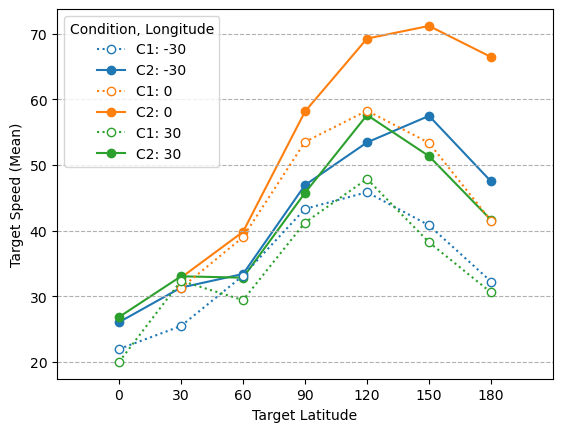

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


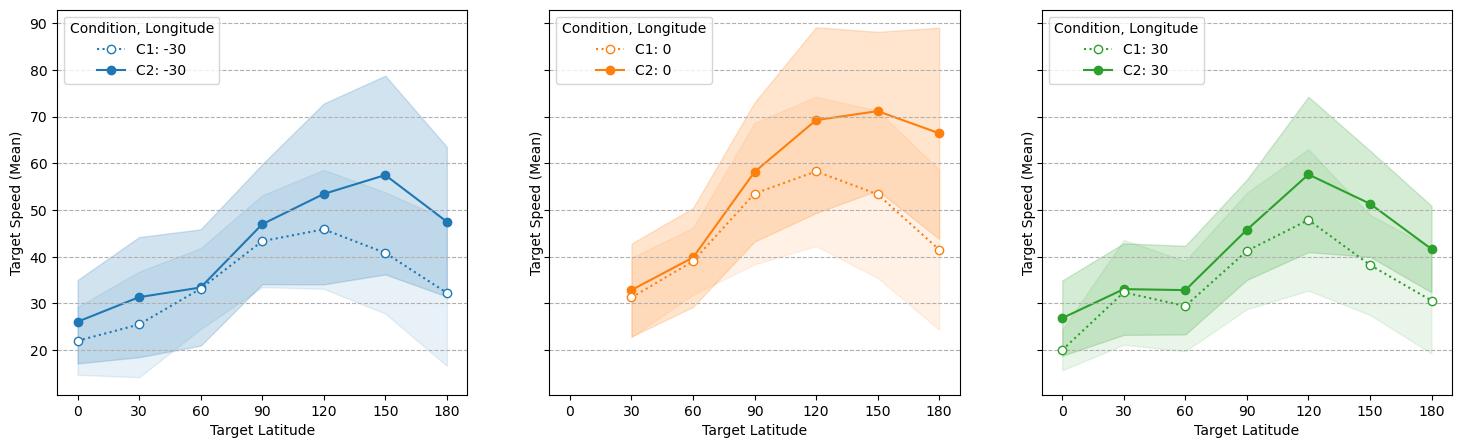

(3, 7)
#####
ratio [[1.18579939 1.22947995 1.00747961 1.08372475 1.16526666 1.40840874
  1.47260456]
 [1.         1.05079347 1.02068043 1.08637955 1.18846221 1.33382325
  1.60090924]
 [1.34143496 1.0211279  1.11617599 1.10983866 1.20328104 1.34313683
  1.36122435]]
#####
log [[0.24585996 0.29804821 0.01075064 0.11599838 0.22066014 0.49406609
  0.55837007]
 [0.         0.07147914 0.02953124 0.11952823 0.24909603 0.41556751
  0.67889152]
 [0.42377711 0.03016357 0.15856451 0.15034996 0.26697364 0.42560628
  0.44490486]]
#####
RATIO!!
remove one


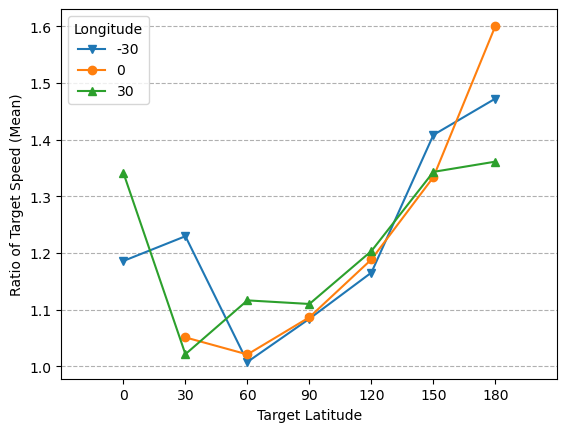

LOG!!
remove zero


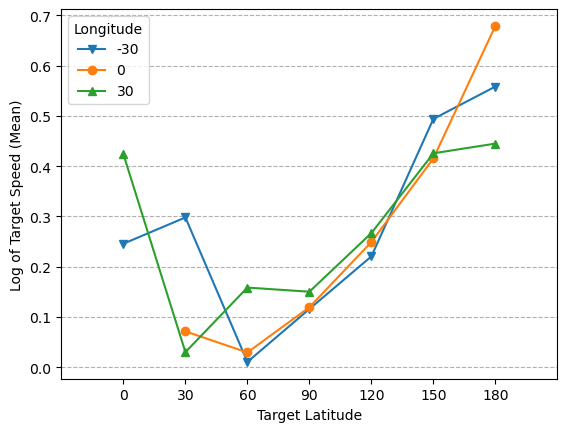

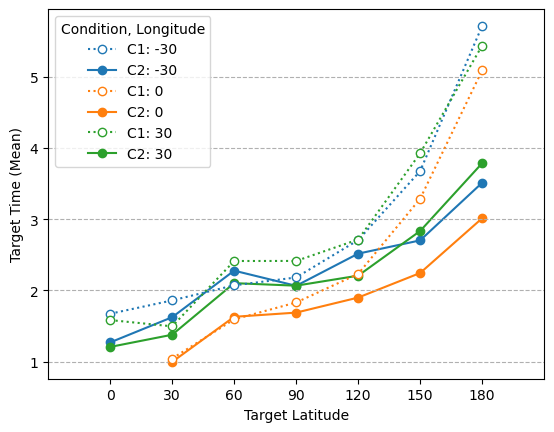

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


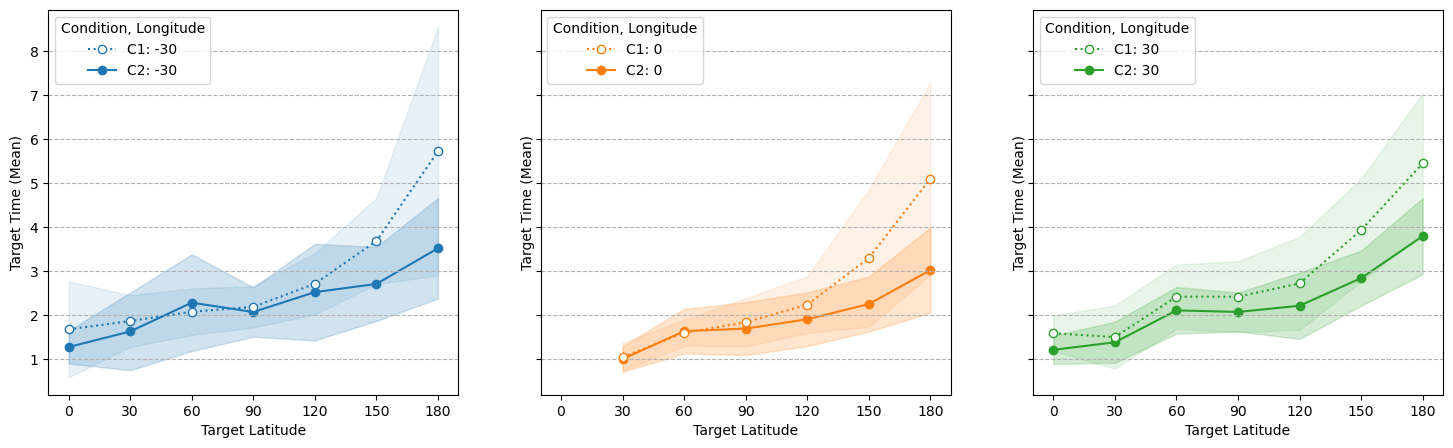

(3, 7)
#####
ratio [[0.75883312 0.87297719 1.09942897 0.94622594 0.92971982 0.73500844
  0.61446326]
 [1.         0.95401811 1.02303662 0.92218823 0.85114734 0.68253641
  0.59187685]
 [0.76153885 0.92110537 0.87098394 0.8559094  0.81290321 0.72180276
  0.69609722]]
#####
log [[-0.39814545 -0.19598414  0.1367544  -0.07974339 -0.10513209 -0.44416727
  -0.70260135]
 [ 0.         -0.06791144  0.03285779 -0.11686685 -0.2325192  -0.55102208
  -0.75663107]
 [-0.39301046 -0.1185619  -0.19928197 -0.22447    -0.29884452 -0.47032344
  -0.52263928]]
#####
RATIO!!
remove one


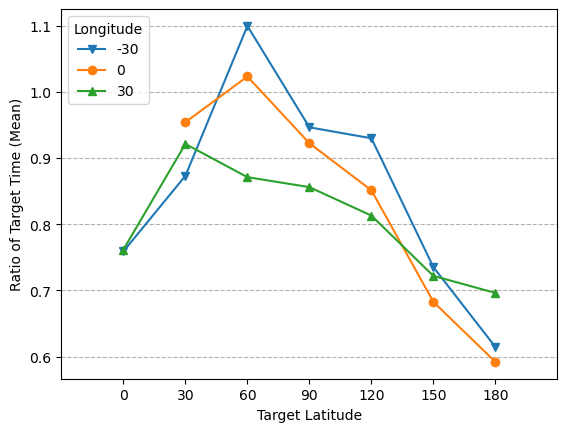

LOG!!
remove zero


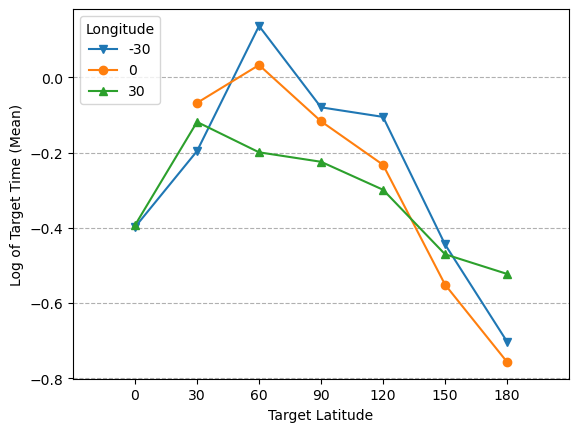

In [146]:
### Line Plot ###

    

    

def plot_line_dual_any(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None, ctype=None): 
    
    if (ctype=="345"):
        mode345=True
    else:
        mode345=False
        
    key1, key2 = which_axis(input_mean_1)
    
    #std_0 = np.zeros_like[input_mean_1]
    
    std_1 = input_std_1 if (input_std_1 is not None) else np.zeros_like(input_mean_1)
    std_2 = input_std_2 if (input_std_2 is not None) else np.zeros_like(input_mean_2)
    
    mean_1 = input_mean_1
    mean_2 = input_mean_2
    
    fig0, ax0 = plt.subplots()


    #if (np.array(mean_1).shape == (7,3)):
    
    m_style = dict(markerfacecolor='white', markeredgewidth =2)
    
    if (not mode345):
        
        for k1 in range(len(key1)):
            if (0 in mean_1[k1]):
                data_1= list(mean_1[k1])[:]
                data_2= list(mean_2[k1])[:]
                data_1.remove(0.)
                data_2.remove(0.)
                kkey = key2[:]
                kkey.remove(0)
                
                
                plt.plot(kkey, data_1, ':o', color = 'C'+ str(k1), 
                     markerfacecolor='white', markeredgewidth =1, zorder=5,
                     label='C1: ' + str(key1[k1]))
                plt.plot(kkey, data_2, '-o', color = 'C'+ str(k1), zorder=0,
                         label='C2: ' + str(key1[k1]))
            else:
                plt.plot(key2, mean_1[k1], ':o', color = 'C'+ str(k1),
                         markerfacecolor='white', markeredgewidth =1, zorder=5,
                         label='C1: ' + str(key1[k1]))
                plt.plot(key2, mean_2[k1], '-o', color = 'C'+ str(k1), zorder=0,
                         label='C2: ' + str(key1[k1]))
     
    else:
        count=3
        for k1 in range(len(key1)):
            if (0 in mean_1[k1]):
                data_1= list(mean_1[k1])[:]
                data_2= list(mean_2[k1])[:]
                data_1.remove(0.)
                data_2.remove(0.)
                kkey = key2[:]
                kkey.remove(0)
                
                plt.plot(kkey, data_2, '-o', color = 'C'+ str(k1), zorder=0,
                         label='C' + str(count) + ': ' + str(key1[k1]))
            else:

                plt.plot(key2, mean_2[k1], '-o', color = 'C'+ str(k1), zorder=0,
                         label='C' + str(count) + ': ' + str(key1[k1]))
            
            count = count+1
        
        
    ax0 = plt.gca()
    ax0.yaxis.grid(True, linestyle = "--")
    if (mode345):
        ax0.legend(title="Condition", loc=2)
    else:
        ax0.legend(title="Condition, Longitude", loc=2)
    ax0.set_ylabel(y_title)
    ax0.set_xlabel('Target Latitude')
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    export_img('three')
    plt.show()
    
    input_not_equal=True
    
    
    if (True):
        # fig, axs = plt.subplots(3,1,sharey=True, figsize=(6,15)) # vertical
        fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18,5))
        for k1 in range(len(key1)):
            #fig, ax =plt.subplots(sharey=True)
          
            key_temp = remove_zero(key2) if (0 in mean_1[k1]) else key2

            axs[k1].plot(key_temp, remove_zero(mean_1[k1]),':o', zorder=5,
                         color = 'C' + str(k1),
                         markerfacecolor='white', markeredgewidth=1,
                         label = 'C1: ' + str(key1[k1]))
            if (input_not_equal):
                axs[k1].plot(key_temp, remove_zero(mean_2[k1]), '-o', zorder=1,
                             color = 'C' + str(k1), label = 'C2: ' + str(key1[k1]))
            
            if (input_std_1 is not None):
                errmax_1 = np.array(remove_zero(mean_1[k1])) + np.array(remove_zero(std_1[k1]))
                errmin_1 = np.array(remove_zero(mean_1[k1])) - np.array(remove_zero(std_1[k1]))
                axs[k1].fill_between(key_temp, errmin_1, errmax_1,
                             alpha=0.1, color = 'C'+ str(k1), edgecolor='')
                
                if (input_not_equal):
                    errmax_2 = np.array(remove_zero(mean_2[k1])) + np.array(remove_zero(std_2[k1]))
                    errmin_2 = np.array(remove_zero(mean_2[k1])) - np.array(remove_zero(std_2[k1]))
                    axs[k1].fill_between(key_temp, errmin_2, errmax_2,
                                         alpha=0.2, color = 'C'+ str(k1), edgecolor='')

            #axs = plt.gca()
            axs[k1].yaxis.grid(True, linestyle = "--")
            if (mode345):
                axs[k1].legend(title="Condition", loc=2)
            else:
                axs[k1].legend(title="Condition, Longitude", loc=2)
            axs[k1].set_xlabel('Target Latitude')
            axs[k1].set_ylabel(y_title)
            axs[k1].set_xticks(key2)
            
            axs[k1].set_xlim(key2[0]-10, key2[-1]+10)
            #ax.set_ylim(0, 6)
    
             
    export_img('trio')
    plt.show()
    
    
    
def plot_line_simple_3x7(input_data, yy_title, data_type=None):
    
    key1, key2 = which_axis(input_data)

    if (data_type == 'ratio'):
        data_to_delete = 1.
        print('RATIO!!')
    elif (data_type == 'log'):
        data_to_delete = 0
        print('LOG!!')
    else:
        data_to_delete = 100

    fig,ax = plt.subplots()
    
    marks=['v', 'o', '^']

    for k1 in range(len(key1)):

        if (data_to_delete in input_data[k1]):
            key_temp = remove_zero(key2)
            if (data_type == 'ratio'):
                new_data = remove_one(input_data[k1])
                print('remove one')
            elif (data_type == 'log'):
                new_data = remove_zero(input_data[k1])
                print('remove zero')
        else:
            key_temp = key2
            new_data = input_data[k1][:]

        plt.plot(key_temp, new_data, '-'+marks[k1], color = 'C'+ str(k1), label=str(key1[k1]))


    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Longitude", loc=2)
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel(yy_title)
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    #ax.set_ylim(0.4, 1.2)
    export_img('line')
    plt.show()
    
    

def plot_ratio(y_title, input_mean_1, input_mean_2):
    print(np.array(input_mean_1).shape)
    ratio, log = User.cal_ratio(input_mean_1, input_mean_2)
    ##########
    print('#####')
    print('ratio', np.array(ratio))
    print('#####')
    print('log', np.array(log))
    print('#####')
    #########  
    
    plot_line_simple_3x7(ratio, 'Ratio of '+ y_title, 'ratio')
    plot_line_simple_3x7(log, 'Log of '+ y_title, 'log')
    
    
    
def plot_line_dual_any_plus(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None,
                            ctype=None):
    plot_line_dual_any(y_title, input_mean_1, input_mean_2, input_std_1, input_std_2, ctype)
    plot_ratio(y_title, input_mean_1, input_mean_2)
    
 



plot_line_dual_any_plus('Target Speed (Mean)', 
                        m_mean(Speed(test1.mean.time_3x7x10).value),
                        m_mean(Speed(test2.mean.time_3x7x10).value), 
                        m_std(Speed(test1.mean.time_3x7x10).value),
                        m_std(Speed(test2.mean.time_3x7x10).value))  


plot_line_dual_any_plus('Target Time (Mean)',
                        test1.mean.time_3x7_mean,
                        test2.mean.time_3x7_mean,
                        test1.mean.time_3x7_std,
                        test2.mean.time_3x7_std)





(6, 7, 3)
data to cal is (18, 1)
(3, 7)
2
(3, 7)
data to cal is (3, 7, 6)
data to cal is (3, 7, 6)
data to cal is (3, 7, 6)
data to cal is (3, 7, 6)


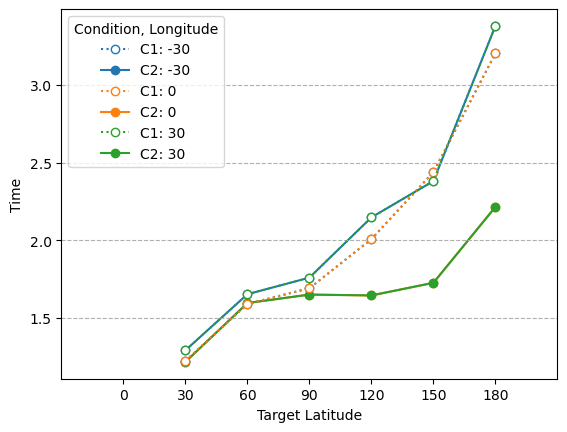

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


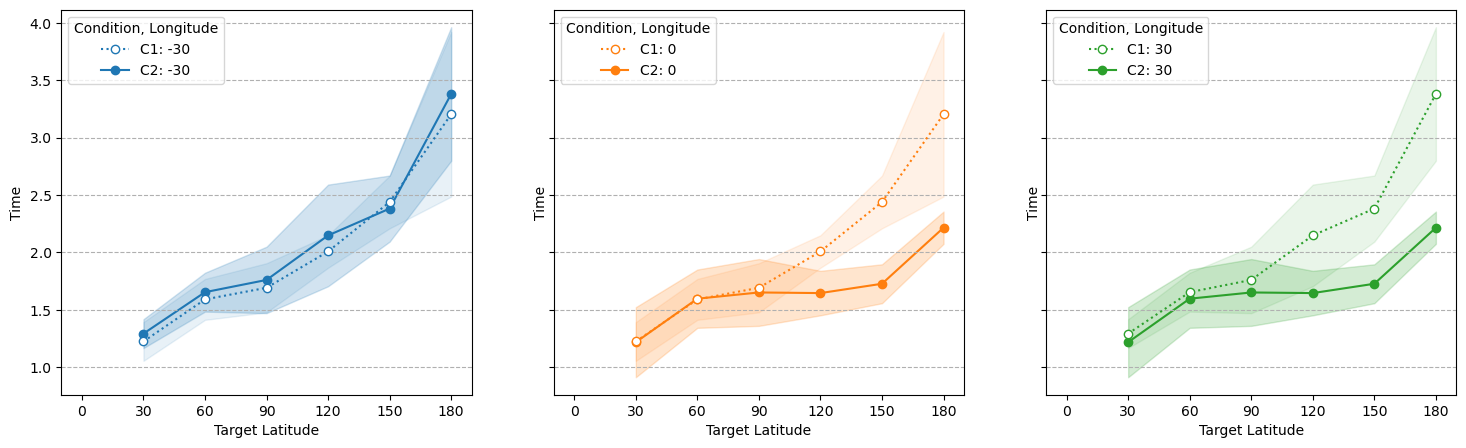

(3, 7)
#####
ratio [[1.         1.05584739 1.03957267 1.04041837 1.06972252 0.97644878
  1.05522357]
 [1.         0.99492187 1.00390966 0.97590528 0.81960025 0.70800948
  0.69154493]
 [1.         0.94229704 0.96569454 0.93799313 0.76618024 0.72508614
  0.65535394]]
#####
log [[ 0.          0.07840132  0.05599062  0.05716378  0.09723662 -0.03438373
   0.0775487 ]
 [ 0.         -0.00734485  0.00562945 -0.03518696 -0.28700767 -0.49815942
  -0.53210511]
 [ 0.         -0.08574618 -0.05036117 -0.09235074 -0.38424429 -0.46377569
  -0.60965381]]
#####
RATIO!!
remove one
remove one
remove one


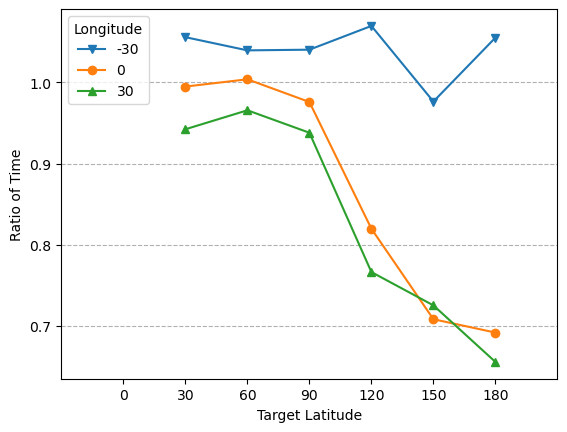

LOG!!
remove zero
remove zero
remove zero


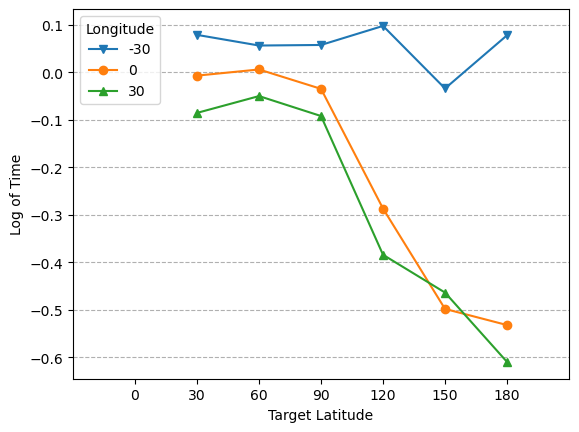

data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (3, 7, 6)
data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (3, 7, 6)
data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (3, 7, 6)
data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (3, 7, 6)


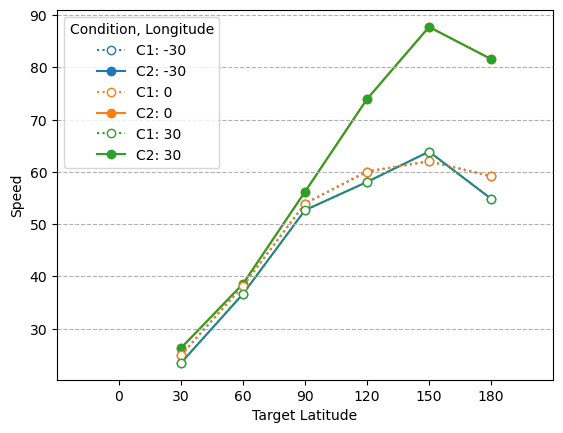

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


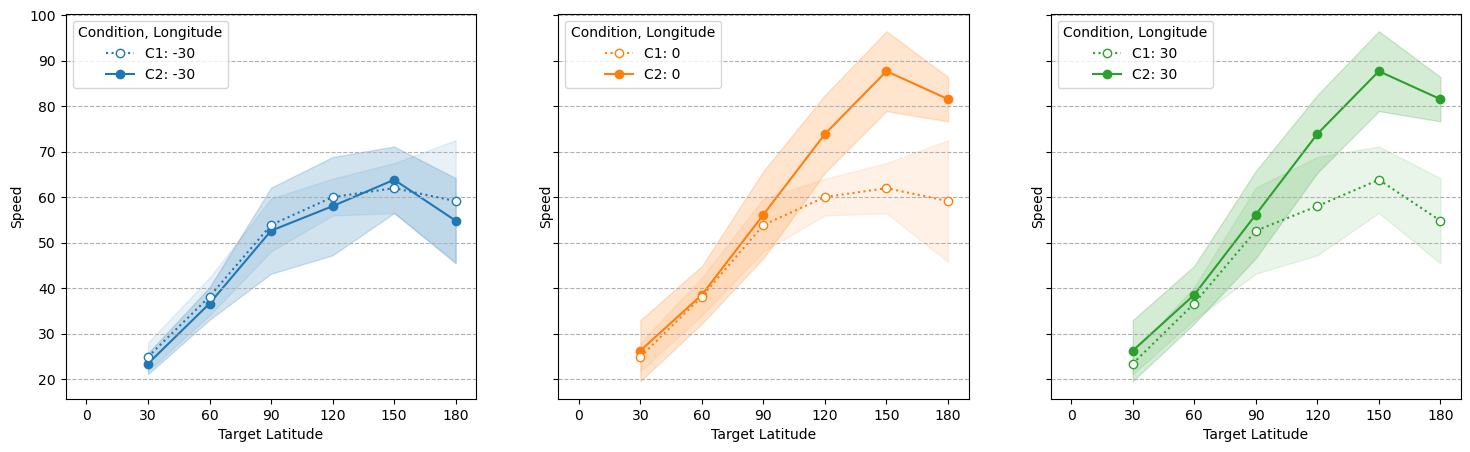

(3, 7)
#####
ratio [[1.         0.93988806 0.959896   0.97649122 0.9668426  1.02977191
  0.92713666]
 [1.         1.05419156 1.01033006 1.04191289 1.23097818 1.41443438
  1.37870643]
 [1.         1.12161395 1.05254117 1.06699668 1.27319398 1.37354143
  1.48705849]]
#####
log [[ 0.         -0.08943915 -0.05904998 -0.03432103 -0.04864705  0.04232482
  -0.10914609]
 [ 0.          0.07613705  0.01482667  0.05923466  0.29980519  0.50022525
   0.4633153 ]
 [ 0.          0.1655762   0.07387666  0.09355569  0.34845224  0.45790043
   0.57246139]]
#####
RATIO!!
remove one
remove one
remove one


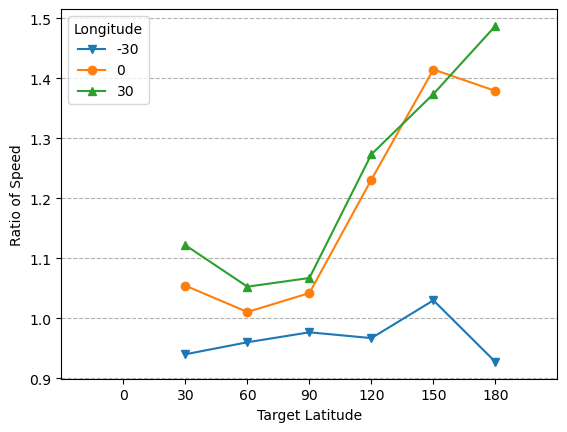

LOG!!
remove zero
remove zero
remove zero


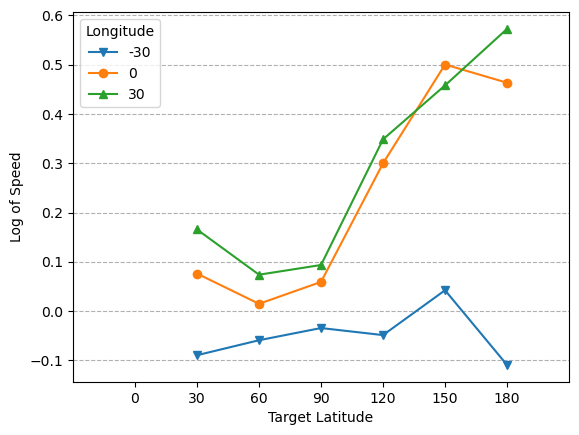

data to cal is (3, 7, 6)
data to cal is (3, 7, 6)
data to cal is (3, 7, 6)
data to cal is (3, 7, 6)


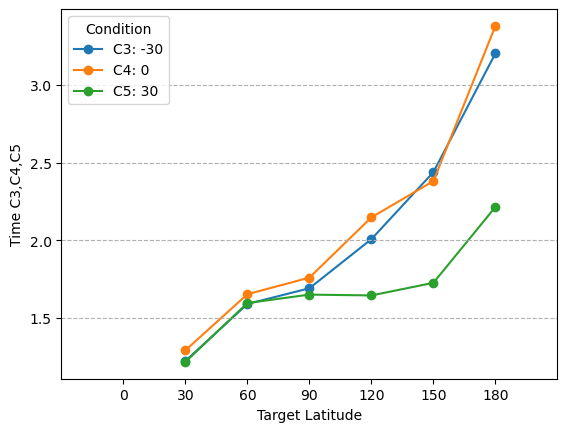

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


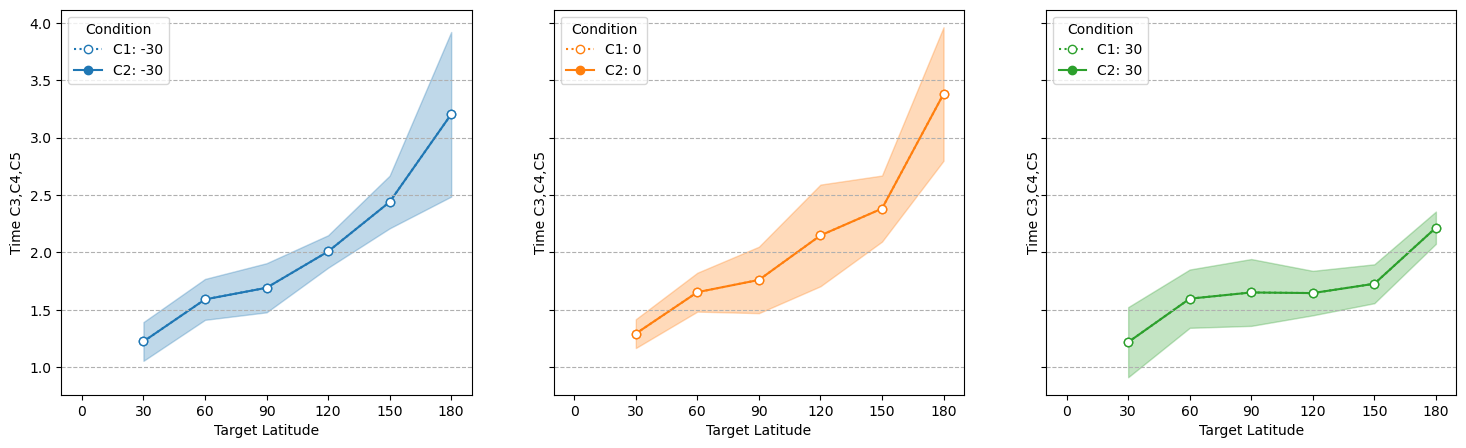

(3, 7)
#####
ratio [[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
#####
log [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
#####
RATIO!!
remove one
remove one
remove one


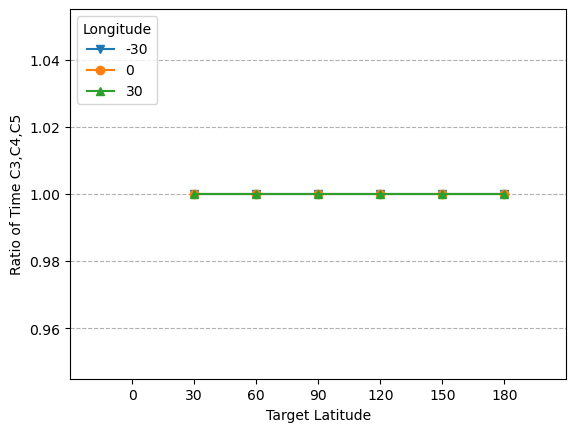

LOG!!
remove zero
remove zero
remove zero


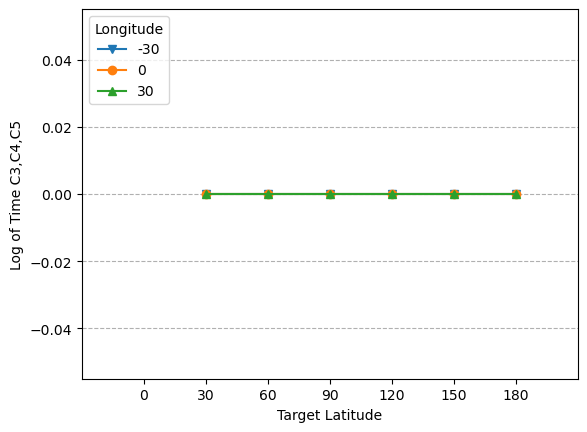

data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (3, 7, 6)
data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (3, 7, 6)
data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (3, 7, 6)
data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (3, 7, 6)


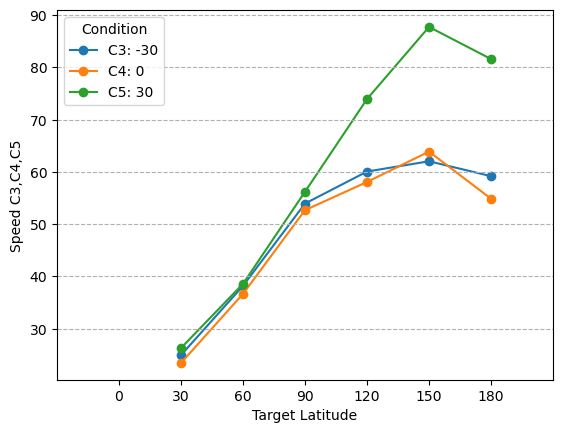

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


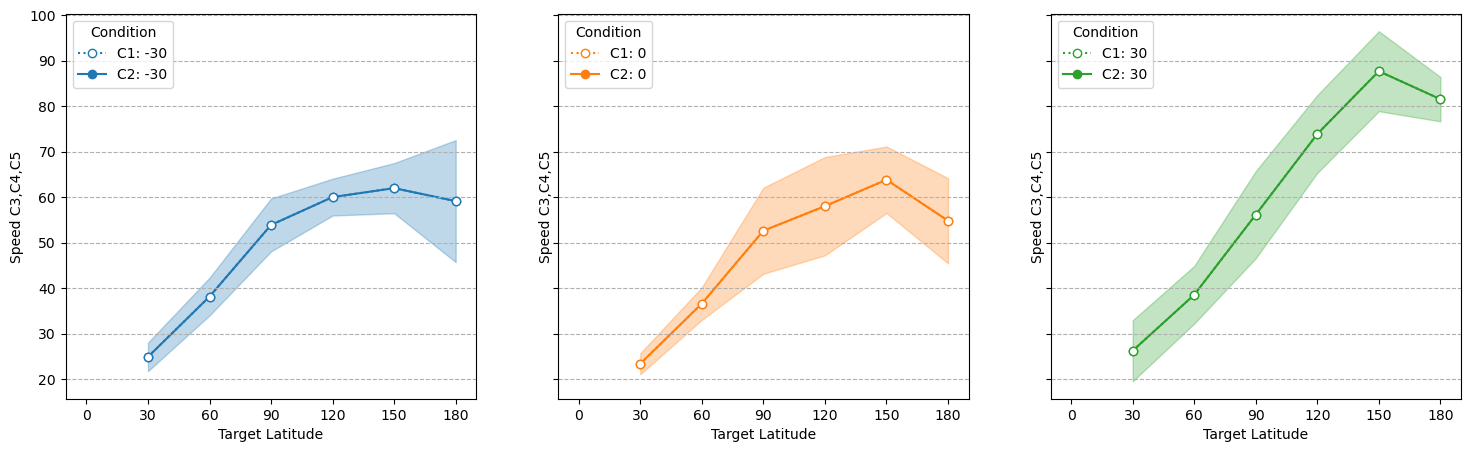

(3, 7)
#####
ratio [[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
#####
log [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
#####
RATIO!!
remove one
remove one
remove one


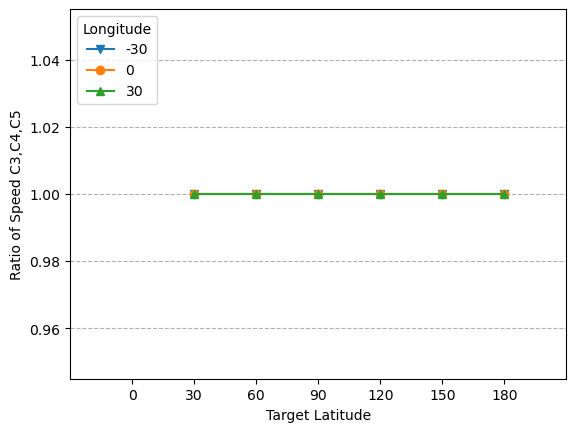

LOG!!
remove zero
remove zero
remove zero


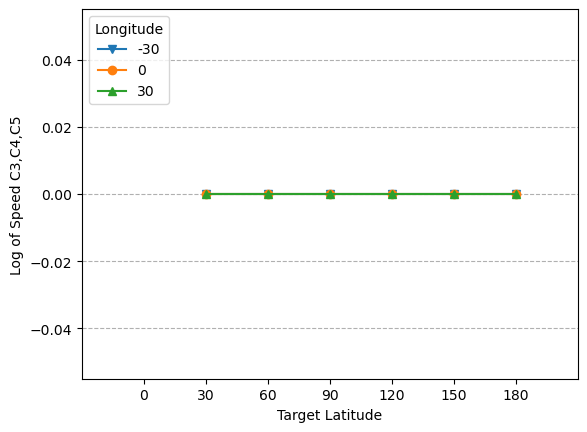

In [147]:
### C3-C4-C5 ###




print(time_10x334.shape)
print(Speed(time_mean_334, '345').value.shape)

plot_line_dual_any_plus('Time',
                        m_mean(time_10x334.T),
                        m_mean(time_10x455.T),
                        m_std(time_10x334.T),
                        m_std(time_10x455.T))

plot_line_dual_any_plus('Speed',
                        m_mean(Speed(time_10x334, '345').value.T), 
                        m_mean(Speed(time_10x455, '345').value.T),
                        m_std(Speed(time_10x334, '345').value.T), 
                        m_std(Speed(time_10x455, '345').value.T))


plot_line_dual_any_plus('Time C3,C4,C5',
                        m_mean(time_10x345.T),
                        m_mean(time_10x345.T),
                        m_std(time_10x345.T),
                        m_std(time_10x345.T),
                        '345')

plot_line_dual_any_plus('Speed C3,C4,C5',
                        m_mean(Speed(time_10x345, '345').value.T), 
                        m_mean(Speed(time_10x345, '345').value.T),
                        m_std(Speed(time_10x345, '345').value.T), 
                        m_std(Speed(time_10x345, '345').value.T),
                        '345')



In [94]:
def plotcontrast4(r1,r2,s1,s2, kind):
    
    
    r1=np.array(r1)
    s1=np.array(s1)
    r2=np.array(r2)
    s2=np.array(s2)
    
    lonMean1=[]
    lonMean2=[]
    latMean1=[]
    latMean2=[]
    
    lonStd1=[]
    lonStd2=[]
    latStd1=[]
    latStd2=[]
    
    for i in range(3):
        latMean1.append(np.mean(r1[i]))
        latStd1.append(np.std(r1[i]))
        latMean2.append(np.mean(r2[i]))
        latStd2.append(np.std(r2[i]))
    
    for i in range(7):
        lonMean1.append(np.mean(r1.T[i]))
        lonStd1.append(np.std(r1.T[i]))
        lonMean2.append(np.mean(r2.T[i]))
        lonStd2.append(np.std(r2.T[i]))
        
    if (kind=='Speed'):
        ymax = 100
    else:
        ymax = 10
        
    plt.figure(1, figsize = (15,10))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    
    plt.subplot(2, 2, 1)
    x = np.arange(7)
    width = 0.1
    offset = 0.1
    opacity = 0.2
  
    #for i in range(7):
    plt.bar(x-3*offset,r1[0], width, label="-30(N)", color="C0", alpha=1-opacity, 
            yerr=s1[0])
    plt.bar(x-2*offset,r2[0], width, label="-30(A)", color="C3", alpha=1-opacity, yerr=s2[0])
    plt.bar(x-0.5*offset,r1[1], width, label="0(N)", color="C0", alpha=1-2*opacity, yerr=s1[1])
    plt.bar(x+0.5*offset,r2[1], width, label="0(A)", color="C3", alpha=1-2*opacity, yerr=s2[1])
    plt.bar(x+2*offset,r1[2], width, label="30(N)", color="C0", alpha=1-3*opacity, yerr=s1[2])
    plt.bar(x+3*offset,r2[2], width, label="30(A)", color="C3", alpha=1-3*opacity, yerr=s2[2])
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Longitude", loc=2)
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    
    plt.xticks(x,key2)
    
    
    
    plt.subplot(2, 2, 2)
     
    plt.bar(x-offset,lonMean1, 2*width, label="C1", color="C0", alpha=1-opacity)
    plt.bar(x+offset,lonMean2, 2*width, label="C2", color="C3", alpha=1-opacity)
    #plt.bar(x+offset,lonMean2, 2*width, label="C2", color="C3", alpha=1-opacity, yerr=lonStd2)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Condition", loc=2)
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    plt.xticks(x,key2)
    
    
    
    plt.subplot(2, 2, 3)
    
    x = np.arange(3)
    width = 0.05
    gap = 0.02
    opacity = 0.1
    
    for i in range(7):
        plt.bar(x+(i-3)*(gap+2*width)-0.5*width,r1.T[i], width, label=str(30*i), color="C0", alpha=1-opacity*i, yerr=s1.T[i])
        plt.bar(x+(i-3)*(gap+2*width)+0.5*width,r2.T[i], width, label=str(30*i), color="C3", alpha=1-opacity*i, yerr=s2.T[i])
        #plt.bar(x+(i-3)*(gap+2*width)-0.5*width,r1.T[i], width, label="C1", color="C0", alpha=1, yerr=s1.T[i])
        #plt.bar(x+(i-3)*(gap+2*width)+0.5*width,r2.T[i], width, label="C2", color="C3", alpha=1, yerr=s2.T[i])
       
        # width,width,gap,width,width,gap,width,width,gap,width|width,gap,width,width,gap,width,width,gap,width,width
        #plt.bar(x+(i-3)*offset, r1.T[i], width, yerr=s1.T[i], label=str(i*30), color="C0", alpha=1-opacity*i)
        #plt.bar(x+(i-3)*offset+width, r2.T[i], width, yerr=s2.T[i], label=str(i*30), color="C3", alpha=1-opacity*i)
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel('Target Latitude')
    #ax.legend(title="Longitude")
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    plt.xticks(x,key1)
    
    
    
    plt.subplot(2, 2, 4)
    
    plt.bar(x-1.5*width,latMean1, 3*width, label='C1', color="C0", alpha=1-opacity)
    plt.bar(x+1.5*width,latMean2, 3*width, label='C2', color="C3", alpha=1-opacity)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel('Target Latitude')
    ax.legend(title="Condition")
    ax.set_ylabel(kind)
    plt.ylim(0,ymax)
    plt.xticks(x,key1)
    
    
    export_img("bar")
    plt.show()

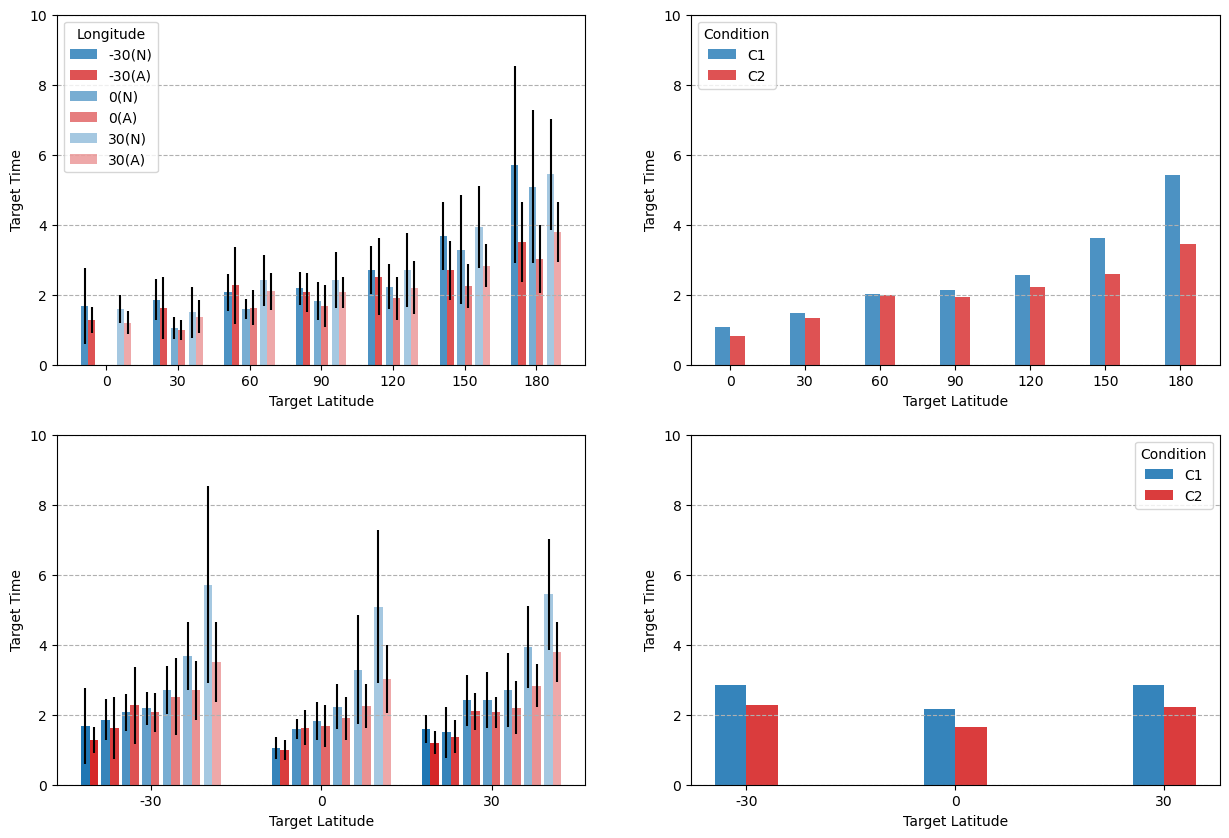

In [96]:
plotcontrast4(test1.mean.time_3x7_mean, 
              test2.mean.time_3x7_mean,
              test1.mean.time_3x7_std,
              test2.mean.time_3x7_std,
              'Target Time') # plot 4 graph about time

In [97]:
def plotcontrast2(mean, std, kind):

        
    plt.figure(1, figsize = (7,5))
    key1=[1,2]
    key2=[3,4,5]
    
    if (len(mean)==2):
        x = key1
    else:
        x = key2
    

    
    for i in range(len(mean)):
        plt.bar(str(x[i]), mean[i], 0.8, label="C" + str(x[i]), color="C" + str(i*3), alpha=0.8, yerr=std[i])
    #plt.bar(x+offset,lonMean2, 2*width, label="C2", color="C3", alpha=1-opacity, yerr=lonStd2)
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    #ax.legend(title="Condition", loc=2)
    ax.set_xlabel('Condition')
    ax.set_ylabel('Score of '+kind)
    #plt.ylim(0,ymax)
    #plt.xticks(x,str(x))
    
 
    
    
    export_img("bar")
    plt.show()

In [82]:
### ANOVA ###


    
def anova_export(input_1, input_2, name, input_3=None):
    with open('csv/' + name + '.csv', 'a') as csvFile:
        writer = csv.writer(csvFile)
        
        header = [name]
        for i in range(len(np.array(input_1[0]).flatten().tolist())):
            header = header + ['S' + str(i+1)]
        writer.writerow(header)
        for i in input_1:     
            row = ['C1'] + np.array(i).flatten().tolist()
            writer.writerow(row)
        for i in input_2:
            row = ['C2'] + np.array(i).flatten().tolist()
            writer.writerow(row)
        if input_3 is not None:
            for i in input_2:
                row = ['C2'] + np.array(i).flatten().tolist()
                writer.writerow(row)
        writer.writerow('Break')

        csvFile.close()


print("### CONDITION TIME ANOVA ###")

print("\n### Round Time / Speed ANOVA ###") # for export 10xN is better


anova_export(test1.mean.time_10x4,
             test2.mean.time_10x4,
             'ANOVA of RT by U over R-C')
anova_export(Speed(test1.mean.time_4x10).value.T,
             Speed(test2.mean.time_4x10).value.T,
             'ANOVA of RS by U over R-C')

print("\n### Target Time / Speed ANOVA ###")


anova_export(test1.mean.time_20x10.T,
             test2.mean.time_20x10.T,
             'ANOVA of TT by U over T-C')
anova_export(Speed(test1.mean.time_20x10).value.T,
             Speed(test2.mean.time_20x10).value.T,
             'ANOVA of TS by U over T-C')

    #test1_time_location = np.delete(np.array(test1.time_mean_3x7).flatten(), 7)


anova_export(test1.mean.time_20x10,
             test2.mean.time_20x10,
             'ANOVA of TT by T over U-C')
anova_export(Speed(test1.mean.time_20x10).value,
             Speed(test2.mean.time_20x10).value,
             'ANOVA of TS by T over U-C')
    

anova_export(test1.mean.time_10x3x7,
             test2.mean.time_10x3x7,
             'ANOVA of TT by U over Lat-Lon')
anova_export(Speed(test1.mean.time_10x3x7).value,
             Speed(test2.mean.time_10x3x7).value,
             'ANOVA of TS by U over Lat-Lon')
    
    
# ANOVA of RT by U over R-C
# ANOVA of TS by U over T-C
# ANOVA of TS by T over U-C
# ANOVA of TS by U over Lat-Lon

# ANOVA of TS by U over T-C

print("\n### 3 - 4 - 5 ###")
anova_export(Speed(test3.mean.time_20x10).value.T,
             Speed(test4.mean.time_20x10).value.T,
             'ANOVA of TS by U over T-C 3-4-5',
             Speed(test5.mean.time_20x10).value.T)

anova_export(test3.mean.time_20x10.T,
             test4.mean.time_20x10.T,
             'ANOVA of TT by U over T-C 3-4-5',
             test5.mean.time_20x10.T)

anova_export(test3.mean.time_10x4,
             test4.mean.time_10x4,
             'ANOVA of RT by U over R-C 3-4-5',
             test5.mean.time_10x4)

print(test3.mean.time_10x4)

anova_export(Speed(test3.mean.time_4x10,'030').value.T,
             Speed(test4.mean.time_4x10,'030').value.T,
             'ANOVA of RS by U over R-C 3-4-5',
             Speed(test5.mean.time_4x10,'030').value.T)

anova_export(test3.mean.time_20x10,
             test4.mean.time_20x10,
             'ANOVA of TT by T over U-C 3-4-5',
             test5.mean.time_20x10)

anova_export(Speed(test3.mean.time_20x10).value,
             Speed(test4.mean.time_20x10).value,
             'ANOVA of TS by T over U-C 3-4-5',
             Speed(test5.mean.time_20x10).value)



### CONDITION TIME ANOVA ###

### Round Time / Speed ANOVA ###
data to cal is (20, 1)
(4, 14)
2
HIT HIT HIT HIT HIT HIT HIT HIT HIT HIT 
[[1890.]]
get get get get get get get get get get 
data to cal is (20, 1)
(4, 14)
2
HIT HIT HIT HIT HIT HIT HIT HIT HIT HIT 
[[1890.]]
get get get get get get get get get get 

### Target Time / Speed ANOVA ###
data to cal is (20, 1)
(20, 14)
2
data to cal is (20, 1)
(20, 14)
2
data to cal is (20, 1)
(20, 14)
2
data to cal is (20, 1)
(20, 14)
2
data to cal is (20, 1)
(14, 3, 7)
3
data to cal is (20, 1)
(14, 3, 7)
3

### 3 - 4 - 5 ###
data to cal is (20, 1)
(6, 6)
2
data to cal is (20, 1)
(6, 6)
2
data to cal is (20, 1)
(6, 6)
2
[[11.62390000000002, 11.306200000000047, 10.596999999999952, 11.007899999999978], [16.637500000000074, 14.54340000000002, 13.963400000000036, 14.58459999999991], [12.042700000000053, 11.189199999999971, 11.590700000000027, 9.612099999999998], [14.842399999999941, 11.230200000000082, 10.812200000000018, 10.336499999999887], [14.

In [150]:
def fdr(input_data, length=None):
    fdr=0
    fdr_s=True
    bon=0
    naive=0
    j=0
    
    len_data = 0
    for i in input_data:
        if not np.isnan(i):
            len_data += 1
    if length is None:
        length = len_data
        print('p count: ', length)
    for i in np.sort(input_data):
        sig=""
        if (i<(0.05/length)):
            bon = bon +1
            fdr = fdr +1
            naive = naive +1
            sig="*"*3
            #print('Bon OK')
        elif (i<(0.05/length*(j+1)) and fdr_s):
            fdr = fdr +1
            naive = naive +1
            sig= "*"*2
            #print('FDR OK')
        elif (i<(0.05)):
            fdr_s=False
            naive = naive +1
            sig= "*"
            #print('Naïve OK')
            
            
        print("{:.5g}{}".format(i,sig))
        j = j+1
       
    print("-"*30)
    print("Total: "+ str(length)+" ? Valid: "+str(len(input_data)))
    print("Naïve: "+ str(naive))
    print("FDR: "+ str(fdr))
    print("Bon: "+ str(bon))
    print("-"*30)
    print('\n')    


    
def cal_ttest_10x3x7(t1, t2):
    tvalue=[]
    pvalue=[]
    for lat in range(len(t1[0])):
        tv=[]
        pv=[]
        for lon in range(len(t1[0][0])):
            all_user_t1=[]
            all_user_t2=[]
            for user in range(len(t1)):
                all_user_t1.append(t1[user][lat][lon])
                all_user_t2.append(t2[user][lat][lon])

            t,p = ttest_rel(all_user_t1, all_user_t2)
            tv.append(t) # *7
            pv.append(p)
        tvalue.append(tv)
        pvalue.append(pv)# *3
    
    d1 =[]
    d2 =[]
    for user in range(len(t1)):
        data_1 = [i for i in np.array(t1[user]).flat if (i!=0)]
        data_2 = [i for i in np.array(t2[user]).flat if (i!=0)]
        d1.append(np.mean(data_1))
        d2.append(np.mean(data_2))
    
    shape = np.array(t1).shape
    print('input array shape: %d * %d * %d' %(shape[0], shape[1], shape[2]))
    t_all,p_all = ttest_rel(d1, d2)
    print('t_%dx1: %f' %(len(t1), t_all), 'p_%dx1: %f' %(len(t1), p_all))

    #print('t_all', t_all, 'p_all', p_all)
    #np.set_printoptions(precision=3)
    print('=====T-stats=====')
    print(np.array(tvalue).astype(float) )
    print('=====P-value=====')
    print(np.array(pvalue).astype(float) )
    print('===== FDR =====')
    fdr(np.array(pvalue).flatten().astype(float) )
    
    return tvalue, pvalue



def cal_ttest_20x10(t1, t2, t3=None): # target * user
    tvalue=[]
    pvalue=[]
    if t3 is None:
        for target in range(len(t1)):
            tv,pv = ttest_rel(t1[target], t2[target])
            tvalue.append(tv)
            pvalue.append(pv)# *30

        d1 =[]
        d2 =[]
        for user in range(len(t1)):
            data_1 = [i for i in np.array(t1[user]).flat if (i!=0)]
            data_2 = [i for i in np.array(t2[user]).flat if (i!=0)]
            d1.append(np.mean(data_1))
            d2.append(np.mean(data_2))

        print('input array shape: %d * %d' %(len(t1), len(t1[0])))
        t_all,p_all = ttest_rel(d1, d2)
        print('t_%dx1: %f' %(len(t1), t_all), 'p_%dx1: %f' %(len(t1), p_all))
        print('=== T-statistics ===')
    else:
        for target in range(len(t1)):
            tv,pv = stats.f_oneway(t1[target], t2[target], t3[target])
            tvalue.append(tv)
            pvalue.append(pv)# *30

        print('=== ANOVA ===')
    #np.set_printoptions(precision=3)
    print(np.array(tvalue).astype(float) )
    print('=== P-value ===')
    print(np.array(pvalue).astype(float) )
    print('===== FDR =====')
    fdr(np.array(pvalue).flatten().astype(float) )
    
    return tvalue, pvalue





209.8849200000001
219.72282961904762
data to cal is (20, 1)
(14, 3, 7)
3
data to cal is (20, 1)
(14, 3, 7)
3
input array shape: 14 * 3 * 7
t_14x1: -3.269567 p_14x1: 0.006094
=====T-stats=====
[[-1.92711213 -2.22113813 -0.08813302 -0.93035362 -1.48387764 -2.94878455
  -3.25206803]
 [        nan -0.66373876 -0.38312438 -0.99835972 -2.3073945  -4.14509793
  -3.4907272 ]
 [-2.30982942 -0.21227379 -1.70614728 -1.0954942  -2.05351651 -3.90414635
  -4.89109545]]
=====P-value=====
[[7.61058085e-02 4.47250065e-02 9.31114149e-01 3.69143156e-01
  1.61678337e-01 1.12982090e-02 6.30309474e-03]
 [           nan 5.18456011e-01 7.07819173e-01 3.36326129e-01
  3.81318652e-02 1.15172602e-03 3.98427152e-03]
 [3.79598375e-02 8.35185540e-01 1.11740849e-01 2.93181049e-01
  6.07103912e-02 1.81190483e-03 2.94733224e-04]]
===== FDR =====
p count:  20
0.00029473***
0.0011517***
0.0018119***
0.0039843**
0.0063031**
0.011298**
0.03796*
0.038132*
0.044725*
0.06071
0.076106
0.11174
0.16168
0.29318
0.33633
0.36914
0

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


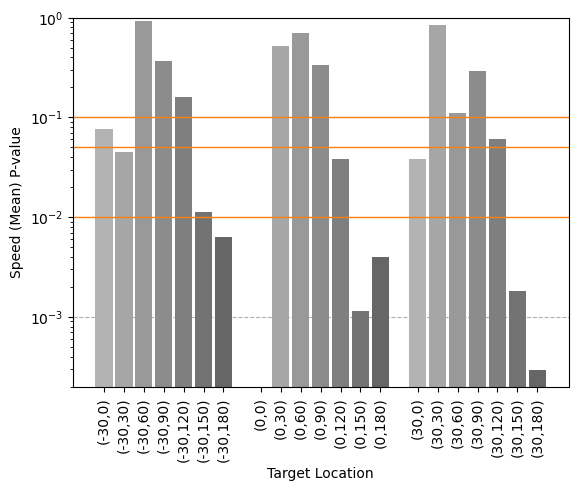

input array shape: 14 * 3 * 7
t_14x1: 3.477863 p_14x1: 0.004084
=====T-stats=====
[[ 1.35196188  0.96707527 -0.78422675  0.68452904  0.63312406  3.12416771
   2.93622168]
 [        nan  0.54139486 -0.36553742  0.69402621  1.91691471  3.0541573
   3.03812351]
 [ 2.27176344  0.50300115  1.79334977  1.51410682  1.64348808  3.62233832
   4.41460665]]
=====P-value=====
[[1.99441331e-01 3.51154179e-01 4.46961913e-01 5.05662396e-01
  5.37631592e-01 8.06280246e-03 1.15742188e-02]
 [           nan 5.97391863e-01 7.20589136e-01 4.99880525e-01
  7.74917558e-02 9.22587974e-03 9.51493889e-03]
 [4.07353569e-02 6.23377197e-01 9.62009171e-02 1.53927287e-01
  1.24235848e-01 3.09673459e-03 6.98620815e-04]]
===== FDR =====
p count:  20
0.00069862***
0.0030967**
0.0080628*
0.0092259*
0.0095149*
0.011574*
0.040735*
0.077492
0.096201
0.12424
0.15393
0.19944
0.35115
0.44696
0.49988
0.50566
0.53763
0.59739
0.62338
0.72059
nan
------------------------------
Total: 20 ? Valid: 21
Naïve: 7
FDR: 2
Bon: 1
--------

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


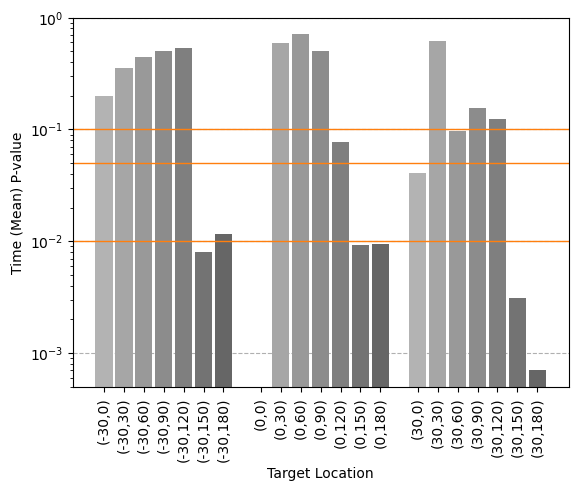

input array shape: 6 * 7 * 3
t_6x1: 3.723964 p_6x1: 0.013656
=====T-stats=====
[[        nan         nan         nan]
 [-0.75913616  0.06831619  0.66855222]
 [-0.78140001 -0.0747993   0.77517813]
 [-0.47158351  0.28659576  0.63965493]
 [-0.64703715  3.46020889  3.56612097]
 [ 0.41007814  5.87928612  4.9480216 ]
 [-0.94188303  3.30507469  5.17032223]]
=====P-value=====
[[       nan        nan        nan]
 [0.48200524 0.94818179 0.5334012 ]
 [0.46993084 0.94327483 0.47328279]
 [0.65708496 0.78591795 0.55055028]
 [0.54613528 0.01803826 0.01610973]
 [0.698728   0.00202153 0.00429226]
 [0.38949811 0.02135584 0.00355392]]
===== FDR =====
p count:  18
0.0020215***
0.0035539**
0.0042923**
0.01611*
0.018038*
0.021356*
0.3895
0.46993
0.47328
0.48201
0.5334
0.54614
0.55055
0.65708
0.69873
0.78592
0.94327
0.94818
nan
nan
nan
------------------------------
Total: 18 ? Valid: 21
Naïve: 6
FDR: 3
Bon: 1
------------------------------


0.3895
0.46993
0.48201
0.54614
0.65708
0.69873
nan
---------------

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


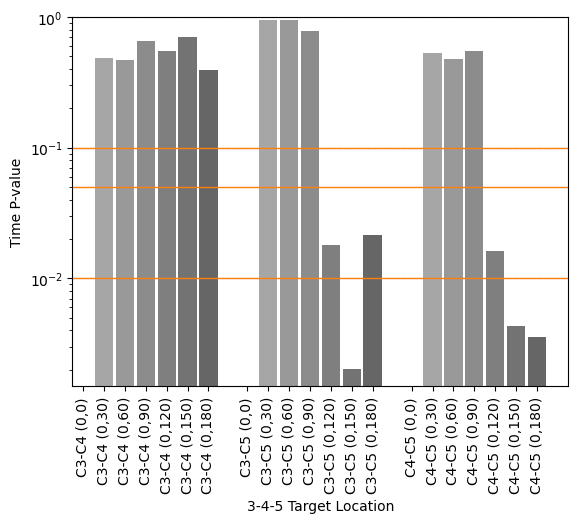

data to cal is (18, 1)
(6, 7, 3)
3
data to cal is (18, 1)
(6, 7, 3)
3
input array shape: 6 * 7 * 3
t_6x1: -4.562871 p_6x1: 0.006041
=====T-stats=====
[[        nan         nan         nan]
 [ 0.88922    -0.61153016 -1.14173016]
 [ 0.8161586  -0.18844515 -0.94112094]
 [ 0.26905155 -0.54568451 -0.57359681]
 [ 0.37942512 -3.2966738  -4.53411244]
 [-0.50834289 -5.96171448 -5.41672148]
 [ 1.27613088 -4.29529373 -8.25139649]]
=====P-value=====
[[           nan            nan            nan]
 [4.14613665e-01 5.67582051e-01 3.05278159e-01]
 [4.51525348e-01 8.57937462e-01 3.89852700e-01]
 [7.98639290e-01 6.08735466e-01 5.91075369e-01]
 [7.19952456e-01 2.15543411e-02 6.20205882e-03]
 [6.32840381e-01 1.89975361e-03 2.90277075e-03]
 [2.57971959e-01 7.74999724e-03 4.26228283e-04]]
===== FDR =====
p count:  18
0.00042623***
0.0018998***
0.0029028**
0.0062021**
0.00775**
0.021554*
0.25797
0.30528
0.38985
0.41461
0.45153
0.56758
0.59108
0.60874
0.63284
0.71995
0.79864
0.85794
nan
nan
nan
-------------

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


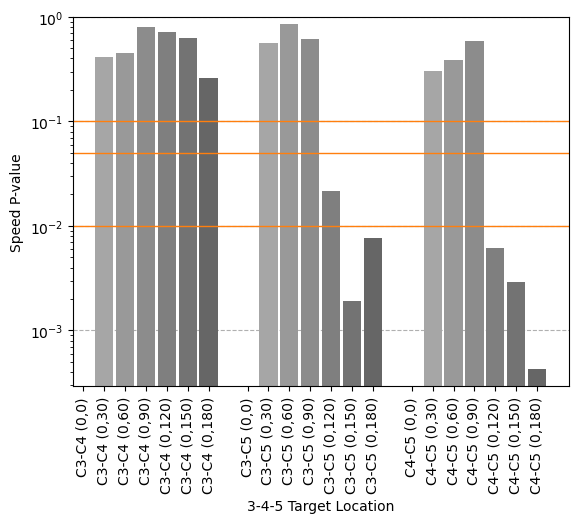

In [152]:
### Multi T-Test ###
## C1 - C2 ##


print(4*test1.median.time_1_mean)
print(4*test1.mean.time_1_mean)

#speed_t, speed_p = cal_ttest_10x3x7(test1.speed_mean_10x3x7, test2.speed_mean_10x3x7)
speed_t, speed_p = cal_ttest_10x3x7(Speed(test1.mean.time_10x3x7).value,
                                    Speed(test2.mean.time_10x3x7).value)
plot_bar_single(speed_p, 0, 1,'Target Location', 'Speed (Mean) P-value')


#time_t, time_p = cal_ttest_10x3x7(test1.time_mean_10x3x7, test2.time_mean_10x3x7)
time_t, time_p = cal_ttest_10x3x7(test1.mean.time_10x3x7,
                                  test2.mean.time_10x3x7)
#fdr(np.array(time_p).flatten(), 20)
plot_bar_single(time_p, 0, 1,'Target Location', 'Time (Mean) P-value')

#plot_bar_single(time_t)

time_345_t, time_345_p = cal_ttest_10x3x7(time_10x334, time_10x455)
#fdr(np.array(time_345_p).flatten(), 6)
fdr(np.array(time_345_p).T[0], 6)
fdr(np.array(time_345_p).T[1], 6)
fdr(np.array(time_345_p).T[2], 6)
plot_bar_single(time_345_p, 0, 1,'3-4-5 Target Location', 'Time P-value')


speed_345_t, speed_345_p = cal_ttest_10x3x7(Speed(time_10x334, '345').value,
                                            Speed(time_10x455, '345').value)
#fdr(np.array(speed_345_p).flatten(), 6)
fdr(np.array(speed_345_p).T[0], 6)
fdr(np.array(speed_345_p).T[1], 6)
fdr(np.array(speed_345_p).T[2], 6)
plot_bar_single(speed_345_p, 0, 1,'3-4-5 Target Location', 'Speed P-value')


if(False): 
    speed_t, speed_p = cal_ttest_10x3x7(Speed(test1.median.time_10x3x7).value,
                                     Speed(test2.median.time_10x3x7).value)
    fdr(np.array(speed_p).flatten(), 20)
    plot_bar_single(speed_p, 0, 1,'Target Location', 'Speed (Median) P-value')
    
    time_t, time_p = cal_ttest_10x3x7(test1.median.time_10x3x7, test2.median.time_10x3x7)
    fdr(np.array(time_p).flatten(), 20)
    plot_bar_single(time_p, 0, 1,'Target Location', 'Time (Median) P-value')
    
    





 ########## 

 Time 

 ##########


### Condition Time ###
sum of target
input array shape: 1 * 14
t_1x1: nan p_1x1: nan
=== T-statistics ===
[3.47786293]
=== P-value ===
[0.00408381]
===== FDR =====
p count:  1
0.0040838***
------------------------------
Total: 1 ? Valid: 1
Naïve: 1
FDR: 1
Bon: 1
------------------------------


sum of round
data to cal is (14, 4)
data to cal is (14, 4)
input array shape: 1 * 14
t_1x1: nan p_1x1: nan
=== T-statistics ===
[3.51040561]
=== P-value ===
[0.00383673]
===== FDR =====
p count:  1
0.0038367***
------------------------------
Total: 1 ? Valid: 1
Naïve: 1
FDR: 1
Bon: 1
------------------------------




### Lon Time ###
input array shape: 7 * 14
t_7x1: 2.135918 p_7x1: 0.076581
=== T-statistics ===
[2.01717569 1.00340954 0.17508641 1.310556   1.67063551 3.80276848
 4.67376311]
=== P-value ===
[6.48134499e-02 3.33975443e-01 8.63709305e-01 2.12689697e-01
 1.18679540e-01 2.19575792e-03 4.35380765e-04]
===== FDR =====
p count:  7
0.00043538***
0.00

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


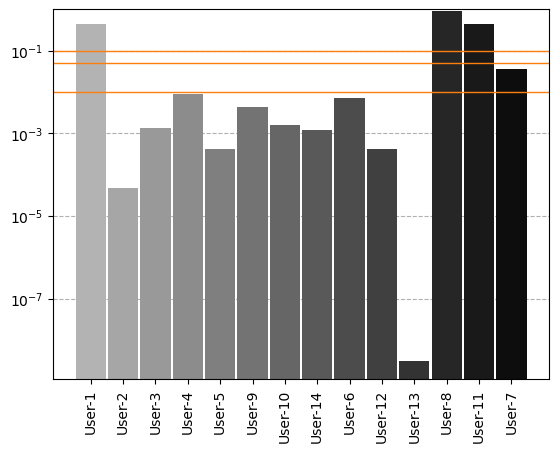

In [169]:
### Multi T-Test ###
## C1 - C2 ##


print('\n\n','#'*10,'\n\n Time \n\n','#'*10)

print('\n\n### Condition Time ###')
print('sum of target')
cal_ttest_20x10(4 * test1.mean.time_1x10, 4 * test2.mean.time_1x10)
print('sum of round')
cal_ttest_20x10([np.array(m_sum(test1.mean.time_10x4)).T.tolist()],
                 [np.array(m_sum(test2.mean.time_10x4)).T.tolist()])

print('\n\n### Lon Time ###')
cal_ttest_20x10(np.array(test1.mean.time_7x10), np.array(test2.mean.time_7x10))

print('\n\n### Lat Time ###')
cal_ttest_20x10(np.array(test1.mean.time_3x10), np.array(test2.mean.time_3x10))
#cal_ttest_20x10(np.array(test1.mean.time_3x10).T, np.array(test2.mean.time_3x10).T)

print('\n\n### Target Time ###')
cal_ttest_20x10(test1.mean.time_20x10, test2.mean.time_20x10)
#cal_ttest_10x3x7(test1.mean.time_10x3x7, test2.mean.time_10x3x7)

print('\n\n### Over User ###')
cal_ttest_20x10((test1.mean.time_20x10).T, test2.mean.time_20x10.T)


print('\n\n###')

print('\n\n','#'*10,'\n\n Speed \n\n','#'*10)

print('\n\n### Condition Speed ###')
cal_ttest_20x10(np.array(Speed(test1.mean.time_1x10).value),
              np.array(Speed(test2.mean.time_1x10).value))
cal_ttest_20x10(np.array(Speed(np.array(m_sum(test1.mean.time_10x4)).T).value),
              np.array(Speed(np.array(m_sum(test2.mean.time_10x4)).T).value))

print('\n\n### Lon Speed ###')
cal_ttest_20x10(np.array(Speed(test1.mean.time_7x10).value),
              np.array(Speed(test2.mean.time_7x10).value))

print('\n\n### Lat Speed ###')
cal_ttest_20x10(np.array(Speed(test1.mean.time_3x10).value),
              np.array(Speed(test2.mean.time_3x10).value))

print('\n\n### Target Speed ###')
#cal_ttest_10x3x7(Speed(test1.mean.time_10x3x7).value, Speed(test2.mean.time_10x3x7).value)
cal_ttest_20x10(Speed(test1.mean.time_20x10).value,
                Speed(test2.mean.time_20x10).value)

print('\n\n### Over User ###')
# 10 user  speed mean of 20 target
user_t, user_p = cal_ttest_20x10(Speed(test1.mean.time_20x10).value.T,
                            Speed(test2.mean.time_20x10).value.T)

plot_bar_single([user_p], 0, 1, x_title=None, y_title=None, z_title=None)


# 20 target  time mean of 10 user
#print('\n\n','#'*10,'\n\nOver Targets\n\n','#'*10)
#cal_ttest_20x10(test1.mean.time_20x10, test2.mean.time_20x10)

#cal_ttest_20x10(Speed(test1.mean.time_20x10).value, Speed(test2.mean.time_20x10).value)



In [93]:
##### C3 C4 C5 #####
print(test2.mean.time_20x10.shape)
print(test3.mean.time_20x10.shape)
print(test3.mean.time_3x7x10[0][1:])
#print()
#cal_ttest_20x10(np.array(test3.median.time_7x10), np.array(test4.median.time_7x10))
#cal_ttest_10x3x7(time_10x334, time_10x455)
#cal_ttest_10x3x7(Speed(time_10x334, '345').value, Speed(time_10x455, '345').value)

print('\n\n### over target ###')


print('TIME')
cal_ttest_10x3x7(time_10x334, time_10x455)

print('\n\n### 3 - 4 average ###')
cal_ttest_20x10([m_sum(test3.mean.time_20x10.T)], [m_sum(test4.mean.time_20x10.T)])
print('\n\n### 3 - 5 ###')
cal_ttest_20x10([m_sum(test3.mean.time_20x10.T)], [m_sum(test5.mean.time_20x10.T)])
print('\n\n### 4 - 5 ###')
cal_ttest_20x10([m_sum(test4.mean.time_20x10.T)], [m_sum(test5.mean.time_20x10.T)])
print('\n\n### 3 - 4 - 5 ###')
cal_ttest_20x10(test3.mean.time_20x10, test4.mean.time_20x10, test5.mean.time_20x10)


print('SPEED')
cal_ttest_10x3x7(Speed(time_10x334, '345').value,
                 Speed(time_10x455, '345').value)
print('\n\n### 3 - 4 - 5 ###')
cal_ttest_20x10(Speed(test3.mean.time_20x10).value,
                Speed(test4.mean.time_20x10).value,
                Speed(test5.mean.time_20x10).value)


print('\n\n### over user ###')

print('TIME')
#print('\n\n### 3 - 4 ###')
#cal_ttest_20x10(test3.mean.time_20x10.T, test4.mean.time_20x10.T)
#print('\n\n### 3 - 5 ###')
#cal_ttest_20x10(test3.mean.time_20x10.T, test5.mean.time_20x10.T)
#print('\n\n### 4 - 5 ###')
#cal_ttest_20x10(test4.mean.time_20x10.T, test5.mean.time_20x10.T)
print('\n\n### 3 - 4 - 5 ###')
cal_ttest_20x10(test3.mean.time_20x10.T, test4.mean.time_20x10.T, test5.mean.time_20x10.T)


print('SPEED')
#print('\n\n### 3 - 4 ###')
#cal_ttest_20x10(Speed(test3.mean.time_20x10).value.T, Speed(test4.mean.time_20x10).value.T)
#print('\n\n### 3 - 5 ###')
#cal_ttest_20x10(Speed(test3.mean.time_20x10).value.T, Speed(test5.mean.time_20x10).value.T)
#print('\n\n### 4 - 5 ###')
#cal_ttest_20x10(Speed(test4.mean.time_20x10).value.T, Speed(test5.mean.time_20x10).value.T)
print('\n\n### 3 - 4 - 5 ###')
cal_ttest_20x10(Speed(test3.mean.time_20x10).value.T,
                Speed(test4.mean.time_20x10).value.T,
                Speed(test5.mean.time_20x10).value.T)



#print(test2.mean.time_20x10)
print(test3.mean.time_20x10.T[0])
print(test4.mean.time_20x10.T[0])
print(test5.mean.time_20x10.T[0])
print(stats.ttest_rel(m_mean(test3.mean.time_20x10),
                      m_mean(test5.mean.time_20x10)))

(20, 14)
(6, 6)
[[1.191360000000003, 1.562519999999995, 1.1599199999999996, 1.1671166666666484, 1.255099999999993, 1.0078999999999922], [1.609616666666663, 1.894920000000002, 1.4910166666666573, 1.7216333333333107, 1.4712999999999965, 1.354549999999989], [1.5753000000000044, 2.1496399999999882, 1.5956200000000138, 1.498833333333323, 1.7062199999999847, 1.6246749999999963], [1.8521999999999934, 2.278120000000013, 1.9827399999999897, 2.044100000000005, 1.8644166666666326, 2.0248000000000133], [2.208820000000003, 2.8136600000000103, 2.3185600000000024, 2.2564833333333447, 2.6940399999999727, 2.3416399999999955], [2.8168799999999976, 4.107740000000012, 2.4916600000000244, 2.287983333333339, 3.473940000000016, 4.038749999999993]]


### over target ###
TIME
input array shape: 6 * 7 * 3
t_6x1: 3.723964 p_6x1: 0.013656
=====T-stats=====
[[        nan         nan         nan]
 [-0.75913616  0.06831619  0.66855222]
 [-0.78140001 -0.0747993   0.77517813]
 [-0.47158351  0.28659576  0.63965493]
 [-

/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/lichao/opt/anaconda3/envs/data_processing/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [179]:
### Ratio ###




print(m_mean(test3.mean.time_3x7_mean))
print(test3.mean.time_3x7_mean)
print(m_mean(m_mean(time_10x334.T)))



print(np.sum(m_mean(test1.mean.time_20x10)))
rc12, log = User.cal_ratio( [[np.sum(m_mean(test1.mean.time_20x10))]],
                           [[np.sum(m_mean(test2.mean.time_20x10))]] )
rc12x, log = User.cal_ratio( [[np.sum(m_mean(test1.mean.time_4x10))]],
                           [[np.sum(m_mean(test2.mean.time_4x10))]] )
print("condition, 1 - 2\n",rc12,rc12x)

rt12, log = User.cal_ratio( m_mean(test1.mean.time_3x7x10),
                           m_mean(test2.mean.time_3x7x10) )
print("target, 1 - 2\n",rt12)

lonr, log = User.cal_ratio([m_sum(test1.mean.time_7x10)], [m_sum(test2.mean.time_7x10)])
latr, log = User.cal_ratio([m_mean(test1.mean.time_3x10)], [m_mean(test2.mean.time_3x10)])
print("lon and lat, 1 - 2\n", lonr, '\n', latr)



print(4*np.array(m_sum(m_mean(time_10x334.T))))
rc345, log = User.cal_ratio( [m_sum(m_mean(time_10x334.T))],
                           [m_sum(m_mean(time_10x455.T))] )
print("condition, 3 - 4 - 5\n",rc345)

rt345, log = User.cal_ratio( m_mean(time_10x334.T), m_mean(time_10x455.T) )
print("target, 3 - 4 - 5\n",rt345)


data to cal is (1, 7)
[2.025938194444442]
[[0.         1.22398611 1.59050611 1.69171472 2.00772944 2.43886722
  3.20282556]]
data to cal is (3, 7, 6)
data to cal is (3, 7)
[2.025938194444442, 2.025938194444442, 2.1024532764550243]
data to cal is (20, 14)
54.93070740476191
data to cal is (20, 14)
data to cal is (20, 14)
data to cal is (4, 14)
data to cal is (4, 14)
condition, 1 - 2
 [[0.7827789376327374]] [[0.7785419905764137]]
data to cal is (3, 7, 14)
data to cal is (3, 7, 14)
target, 1 - 2
 [[0.7588331190769838, 0.8729771900719734, 1.099428968099367, 0.946225938247353, 0.9297198179359296, 0.7350084420402113, 0.6144632578629532], [1, 0.9540181120209271, 1.0230366221939662, 0.9221882253125082, 0.851147338821169, 0.6825364146099525, 0.5918768487312367], [0.7615388469737324, 0.921105365972344, 0.8709839446992724, 0.8559094008348098, 0.8129032058548082, 0.7218027589272232, 0.6960972223521726]]
data to cal is (7, 14)
data to cal is (7, 14)
data to cal is (3, 14)
data to cal is (3, 14)
lon 

data to cal is (20, 1)
(3, 7)
2
data to cal is (20, 1)
(3, 7)
2
############################## 

 Heat Map 

 ##############################
ratio_speed
[[1.3178128034479604, 1.1455053022835042, 0.9095630813955591, 1.0568300440508425, 1.0755928621808875, 1.360528590969968, 1.6274366078094042], [1, 1.0481981289450237, 0.9774821138420609, 1.0843773240122678, 1.1748847166519847, 1.465123293929259, 1.6895406572222367], [1.3131306485202754, 1.0856521272616544, 1.1481267893465859, 1.16834795718408, 1.2301587603513633, 1.3854200301010853, 1.4365809371008744]]
ratio_time
[[0.7588331190769838, 0.8729771900719734, 1.099428968099367, 0.946225938247353, 0.9297198179359296, 0.7350084420402113, 0.6144632578629532], [1, 0.9540181120209271, 1.0230366221939662, 0.9221882253125082, 0.851147338821169, 0.6825364146099525, 0.5918768487312367], [0.7615388469737324, 0.921105365972344, 0.8709839446992724, 0.8559094008348098, 0.8129032058548082, 0.7218027589272232, 0.6960972223521726]]


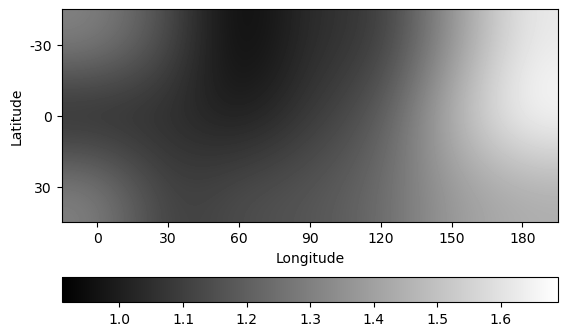

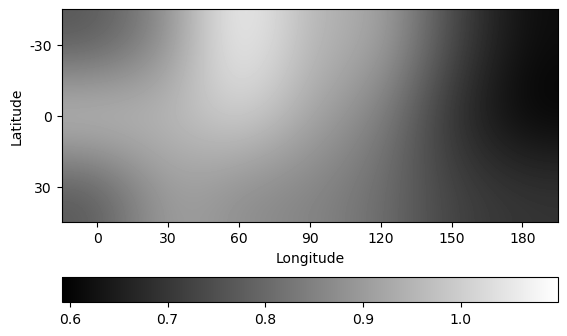

(3, 7)
#####
ratio [[0.75883312 0.87297719 1.09942897 0.94622594 0.92971982 0.73500844
  0.61446326]
 [1.         0.95401811 1.02303662 0.92218823 0.85114734 0.68253641
  0.59187685]
 [0.76153885 0.92110537 0.87098394 0.8559094  0.81290321 0.72180276
  0.69609722]]
#####
log [[-0.39814545 -0.19598414  0.1367544  -0.07974339 -0.10513209 -0.44416727
  -0.70260135]
 [ 0.         -0.06791144  0.03285779 -0.11686685 -0.2325192  -0.55102208
  -0.75663107]
 [-0.39301046 -0.1185619  -0.19928197 -0.22447    -0.29884452 -0.47032344
  -0.52263928]]
#####
RATIO!!
remove one


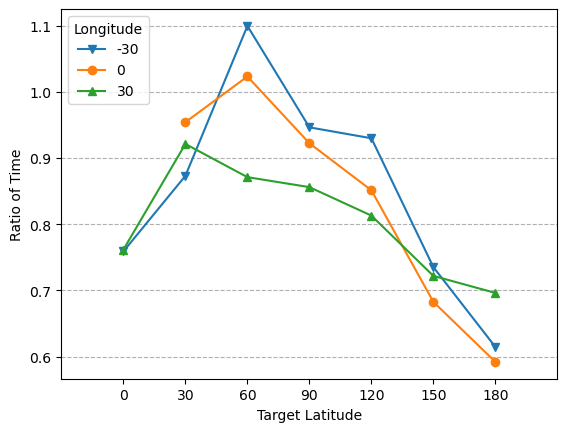

LOG!!
remove zero


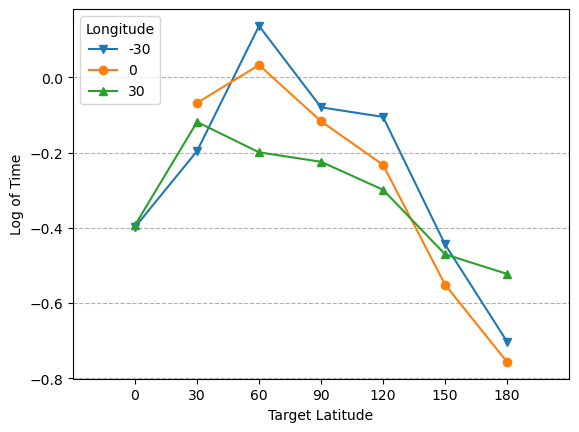

data to cal is (20, 1)
(3, 7)
2
data to cal is (20, 1)
(3, 7)
2
(3, 7)
#####
ratio [[1.3178128  1.1455053  0.90956308 1.05683004 1.07559286 1.36052859
  1.62743661]
 [1.         1.04819813 0.97748211 1.08437732 1.17488472 1.46512329
  1.68954066]
 [1.31313065 1.08565213 1.14812679 1.16834796 1.23015876 1.38542003
  1.43658094]]
#####
log [[ 0.39814545  0.19598414 -0.1367544   0.07974339  0.10513209  0.44416727
   0.70260135]
 [ 0.          0.06791144 -0.03285779  0.11686685  0.2325192   0.55102208
   0.75663107]
 [ 0.39301046  0.1185619   0.19928197  0.22447     0.29884452  0.47032344
   0.52263928]]
#####
RATIO!!
remove one


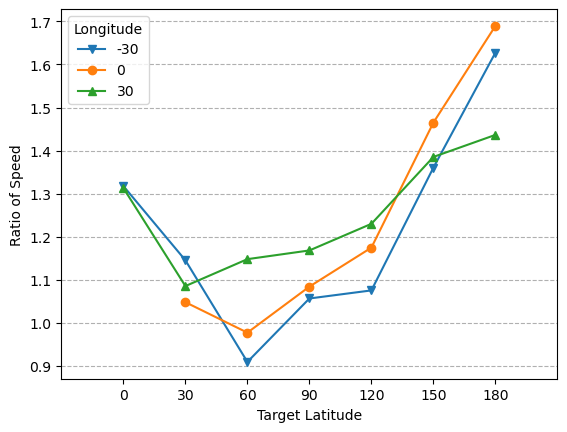

LOG!!
remove zero


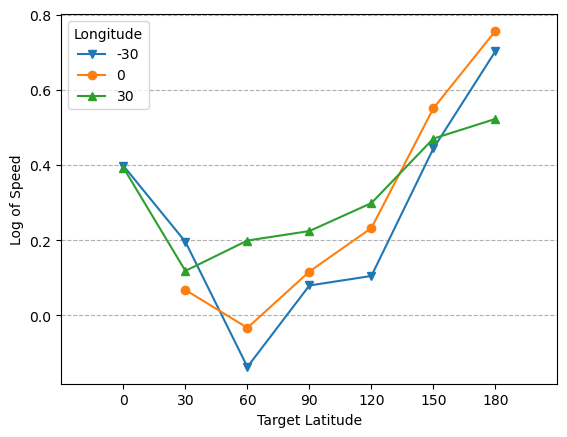

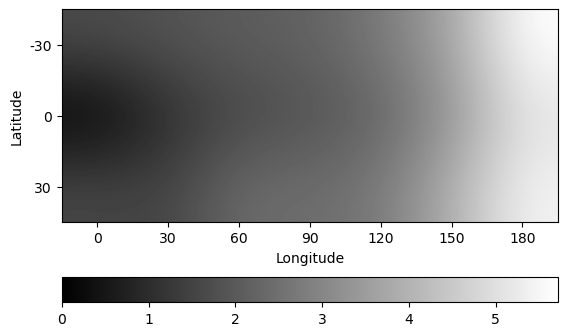

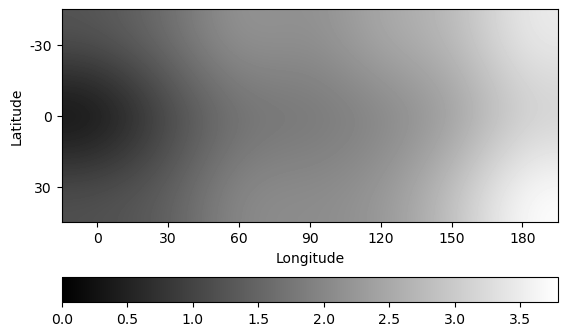

In [101]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap_3x7(input_data):

    fig, ax = plt.subplots()
    
    y = LAT_KEY_F
    x = LON_KEY_F
    z = np.array(input_data)
    im = ax.imshow(z, cmap=cm.gray, interpolation='bicubic')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax, orientation="horizontal")
    
    plt.xticks(range(len(x)),x)
    plt.yticks(range(len(y)),y)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    export_img('heatmap')
    plt.show()


ratio_speed, log_speed= User.cal_ratio(Speed(test1.mean.time_3x7_mean).value, 
                                       Speed(test2.mean.time_3x7_mean).value)
ratio_time, log_time= User.cal_ratio(test1.mean.time_3x7_mean, test2.mean.time_3x7_mean)


print( "#"*30, "\n\n Heat Map \n\n","#"*30)
print("ratio_speed")
print(ratio_speed)
print("ratio_time")
print(ratio_time)
plot_heatmap_3x7(ratio_speed)
plot_heatmap_3x7(ratio_time)

plot_ratio("Time", test1.mean.time_3x7_mean, test2.mean.time_3x7_mean)
plot_ratio("Speed", Speed(test1.mean.time_3x7_mean).value, 
                                       Speed(test2.mean.time_3x7_mean).value)

#print(test1.mean.time_3x7_mean == m_mean(test1.mean.time_3x7x10))
plot_heatmap_3x7(test1.mean.time_3x7_mean)
plot_heatmap_3x7(test2.mean.time_3x7_mean)

In [178]:
#ur,ul = User.cal_ratio(test1.mean.time_1x10, test2.mean.time_1x10)
#print(ur)
ur, log = User.cal_ratio([m_sum(test1.mean.time_10x4)], [m_sum(test2.mean.time_10x4)])
ur, log = User.cal_ratio([m_sum(m_sum(test1.mean.time_10x3x7))], [m_sum(m_sum(test2.mean.time_10x3x7))])
print('1-2 user-wise ratio:\n',ur)  

ur345, log = User.cal_ratio([m_sum(test3.mean.time_10x4),m_sum(test3.mean.time_10x4),m_sum(test4.mean.time_10x4)],
                             [m_sum(test4.mean.time_10x4),m_sum(test5.mean.time_10x4),m_sum(test5.mean.time_10x4)])
ur345, log = User.cal_ratio([m_sum(m_sum(test3.mean.time_10x3x7)),
                             m_sum(m_sum(test3.mean.time_10x3x7)),
                             m_sum(m_sum(test4.mean.time_10x3x7))],
                             [m_sum(m_sum(test4.mean.time_10x3x7)),
                              m_sum(m_sum(test5.mean.time_10x3x7)),
                              m_sum(m_sum(test5.mean.time_10x3x7))])
print('3-4-5 user-wise ratio:\n',ur345)




print(4*np.array(m_sum(m_mean(time_10x334.T))))
print(m_mean(m_sum(test3.mean.time_10x4)))

data to cal is (14, 4)
data to cal is (14, 4)
data to cal is (14, 3, 7)
data to cal is (14, 3)
data to cal is (14, 3, 7)
data to cal is (14, 3)
1-2 user-wise ratio:
 [[0.9569254128118763, 0.7212688100680686, 0.7694716279078732, 0.8487079431861737, 0.7929540285256127, 0.6542590774422417, 1.1085703400475062, 0.8095528202841795, 0.8431495574599066, 0.8320635220335901, 0.41184182710954126, 0.8833010797692421, 0.9278443257360126, 0.7112527264417341]]
data to cal is (6, 4)
data to cal is (6, 4)
data to cal is (6, 4)
data to cal is (6, 4)
data to cal is (6, 4)
data to cal is (6, 4)
data to cal is (6, 1, 7)
data to cal is (6, 1)
data to cal is (6, 1, 7)
data to cal is (6, 1)
data to cal is (6, 1, 7)
data to cal is (6, 1)
data to cal is (6, 1, 7)
data to cal is (6, 1)
data to cal is (6, 1, 7)
data to cal is (6, 1)
data to cal is (6, 1, 7)
data to cal is (6, 1)
3-4-5 user-wise ratio:
 [[1.2246130843867449, 0.9662799022057735, 0.9694591097738197, 1.0390504693835134, 0.9761214385326465, 1.07522138

In [142]:
### Bar Plot ###



from matplotlib.ticker import NullFormatter

def plot_bar_single(input_mean, ymin=None, ymax=None, x_title=None, y_title=None, z_title=None):
    
    print(np.array(input_mean).shape)
    
    if (np.array(input_mean).shape == (3,7)):
        mean=input_mean
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
        str1='('
        str2=','
        str3=')'
       
    elif (np.array(input_mean).shape == (7,3)):
        mean=np.array(input_mean).T
        key1=['C3-C4', 'C3-C5', 'C4-C5']
        key2=[0, 30, 60, 90, 120, 150, 180]
        str1=''
        str2=' (0,'
        str3=')'
        
    elif (len(input_mean[0])>7):
        mean=input_mean
        key1=['User']
        key2=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]
        str1=''
        str2='-'
        str3=''

    fig, ax = plt.subplots()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    #if (len(key1) ==3 or len(key1) ==7):
    #    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    #else:
    #    width = 5
    wwidth = 10
    width = 10 / (len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = (wwidth)*k1 + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x, mean[k1][k2], 2*width, #label=str(key2[k2]
                    color= str(0.7-0.05*k2) )
                    #alpha=1-opacity*k2)
            
            x_axis.append(x)
            x_label.append(str1+str(key1[k1])+str2+str(key2[k2])+str3)
            #x_label.append((key1[k1],key2[k2]))
    
    
    yref1=0.01
    yref2=0.05
    yref3=0.1
    plt.axhline(y=yref1,linewidth=1, color='C1')
    plt.axhline(y=yref2,linewidth=1, color='C1')
    plt.axhline(y=yref3,linewidth=1, color='C1')
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    plt.yscale('log')
    ax.set_axisbelow(True)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    if z_title is not None:
        ax.legend(title=z_title)
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    ax.set_ylim(ymin, ymax)
    plt.xticks(x_axis, x_label, rotation=90)
    
    export_img('barsingle')
    plt.show()





def plot_bar_dual_any(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None):
    
    key1, key2 = which_axis(input_mean_1)
    
    mean_1 = input_mean_1
    mean_2 = input_mean_2
    
    std_1 = input_std_1 if (input_std_1 is not None) else np.zeros_like[mean_1]
    std_2 = input_std_2 if (input_std_2 is not None) else np.zeros_like[mean_2]


    plt.figure(1, figsize = (12,16))  
    fig, ax = plt.subplots()
    
    #plt.subplot(2, 1, 1)
    #ax = plt.gca()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    
    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean_1[k1][k2], width, #label=str(key2[k2]
                    color="C0", alpha=1-opacity*k2, yerr=std_1[k1][k2])
            plt.bar(x + offset , mean_2[k1][k2], width,
                    color="C3", alpha=1-opacity*k2, yerr=std_2[k1][k2])
            
            x_axis.append(x+0.5*offset)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))
    
    plt.bar(1,0,1, color="C0", label="C1")
    plt.bar(2,0,1, color="C3", label="C2")
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_ylabel(y_title)
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    ax.legend(title="Condition")
    
    plt.xticks(x_axis, x_label, rotation=90)
    
    export_img('barplot')
    plt.show()

data to cal is (2, 10)
data to cal is (2, 10)
No Zero OFF
[478.2379555555556, 575.6192444444445] [430.41416, 518.05732]
data to cal is (2, 10)
No Zero OFF
data to cal is (2, 10)
No Zero OFF


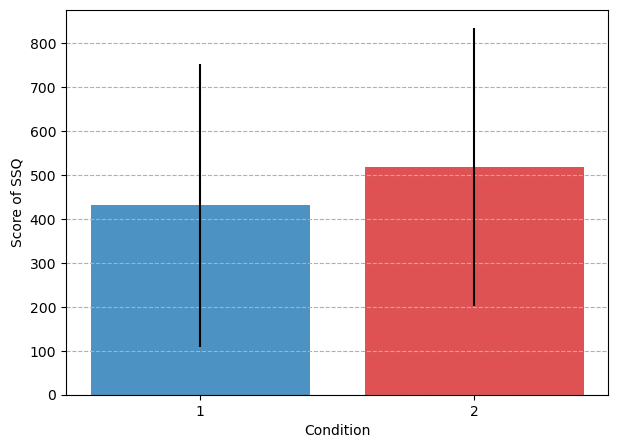

data to cal is (2, 10)
No Zero OFF
data to cal is (2, 10)
No Zero OFF


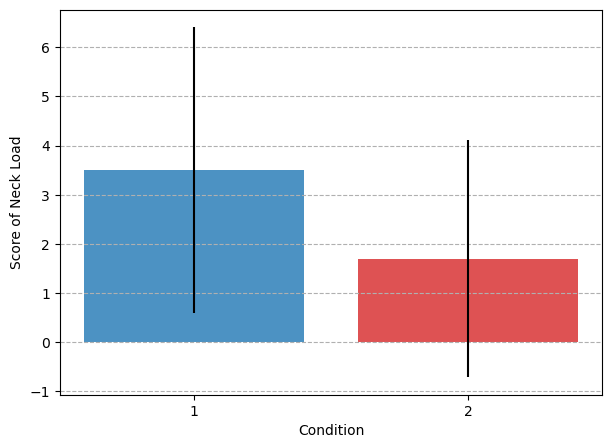

data to cal is (3, 6)
No Zero OFF
data to cal is (3, 6)
No Zero OFF


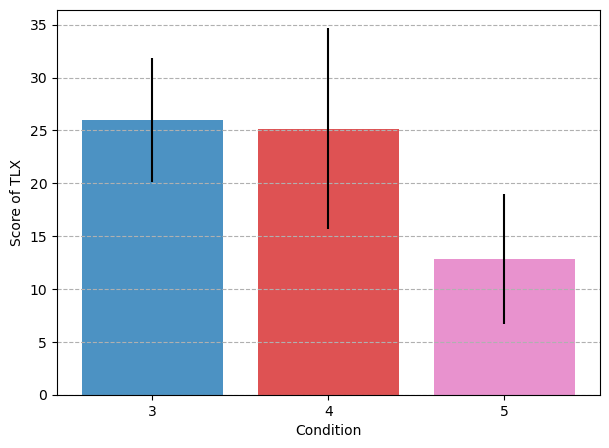

data to cal is (14, 20)
data to cal is (14,)
data to cal is (14, 20)
data to cal is (14,)
data to cal is (14, 20)
data to cal is (14,)
data to cal is (14, 20)
data to cal is (14,)


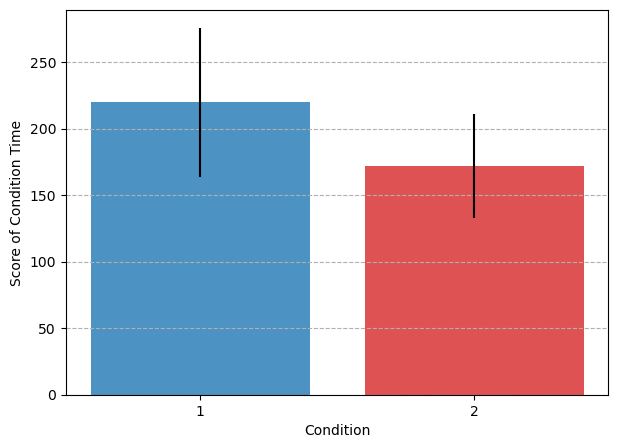

In [105]:
### Questionnaire ###


ssq =[[0, 712.9188, 780.6128, 781.5852, 288.8776, 253.198, 139.8012, 357.3196, 64.0288, 925.7996],
      [0, 596.8292, 826.3156, 712.9188, 229.4864, 433.3164, 918.4692, 357.3196, 160.82, 945.098]]
nl =[[0, 1, 9, 8, 3, 3, 5, 0, 3, 3],
     [0, 0, 7, 2, 0, 0, 5, 0, 0, 3]]

tlx=[[27,	30,	36,	19,	20,	24],
    [32,	21,	41,	20,	26,	11],
    [22,	2,	15,	12,	16,	10]]


print(m_mean(ssq), m_mean_0(ssq))

plotcontrast2(m_mean_0(ssq), m_std_0(ssq), 'SSQ')
plotcontrast2(m_mean_0(nl), m_std_0(nl), 'Neck Load')
plotcontrast2(m_mean_0(tlx), m_std_0(tlx), 'TLX')

plotcontrast2([4*m_mean(m_sum(test1.mean.time_20x10.T)),
               4*m_mean(m_sum(test2.mean.time_20x10.T))],
              [4*m_std(m_sum(test1.mean.time_20x10.T)),
               4*m_std(m_sum(test2.mean.time_20x10.T))],
              'Condition Time')